In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
class Plane:
    def __init__(self, n: np.array, d: float):
        if not isinstance(n, np.ndarray):
            raise ValueError("n must be a numpy array")

        self.n = n
        self.d = d

    def distance(self, p: np.array):
        """Calculate the distance of a point to the plane"""
        return np.abs(np.dot(self.n, p) + self.d) / np.linalg.norm(self.n)

    def project_to_plane(self, p: np.array):
        """Project a 3D point onto the plane and return its 2D coordinates"""
        # Find a point on the plane
        point_on_plane = p - (np.dot(self.n, p) + self.d) * self.n

        # Create a local coordinate system on the plane
        u = np.array([-self.n[1], self.n[0], 0])  # Arbitrary vector orthogonal to n
        if np.allclose(u, 0):
            u = np.array([0, -self.n[2], self.n[1]])  # Handle edge case
        u = u / np.linalg.norm(u)  # Normalize
        v = np.cross(self.n, u)  # Ensure v is orthogonal to both n and u

        # Project the point onto the local 2D basis
        x = np.dot(point_on_plane, u)
        y = np.dot(point_on_plane, v)
        return np.array([x, y]), u, v

    def transform_covariance(self, cov_3d: np.array, u: np.array, v: np.array):
        """Transform a 3D covariance matrix to 2D on the plane"""
        # Transformation matrix from 3D to 2D
        T = np.stack((u, v), axis=0)  # Shape: (2, 3)
        # Project the covariance matrix
        cov_2d = T @ cov_3d @ T.T  # Shape: (2, 2)
        return cov_2d

    def transform_to_2d(self, position: np.array, covariance: np.array):
        """Transform a 3D position and covariance to 2D on the plane"""
        if not isinstance(position, np.ndarray) or not isinstance(
            covariance, np.ndarray
        ):
            raise ValueError("Position and covariance must be numpy arrays")
        if position.shape != (3,) or covariance.shape != (3, 3):
            raise ValueError(
                "Position must be a 3-element vector and covariance must be 3x3"
            )

        # Project position to 2D
        pos_2d, u, v = self.project_to_plane(position)

        # Transform covariance to 2D
        cov_2d = self.transform_covariance(covariance, u, v)

        return pos_2d, cov_2d

In [ ]:
pdf_file = "/home/workspace/src/log_file/pdf.csv"
gaussian_file = "/home/workspace/src/log_file/gaussian.csv"
joy_file = "/home/workspace/src/log_file/joy.csv"
vacuum_file = "/home/workspace/src/log_file/vacuum.csv"
desired_box_file = "/home/workspace/src/log_file/desired_box.csv"
intersection_length_file = "/home/workspace/src/log_file/intersection_length.csv"

# 헤더를 제외한 데이터 로드드
pdf = pd.read_csv(pdf_file).drop(
    columns=["field.header.seq", "field.header.stamp", "field.header.frame_id"]
)
gaussian = pd.read_csv(gaussian_file).drop(
    columns=[
        "field.header.seq",
        "field.header.stamp",
        "field.header.frame_id",
        "field.pose.pose.orientation.x",
        "field.pose.pose.orientation.y",
        "field.pose.pose.orientation.z",
    ]
)
joy = pd.read_csv(joy_file).drop(
    columns=[
        "field.header.seq",
        "field.header.stamp",
        "field.header.frame_id",
        "field.axes0",
        "field.axes1",
    ]
)
vacuum = pd.read_csv(vacuum_file)
desired_box = pd.read_csv(desired_box_file)
intersection_length = pd.read_csv(intersection_length_file)

# 시간 데이터를 datetime 형식으로 변환
pdf["%time"] = pd.to_datetime(pdf["%time"])
gaussian["%time"] = pd.to_datetime(gaussian["%time"])
joy["%time"] = pd.to_datetime(joy["%time"])
vacuum["%time"] = pd.to_datetime(vacuum["%time"])
desired_box["%time"] = pd.to_datetime(desired_box["%time"])
intersection_length["%time"] = pd.to_datetime(intersection_length["%time"])

# 병합 100ms, 10hz 기준으로 병합합
merged_data = pd.merge_asof(
    pdf, gaussian, on="%time", tolerance=pd.Timedelta("100ms"), direction="nearest"
)
merged_data = pd.merge_asof(
    merged_data, joy, on="%time", tolerance=pd.Timedelta("100ms"), direction="nearest"
)
merged_data = pd.merge_asof(
    merged_data,
    intersection_length,
    on="%time",
    tolerance=pd.Timedelta("100ms"),
    direction="nearest",
)
merged_data = pd.merge_asof(
    merged_data,
    vacuum,
    on="%time",
    tolerance=pd.Timedelta("100ms"),
    direction="nearest",
)
merged_data = pd.merge_asof(
    merged_data,
    desired_box,
    on="%time",
    tolerance=pd.Timedelta("100ms"),
    direction="nearest",
)


# 주기에 맞지 않는 데이터 보간
merged_data["field.buttons0"] = merged_data["field.buttons0"].fillna(method="ffill")
merged_data["field.buttons1"] = merged_data["field.buttons1"].fillna(method="ffill")
merged_data["field.buttons2"] = merged_data["field.buttons2"].fillna(method="ffill")
merged_data["field.buttons3"] = merged_data["field.buttons3"].fillna(method="ffill")
merged_data["intersection_length"] = merged_data["intersection_length"].fillna(
    method="ffill"
)
merged_data["desired_box"] = merged_data["desired_box"].fillna(method="ffill")


display(merged_data)

In [ ]:
# 인덱스 사이 구간을 가지는 데이터프레임으로 분할 (예외 처리 포함)
def split_dataframe_by_indices(df, indices):
    split_dataframes = []

    # 1. 첫 번째 구간: 처음부터 첫 번째 인덱스 이전까지
    if indices[0] > 0:
        split_dataframes.append(df.loc[: indices[0] - 1])

    # 2. 중간 구간: 각 인덱스 사이
    for start, end in zip(indices, indices[1:]):
        if start + 1 < end:  # 인덱스가 붙어 있지 않은 경우만 추가
            split_dataframes.append(df.loc[start + 1 : end - 1])

    # 3. 마지막 구간: 마지막 인덱스 이후부터 끝까지
    if indices[-1] < len(df) - 1:
        split_dataframes.append(df.loc[indices[-1] + 1 :])

    return split_dataframes

In [ ]:
from scipy.integrate import quad
import matplotlib.patches as patches
import matplotlib.pyplot as plt


merged_data["desired_box"] = merged_data["desired_box"].astype(int)
merged_data["intersection_length"] = merged_data["intersection_length"].astype(int)
merged_data["field.buttons0"] = merged_data["field.buttons0"].astype(int)
merged_data["field.buttons1"] = merged_data["field.buttons1"].astype(int)
merged_data["field.buttons2"] = merged_data["field.buttons2"].astype(int)
merged_data["field.buttons3"] = merged_data["field.buttons3"].astype(int)

# 잡으려는 박스의 번호
desired_box_values = sorted(merged_data["desired_box"].unique().astype(int).tolist())


tasks = {}

for desired_box in desired_box_values:
    tasks[str(desired_box)] = merged_data[merged_data["desired_box"] == desired_box]


for key, task in tasks.items():

    # 타겟 박스 번호 추출
    target_id = int(key)

    # 시간 순으로 정렬
    task = task.sort_values(by="%time")

    # Vacuum Off 인덱스 추출 및 슬라이싱
    indices = task.index[task["field.buttons1"] == 1].tolist()
    split_dataframes = split_dataframe_by_indices(task, indices)

    for i, splited_df in enumerate(split_dataframes):
        # A 버튼 누른 인덱스 조회
        a_indices = splited_df.index[splited_df["field.buttons0"] == 1].tolist()

        # A 버튼 누른 인덱스가 있으면, 가장 마지막에 누른 이후 데이터만 취급함함
        if len(a_indices) != 0:
            splited_df = splited_df.loc[a_indices[-1] + 1 :]

        # 교차점이 없는 데이터는 제외
        splited_df = splited_df[splited_df["intersection_length"] > 0]

        if splited_df.shape[0] < 20:
            print(f"Box {target_id} has no intersection data.")
            continue

        # 시간을 0부터 시작하는 초단위로 변경
        splited_df["%time"] = splited_df["%time"] - splited_df["%time"].iloc[0]
        splited_df["%time"] = splited_df["%time"].dt.total_seconds()

        vacuum_trigger = splited_df.index[splited_df["vacuum"] == "on"].tolist()
        trigger_times = splited_df.loc[vacuum_trigger, "%time"].tolist()

        plot = False
        export = False

        if export:
            # 데이터 저장
            splited_df.to_csv(
                f"/home/workspace/src/log_file/pose_processed(2)/box{target_id}_data{i}.csv",
                index=False,
                encoding="utf-8",
            )

        if plot:
            display(splited_df.info())

            # 그래프 그리기
            plt.figure(figsize=(10, 10))

            # 각 박스의 PDF 그래프 그리기
            for i in range(len(desired_box_values)):
                box_id = splited_df[f"field.boxes{i}.id"].iloc[0]
                plt.plot(
                    splited_df["%time"].to_numpy(),
                    splited_df[f"field.boxes{i}.pdf"].to_numpy(),
                    label=f"box{box_id}",
                    c="r" if box_id == target_id else None,
                )

            # 수직선 추가
            plt.axvline(
                x=trigger_times[-1], color="red", linestyle="--", label="Vacuum Trigger"
            )

            plt.legend()

            plt.xlim(-0.1, 10.0)
            plt.ylim(-0.1, 1.1)

            plt.xlabel("Time (s)")
            plt.ylabel("PDF")

            plt.title(f"PDF of Boxes. Target: {target_id}")

            plt.grid()
            plt.show()

        # break
    # break

Box 0 Success Time Rate: 0.02519513248796598


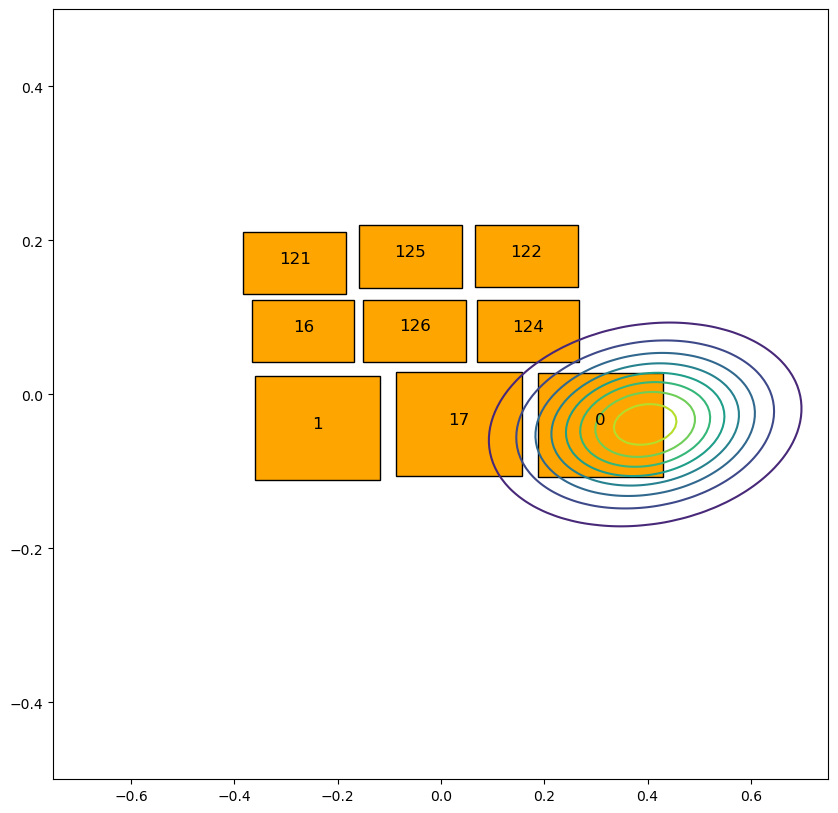

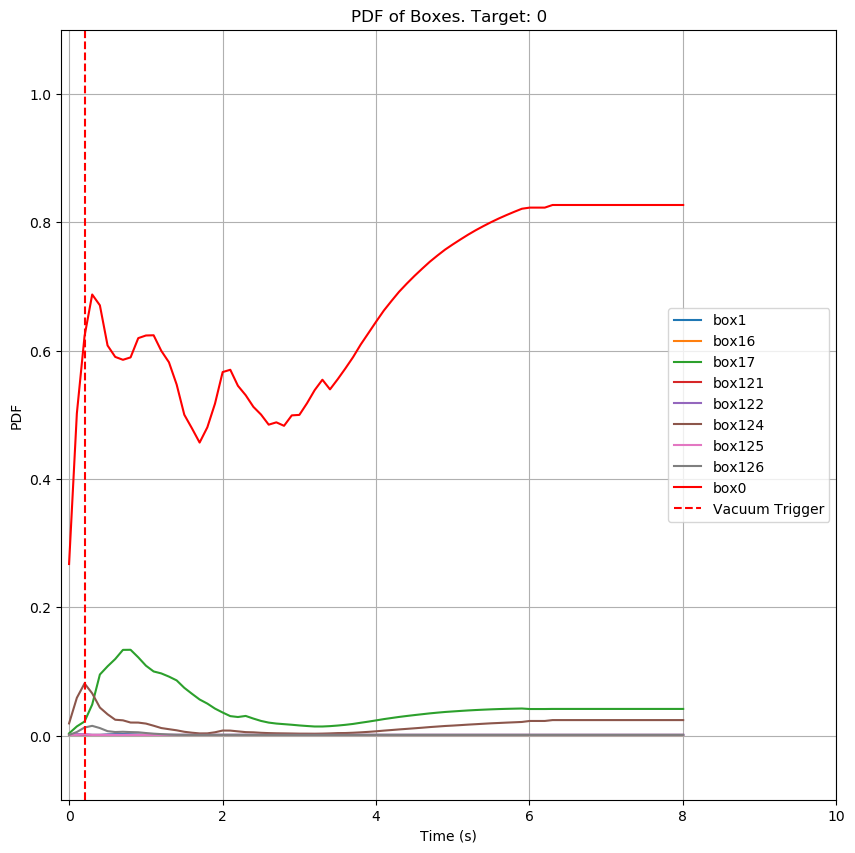

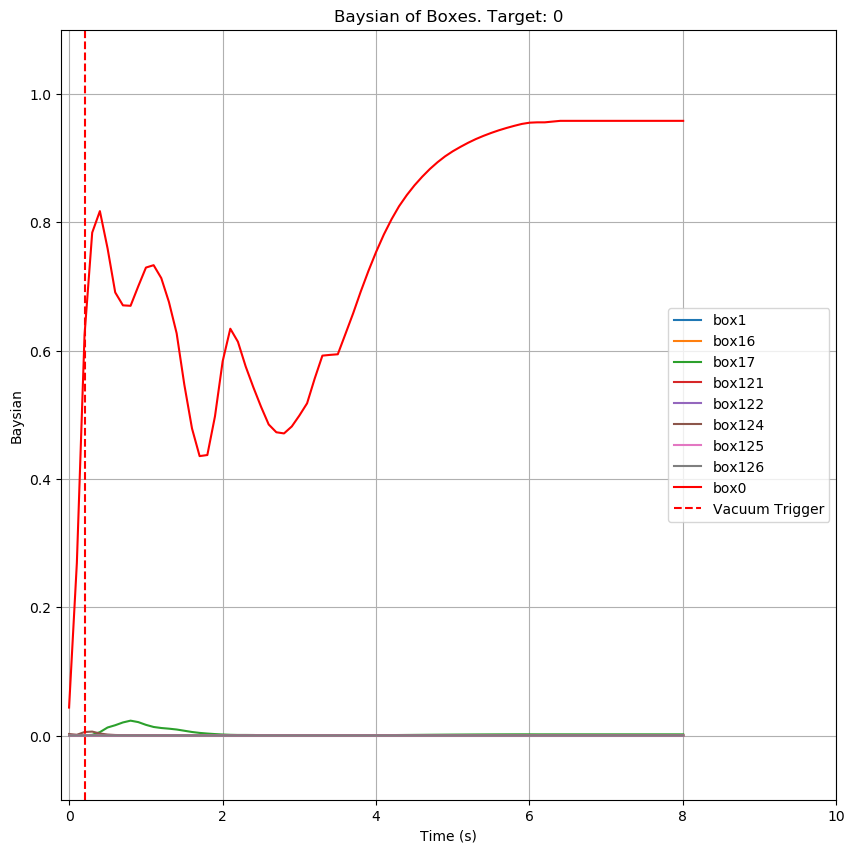

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 0 Success Time Rate: 0.013987855360841038


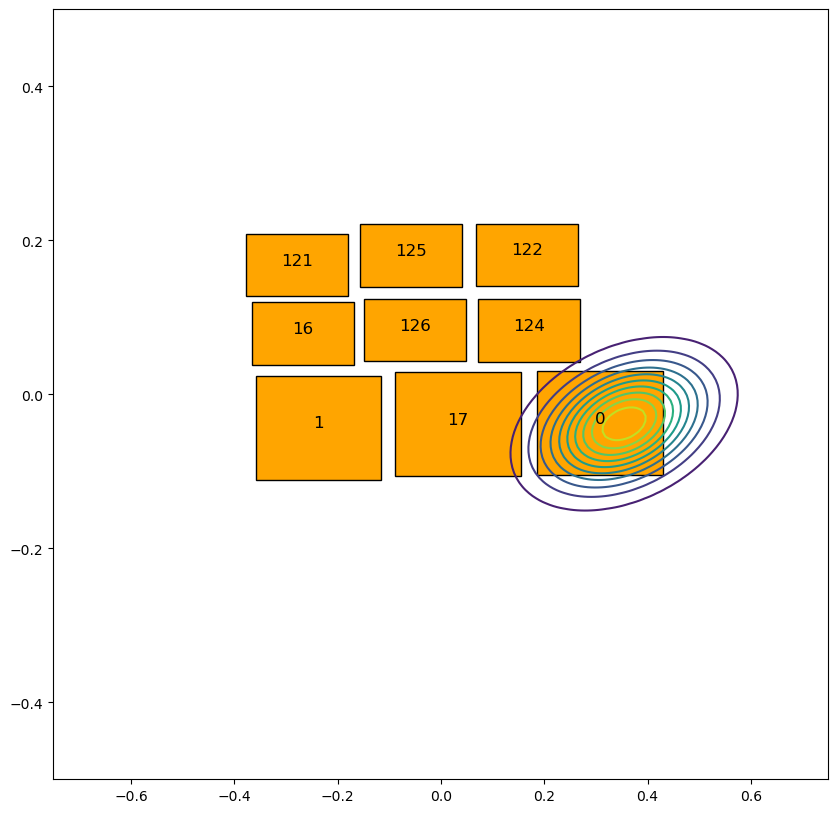

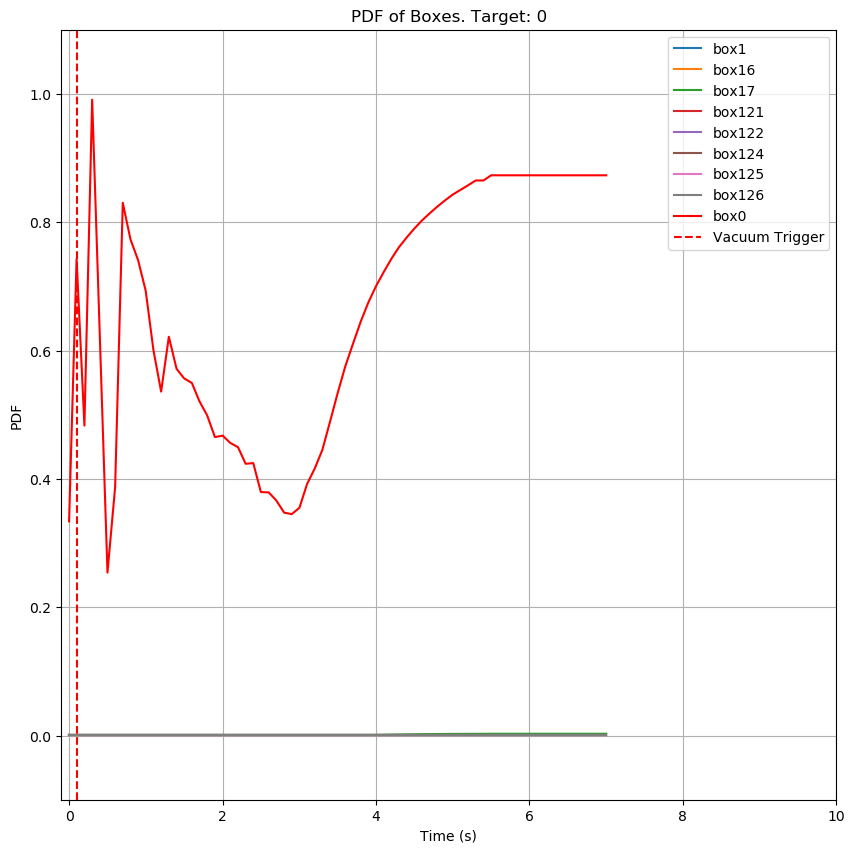

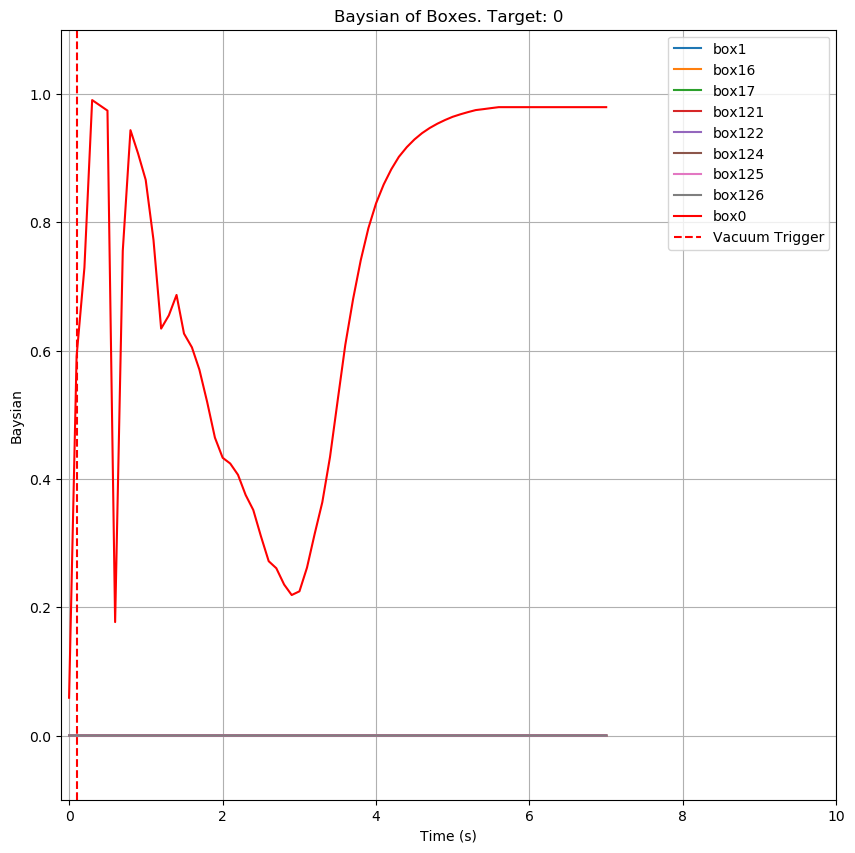

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 0 Success Time Rate: 0.43619201500128846


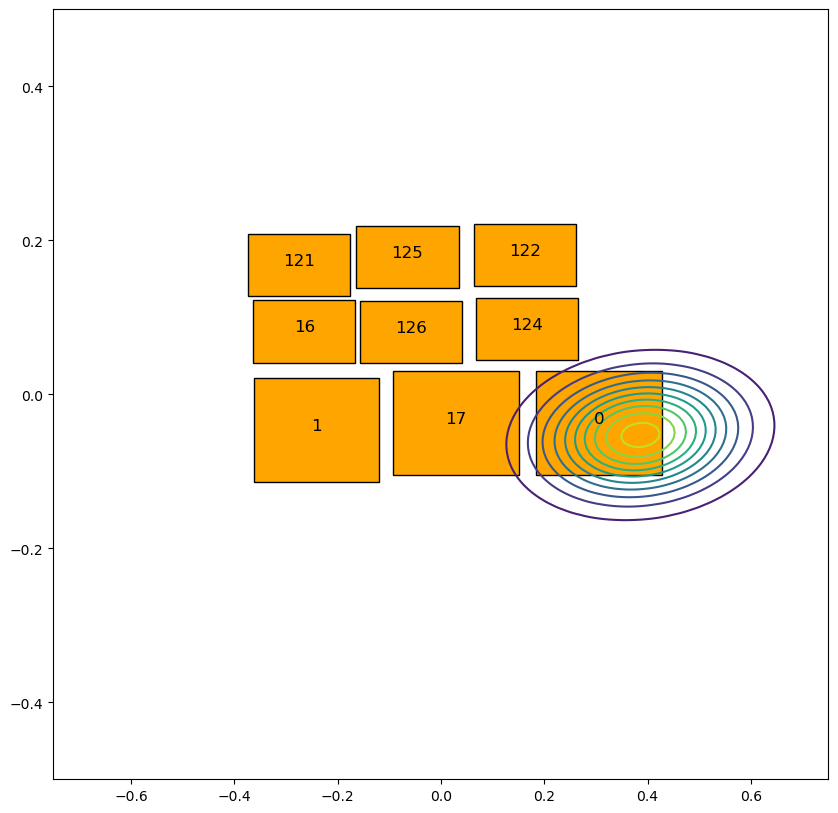

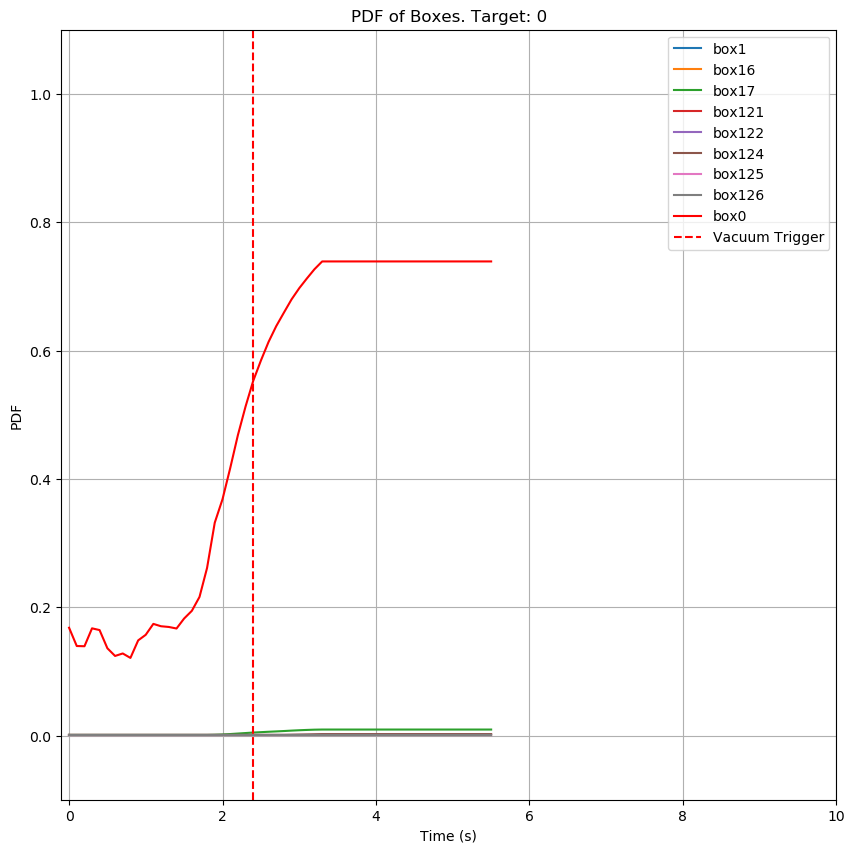

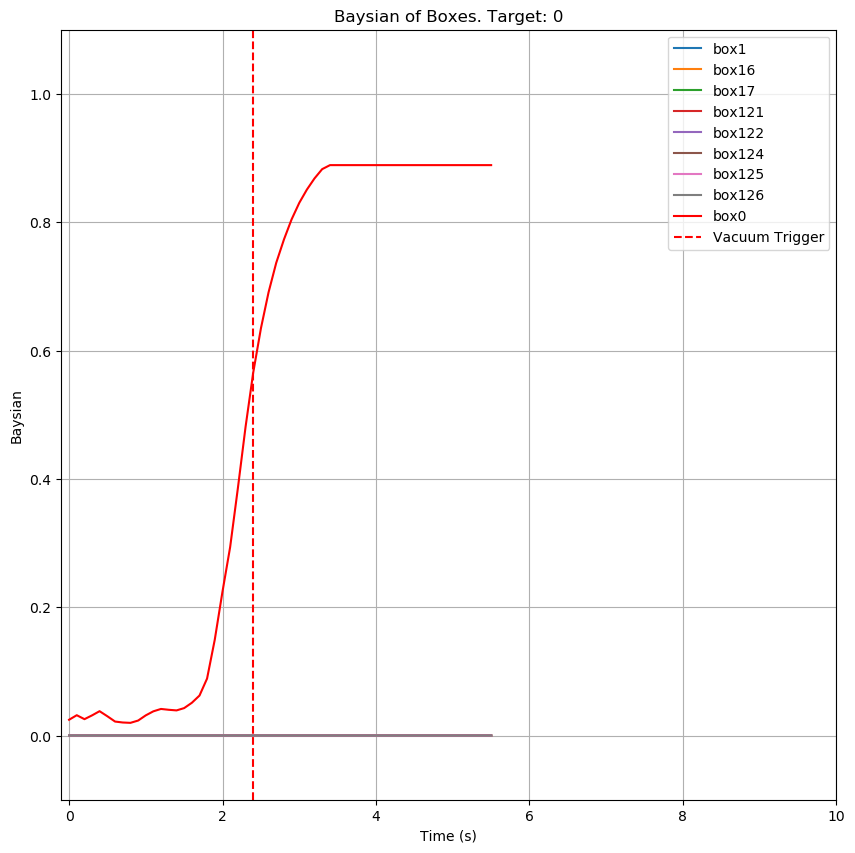

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 0 Success Time Rate: 0.028095930536752505


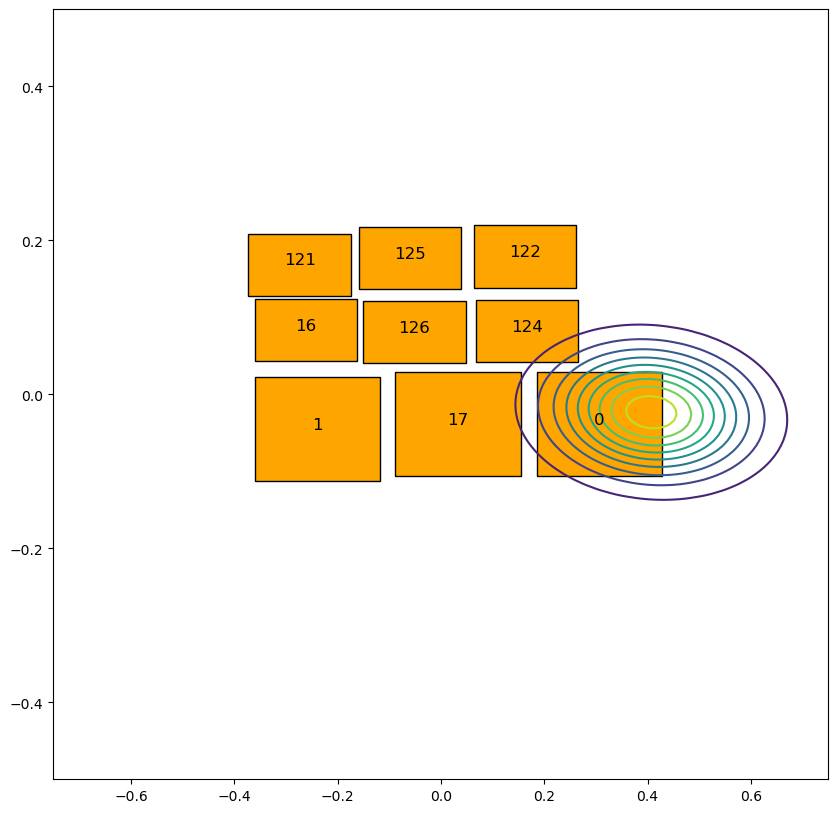

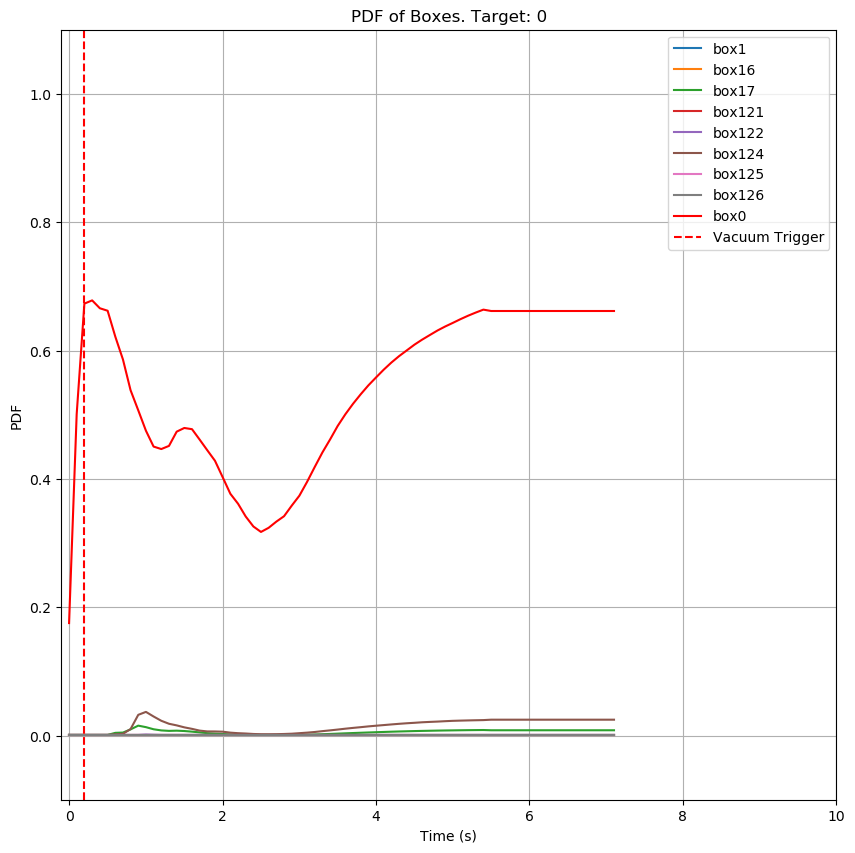

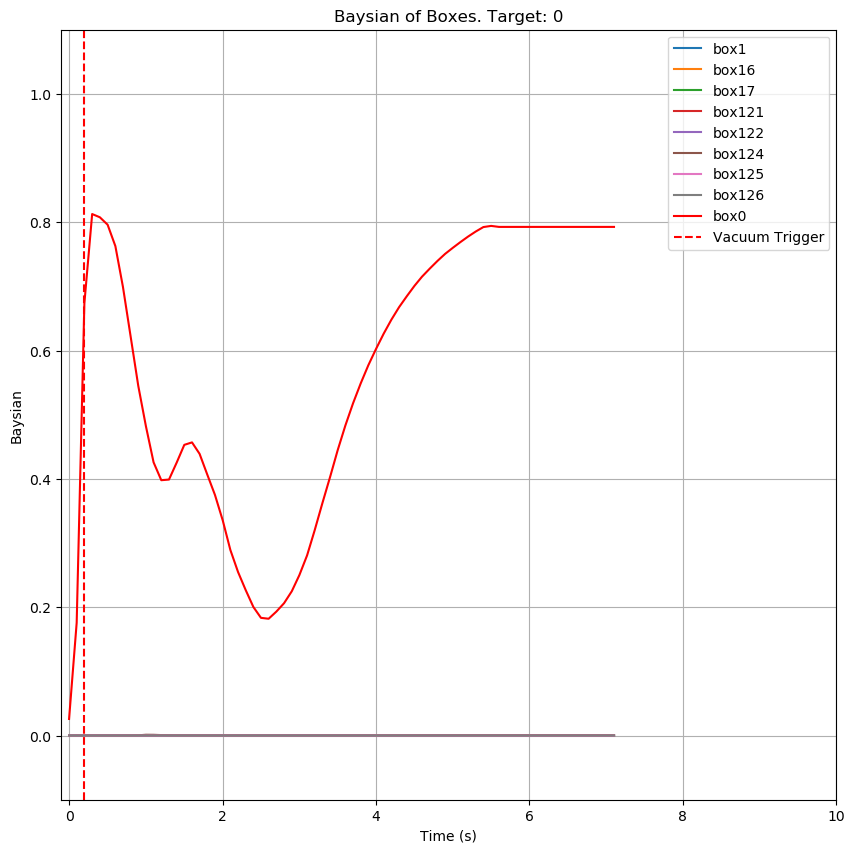

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 0 Success Time Rate: 0.8767077407349902


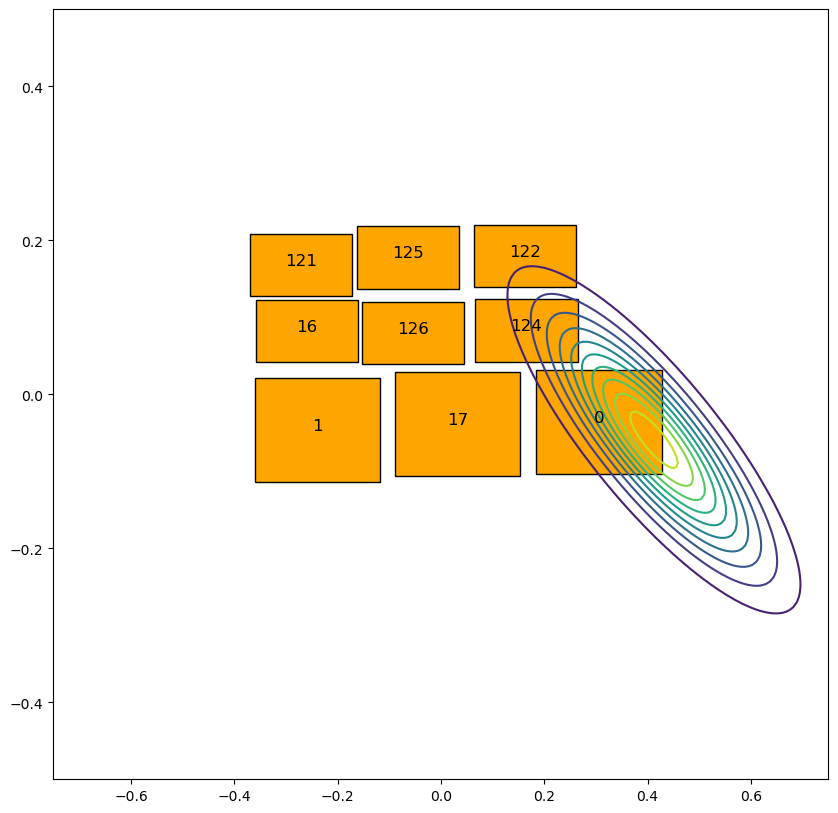

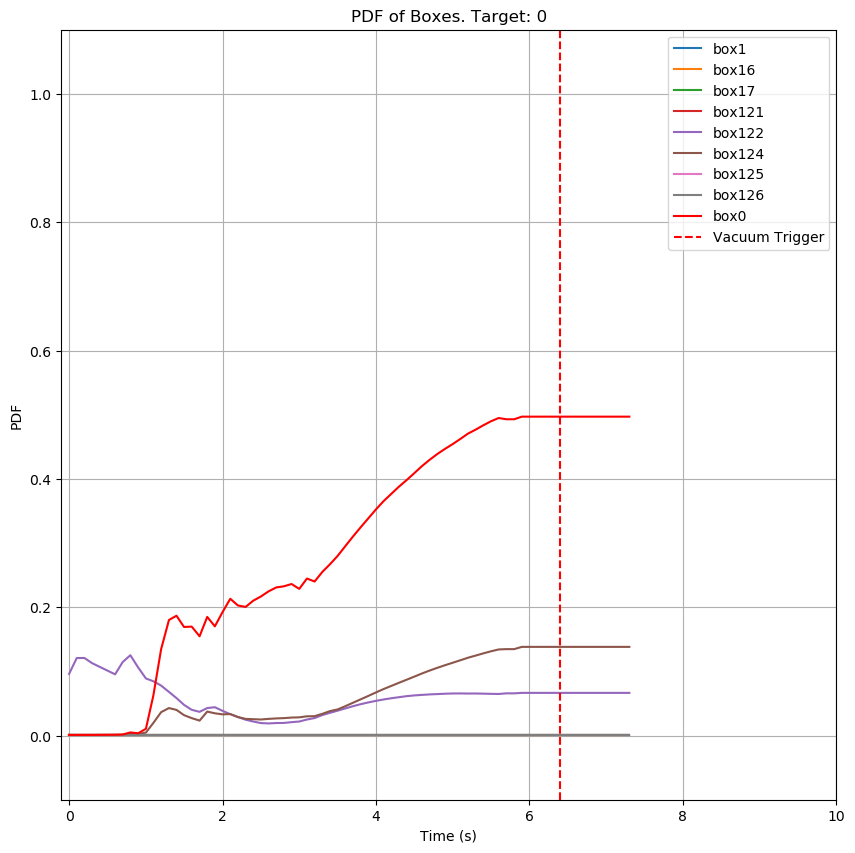

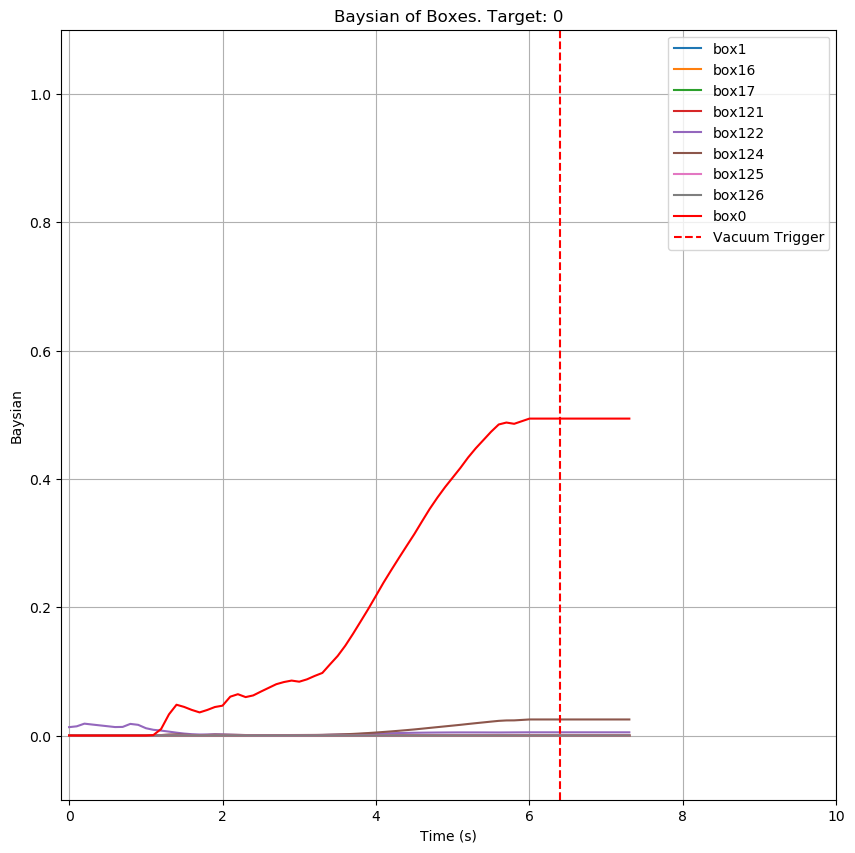

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 121 Success Time Rate: 0.2676028599925698


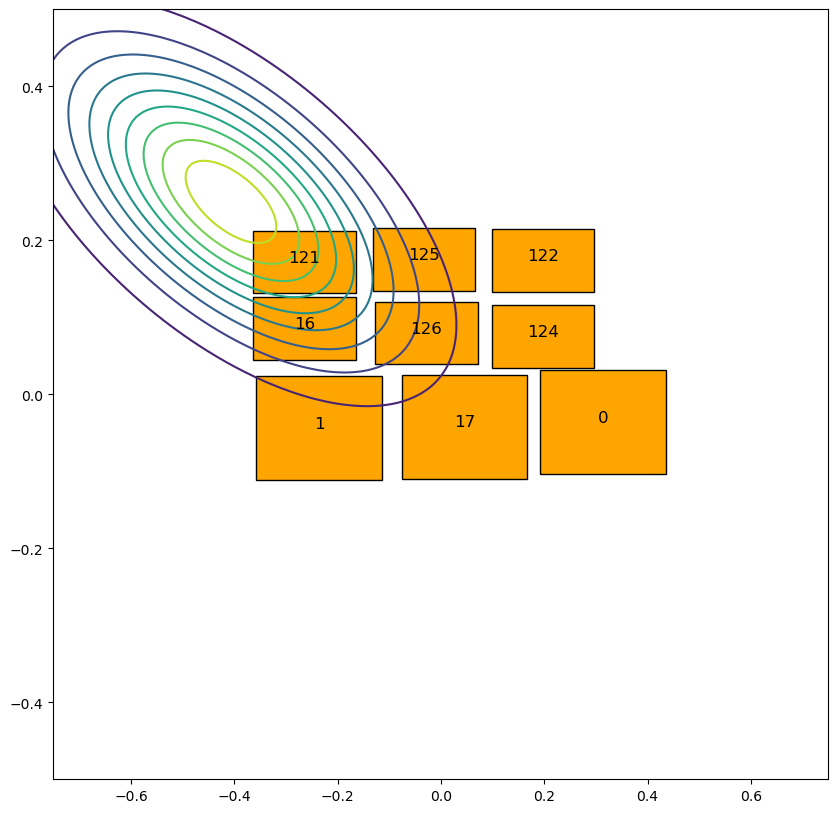

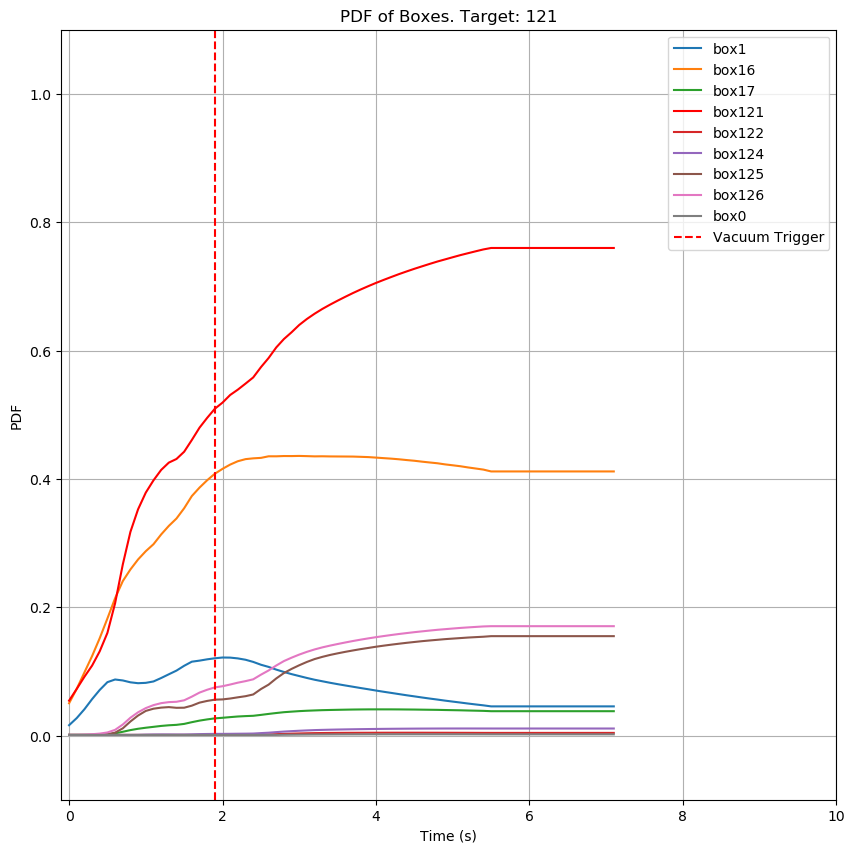

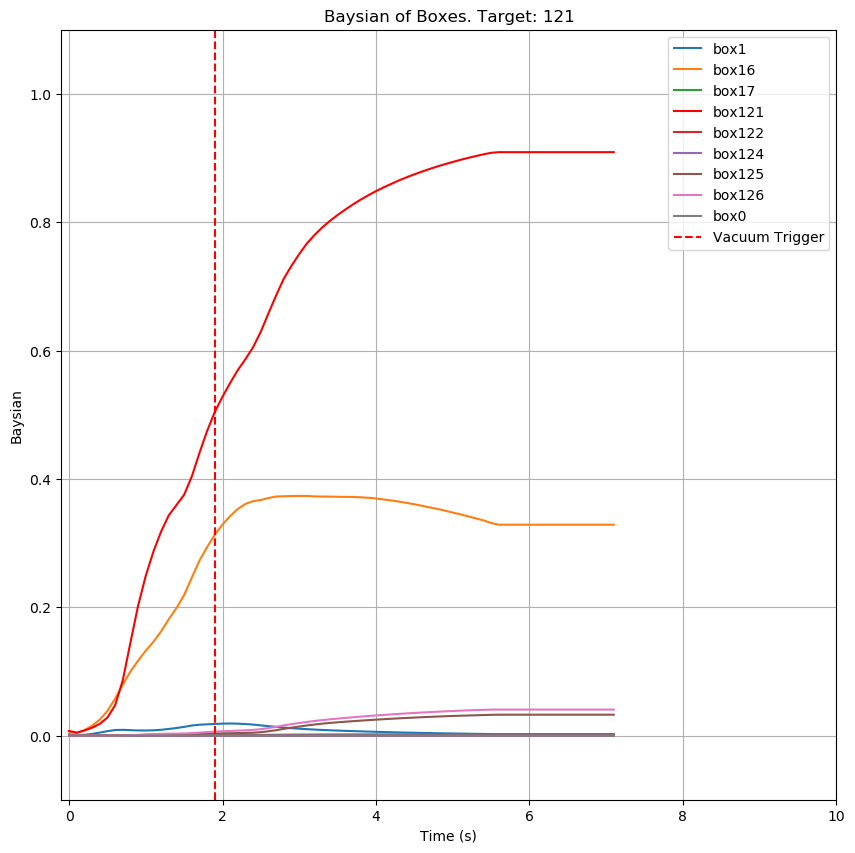

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 121 Success Time Rate: 0.35062427565263365


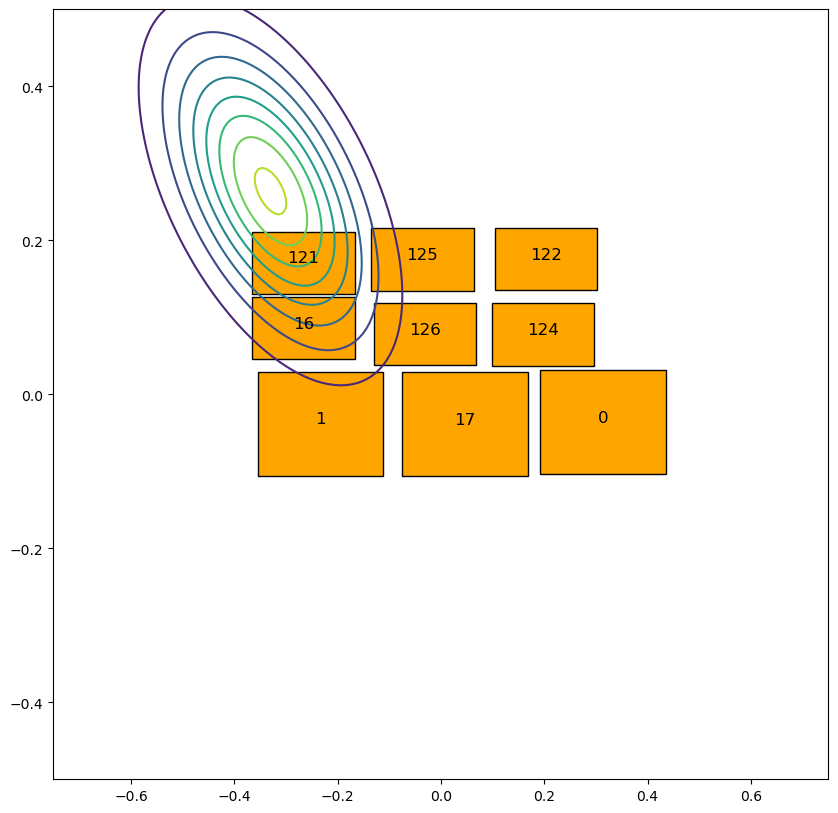

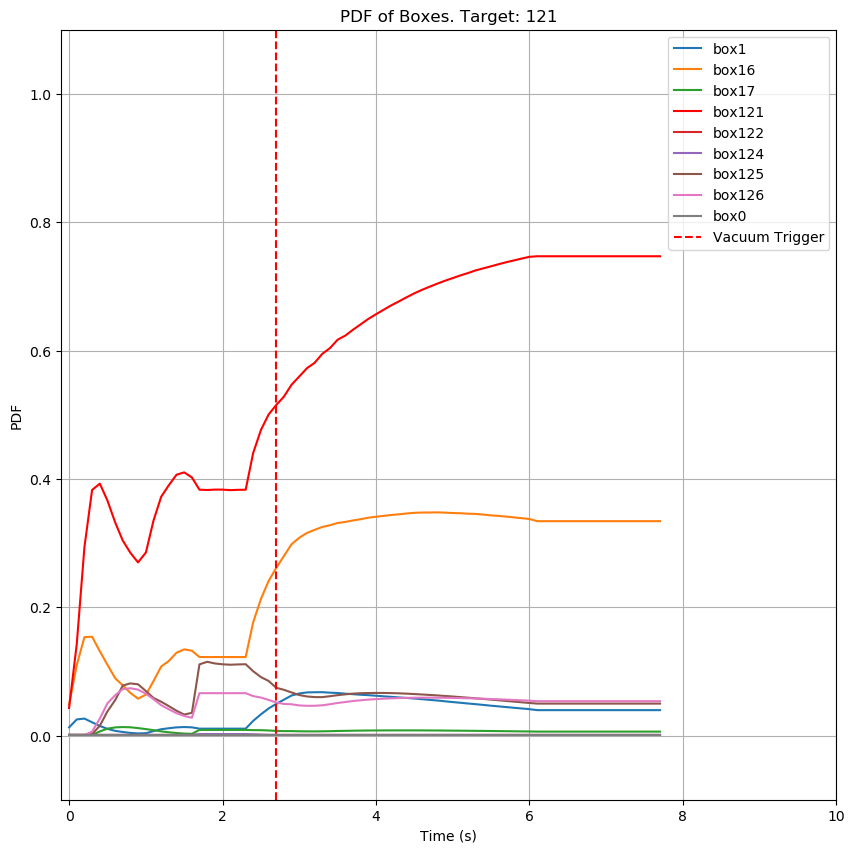

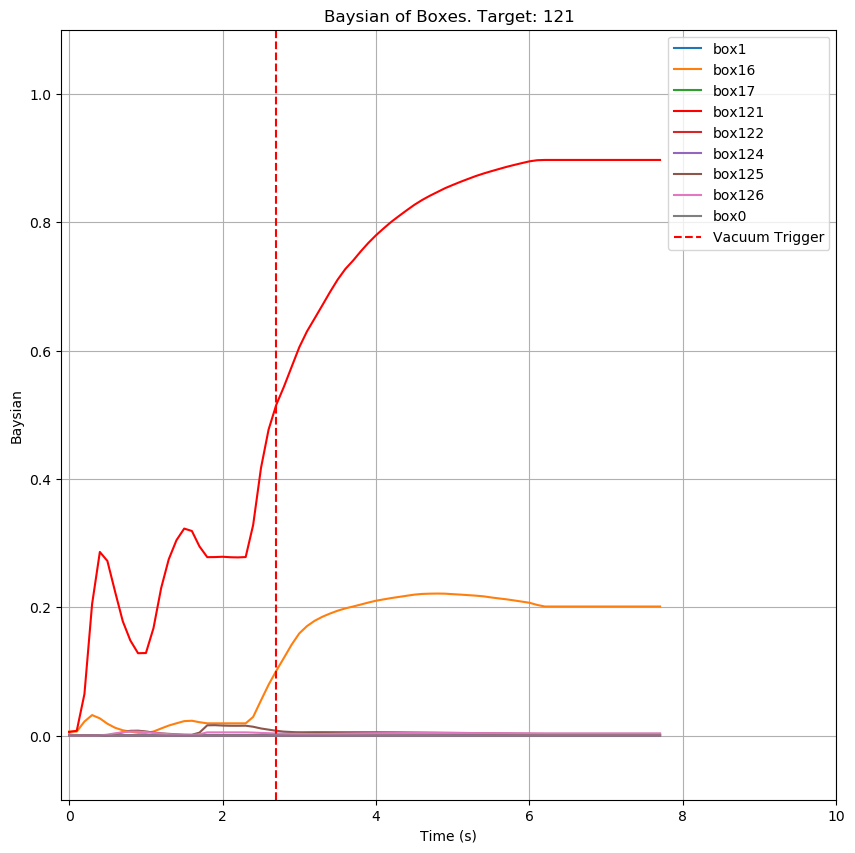

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 121 Success Time Rate: 0.16675570003828308


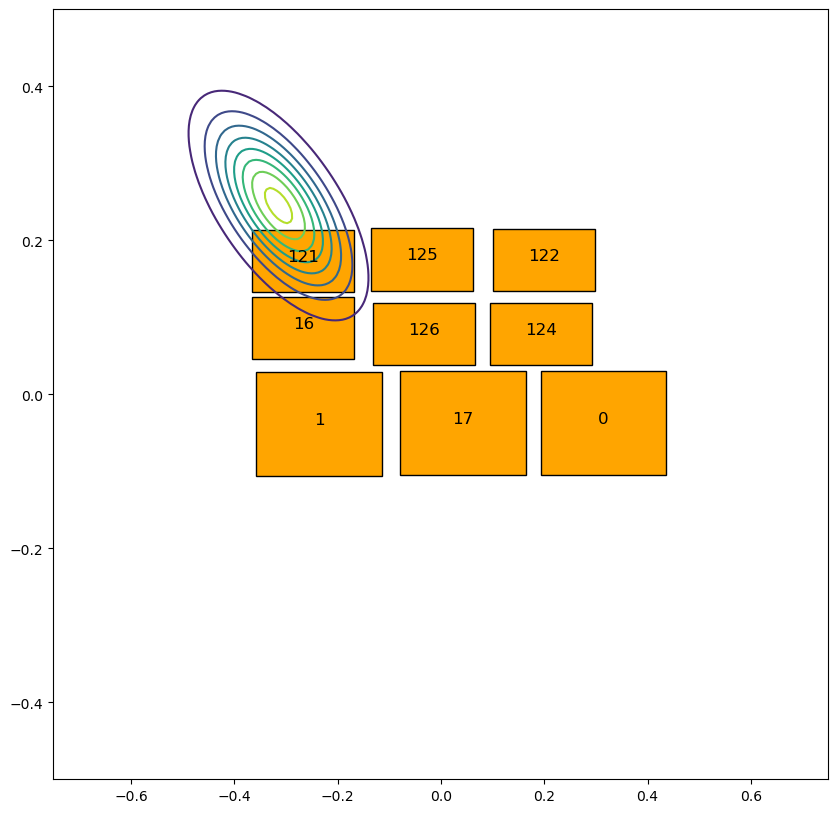

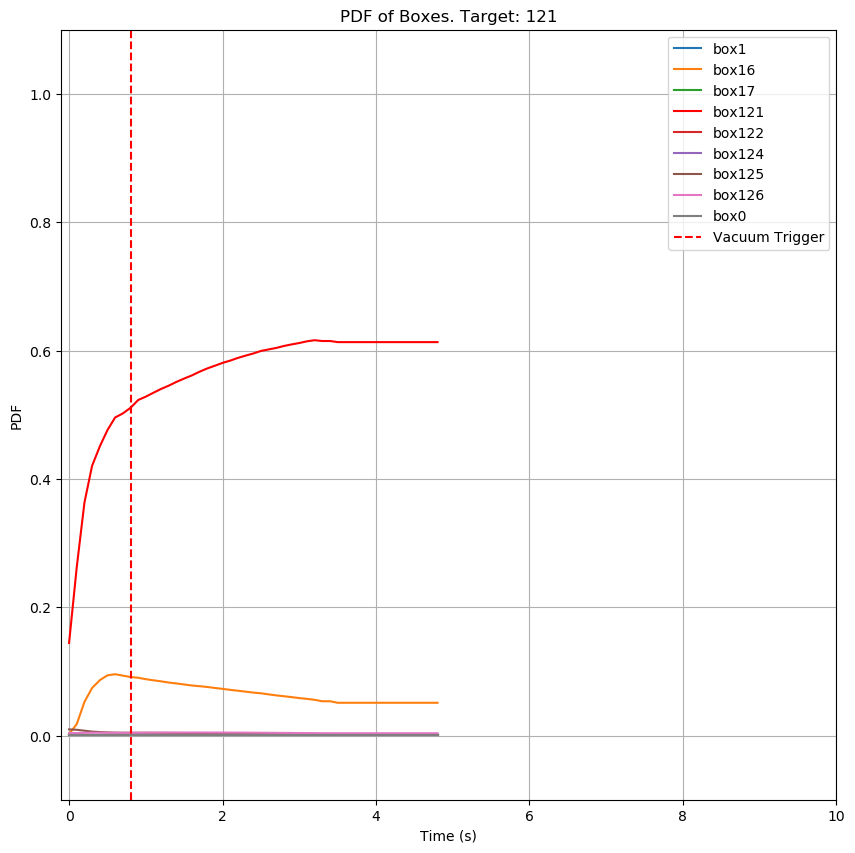

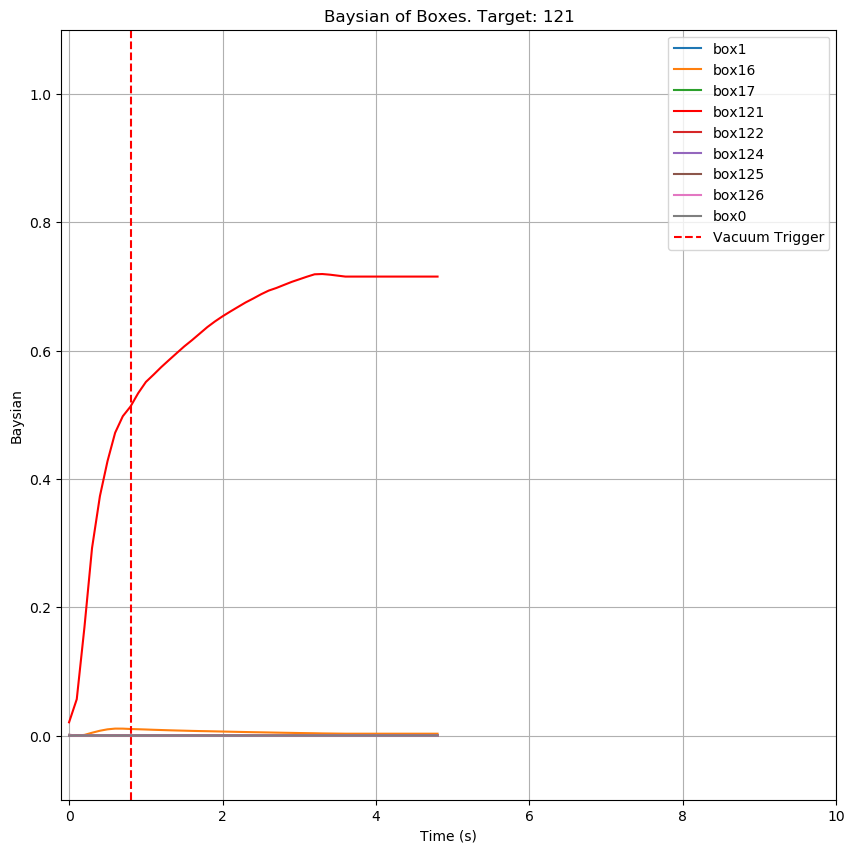

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 121 Success Time Rate: 0.6247989352916629


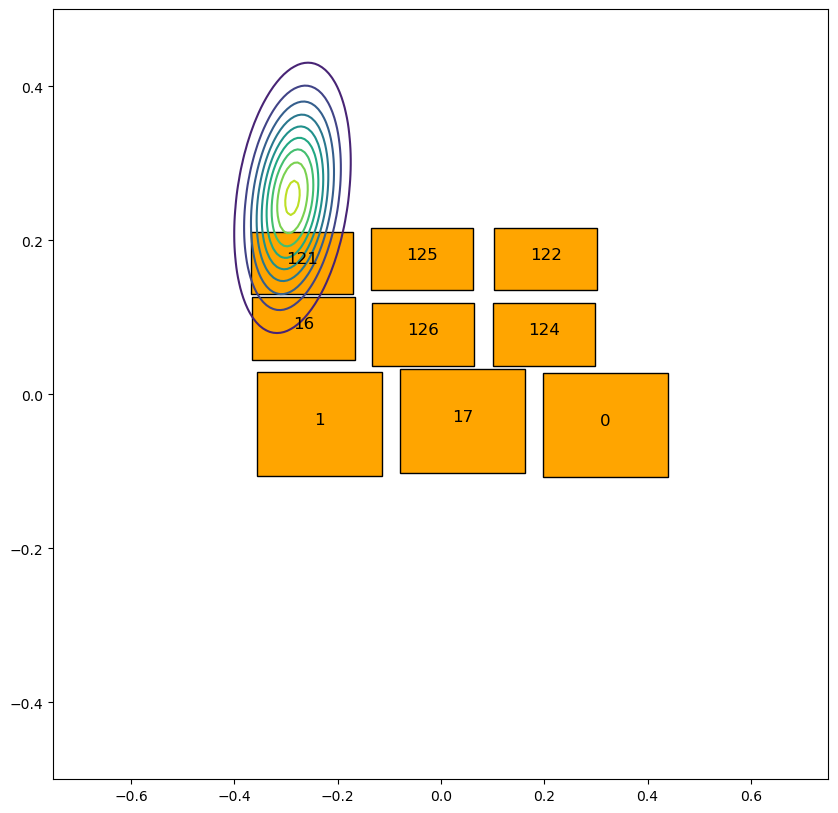

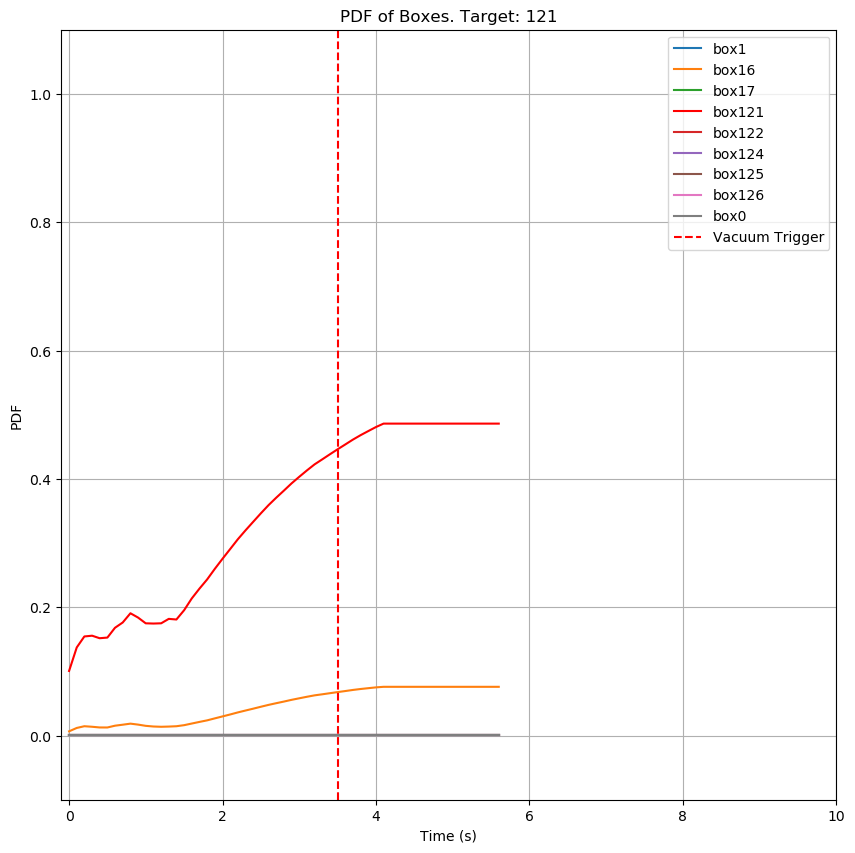

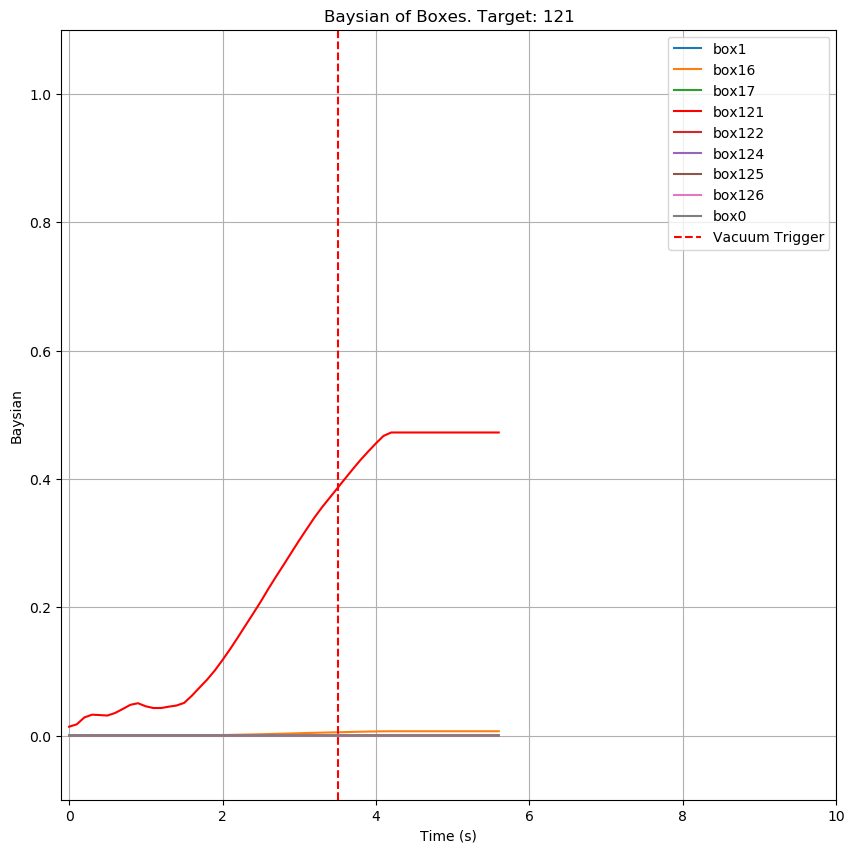

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 121 Success Time Rate: 0.14992457117961652


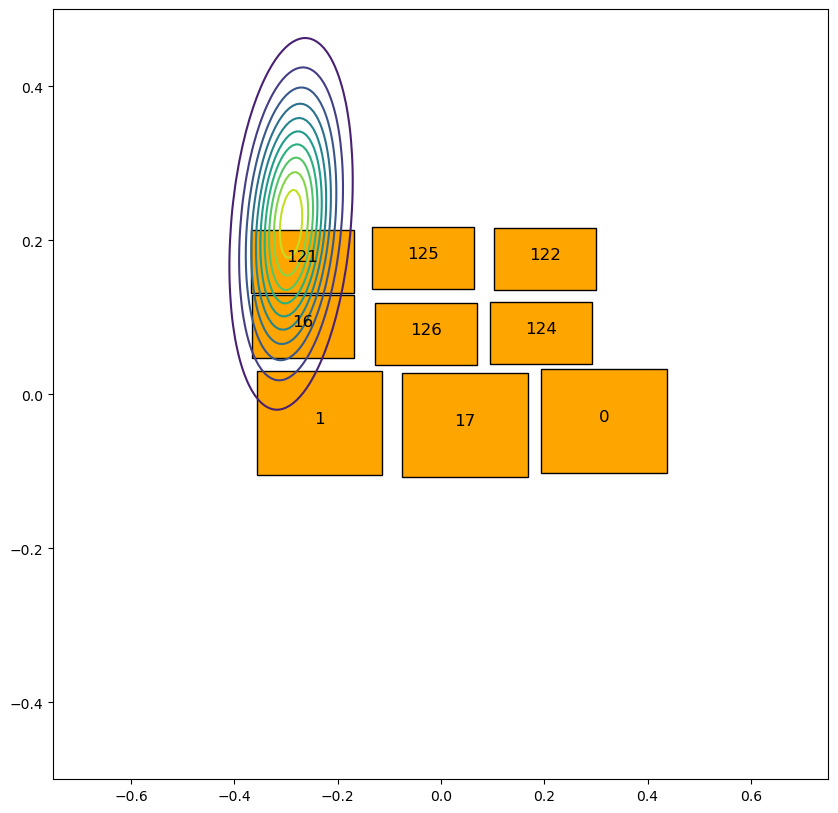

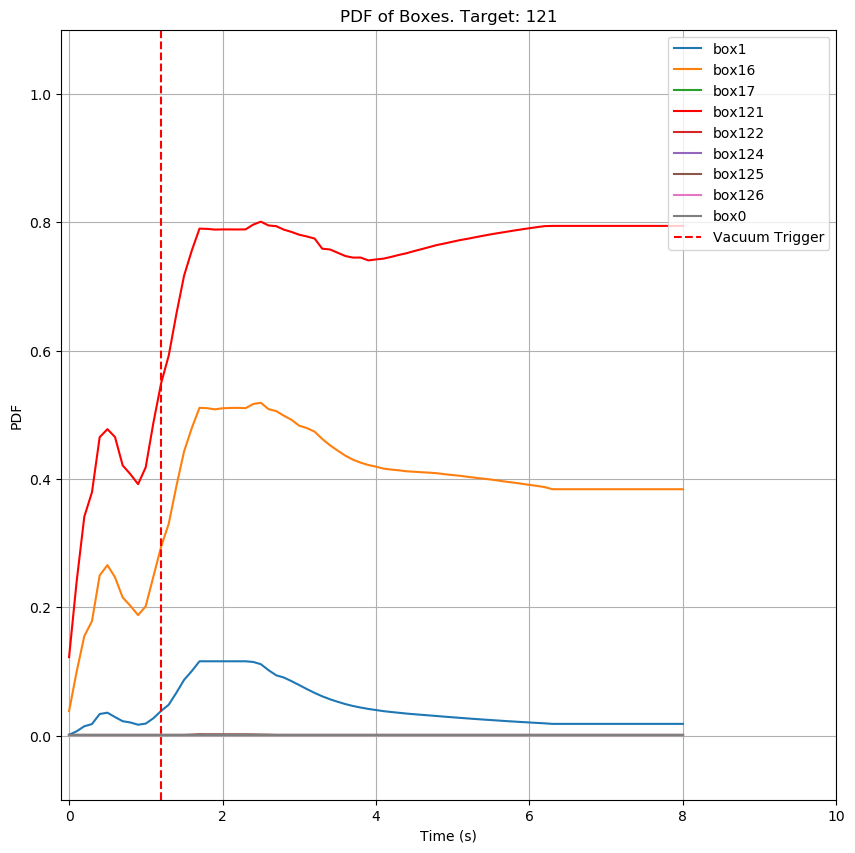

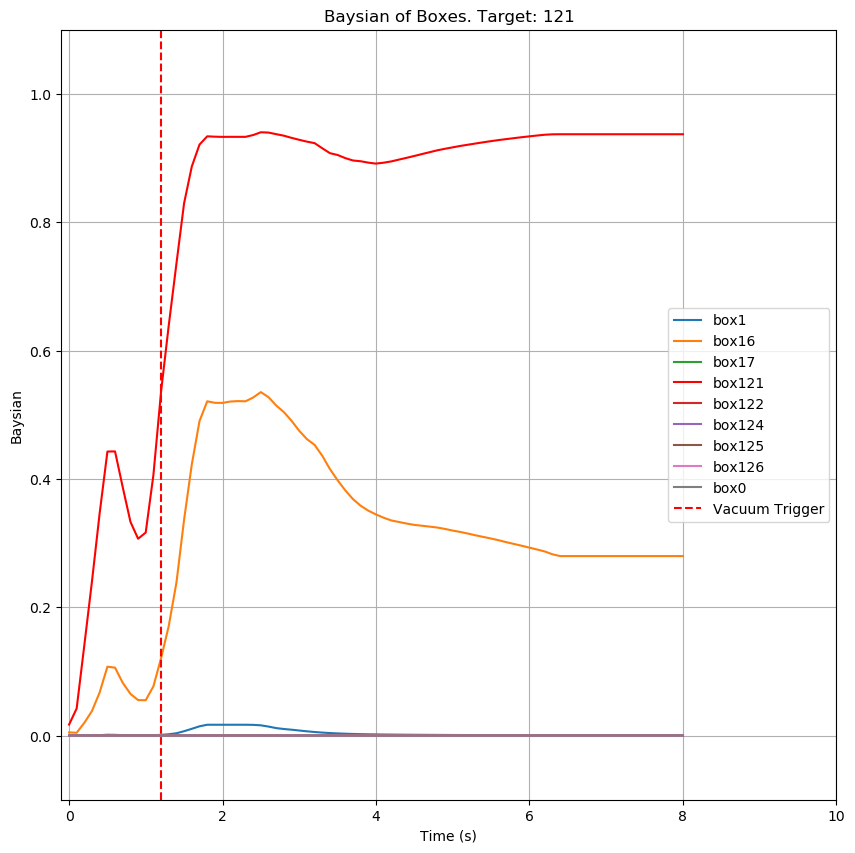

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 122 Success Time Rate: 0.5384442536932268


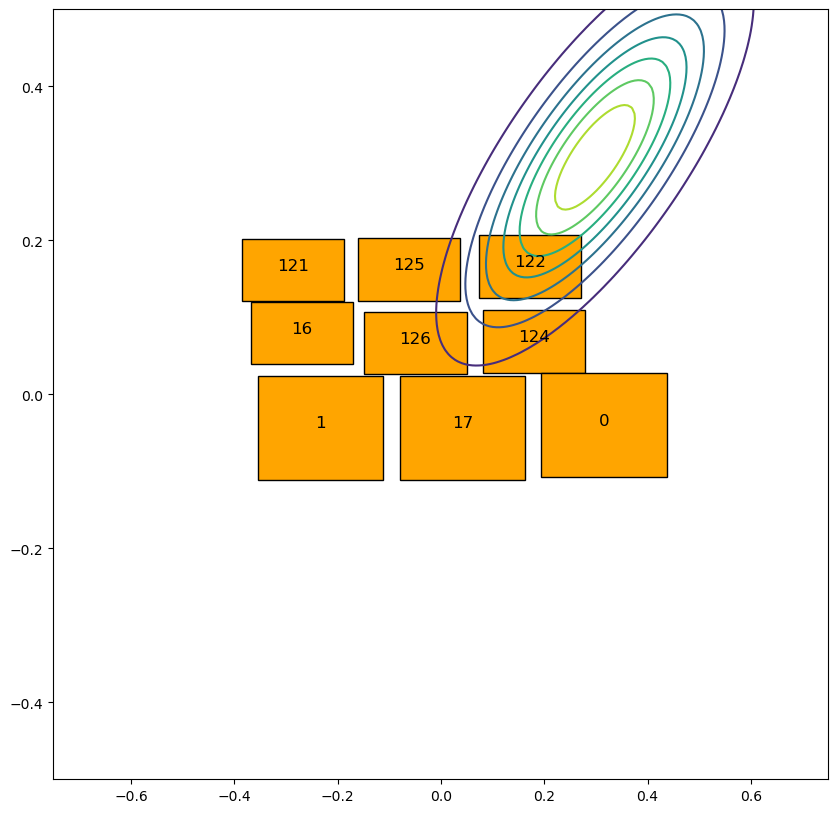

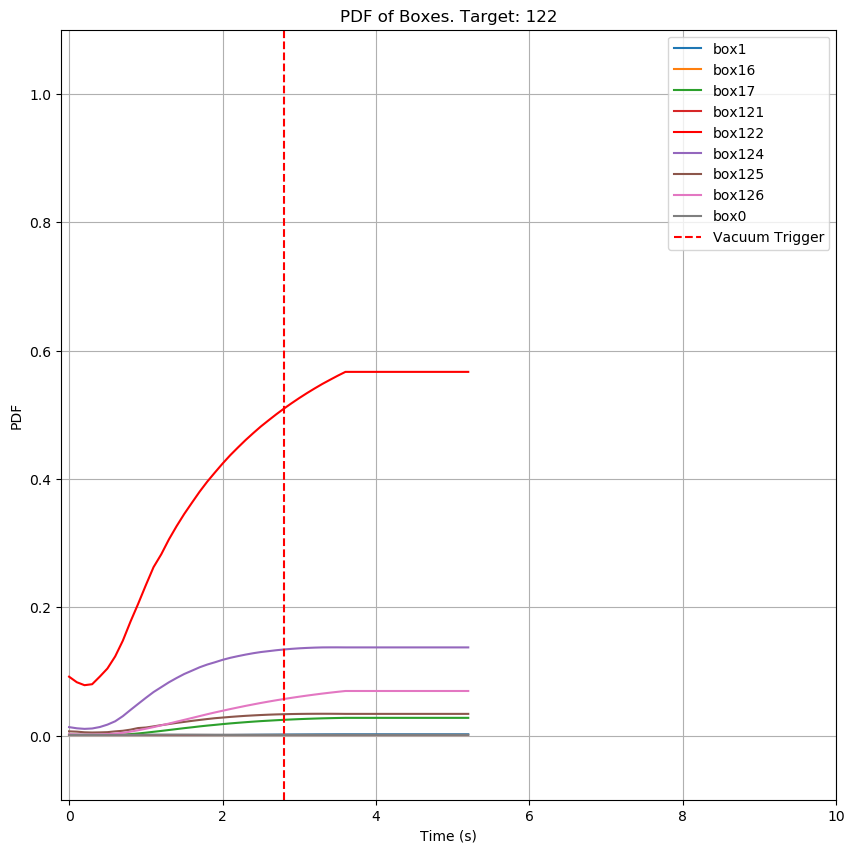

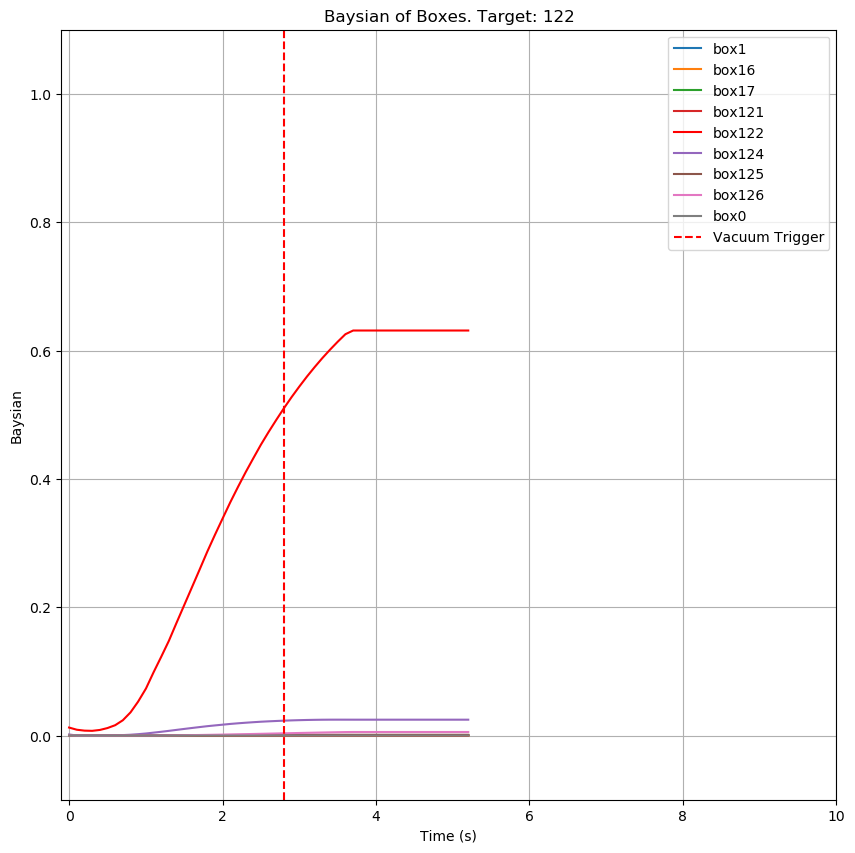

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 122 Success Time Rate: 0.6234221014628052


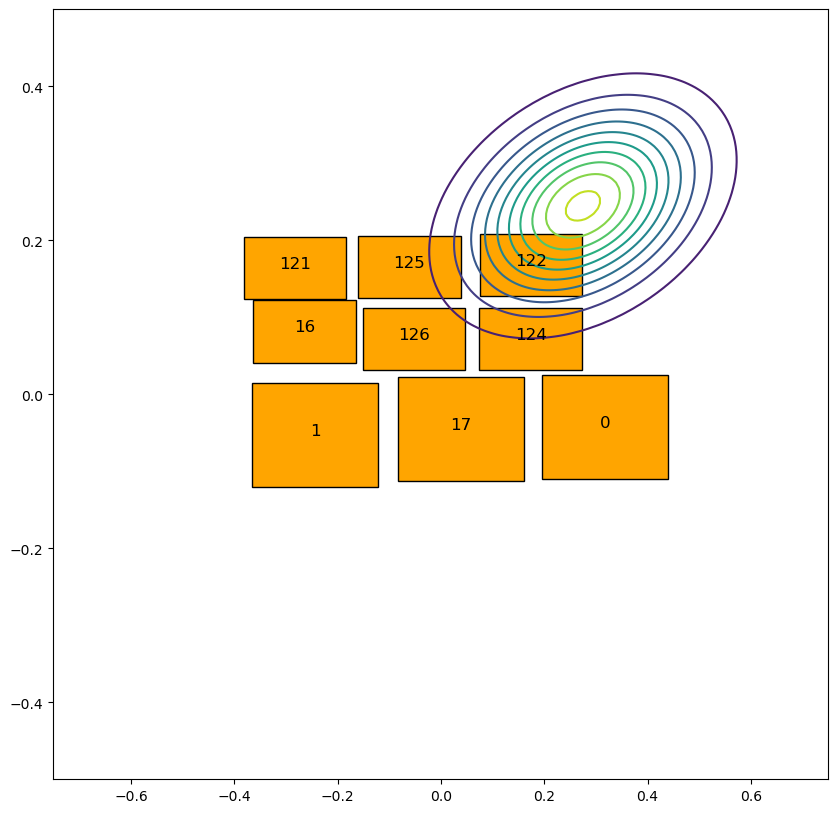

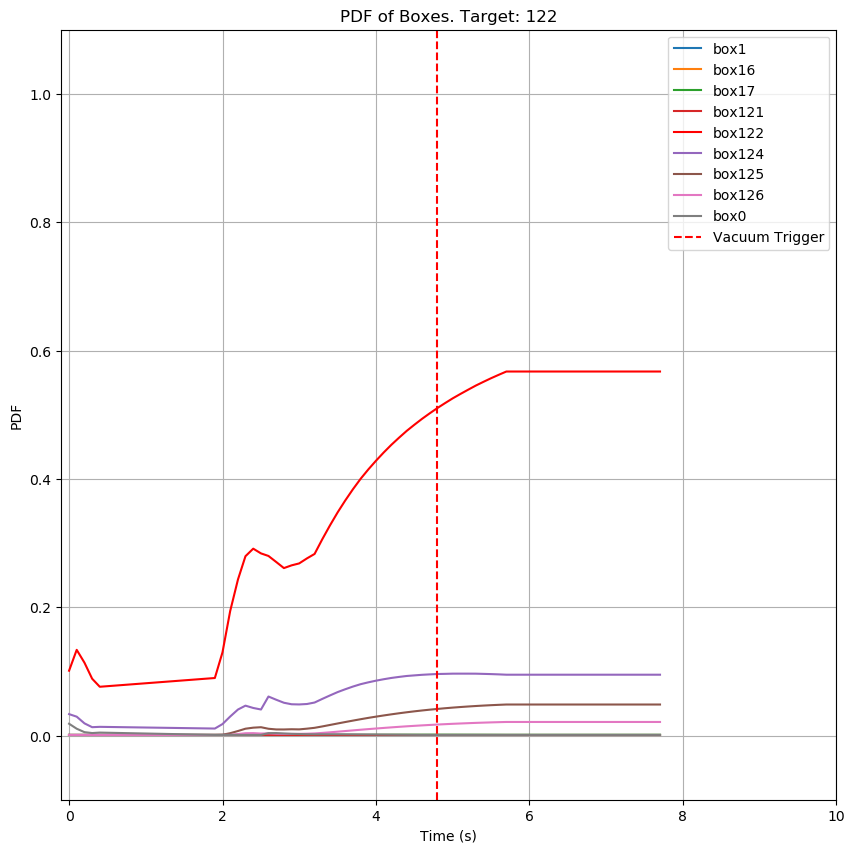

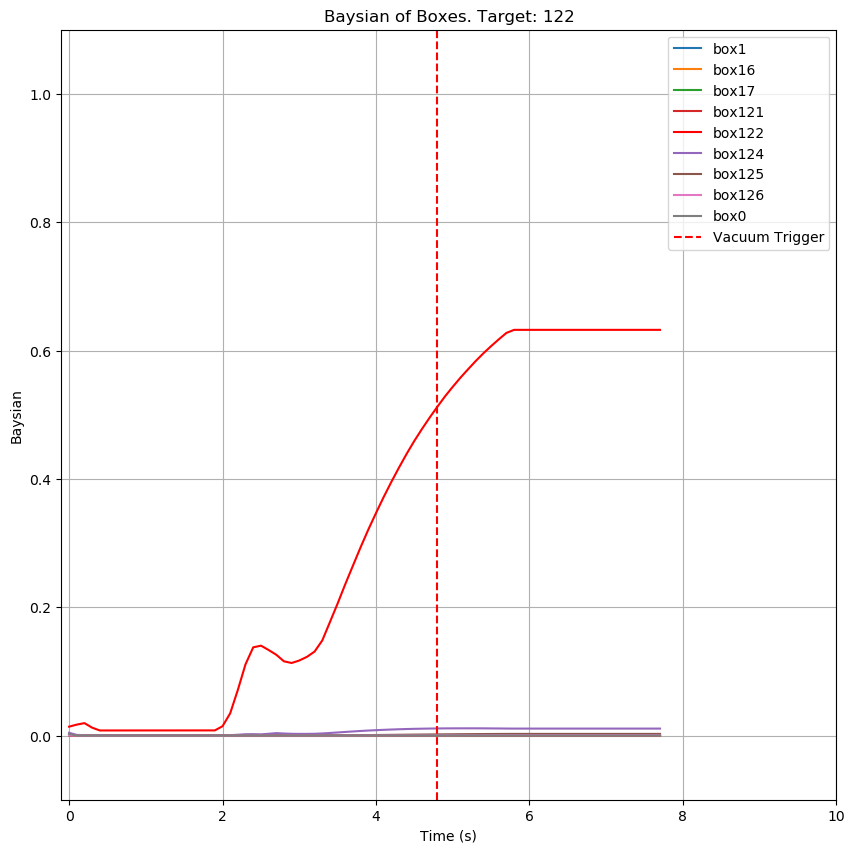

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 122 Success Time Rate: 0.4941873593291419


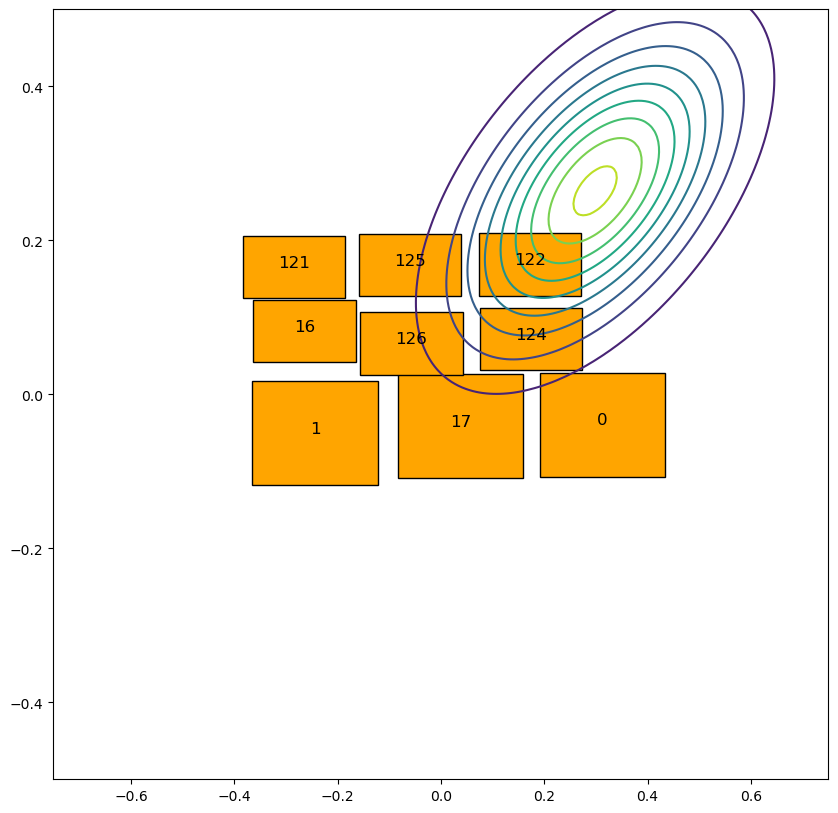

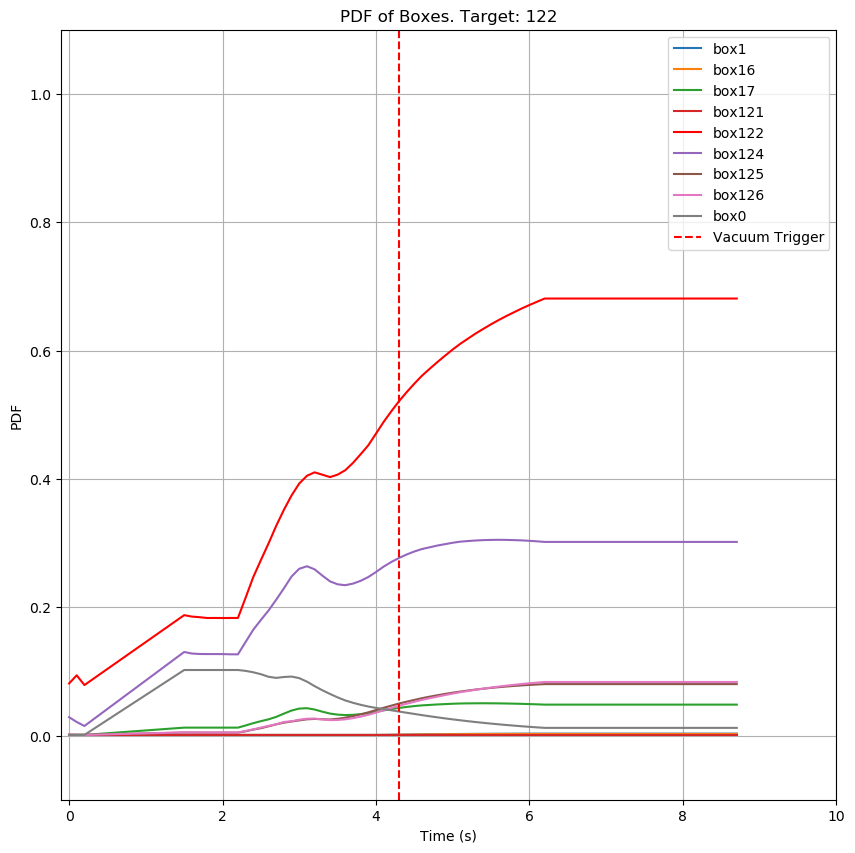

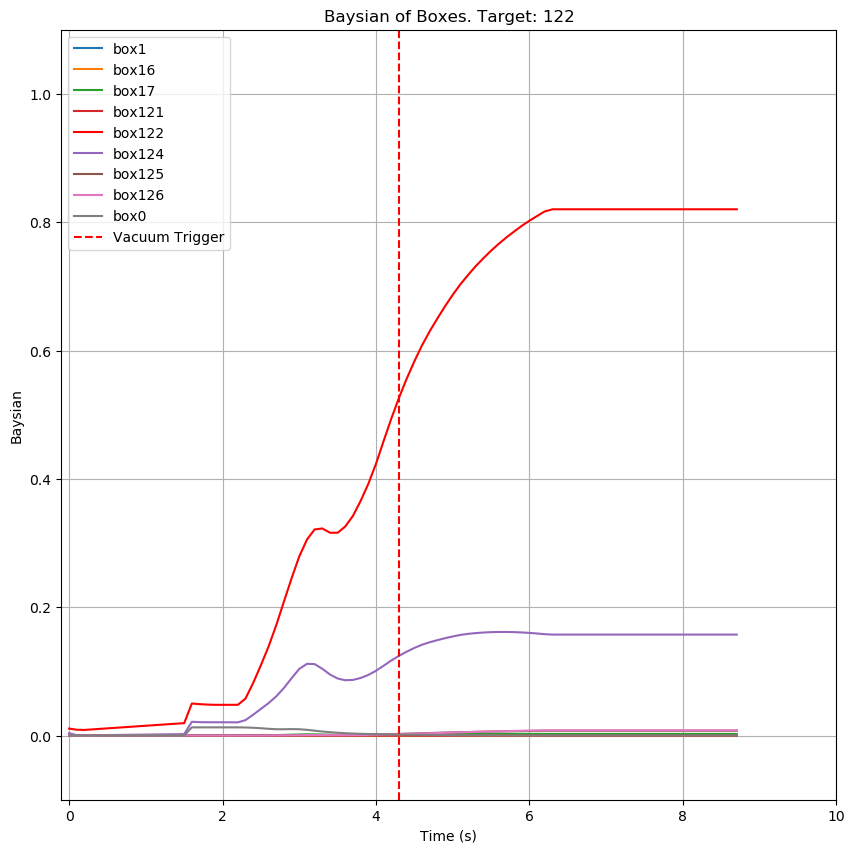

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 122 Success Time Rate: 0.3775292276776385


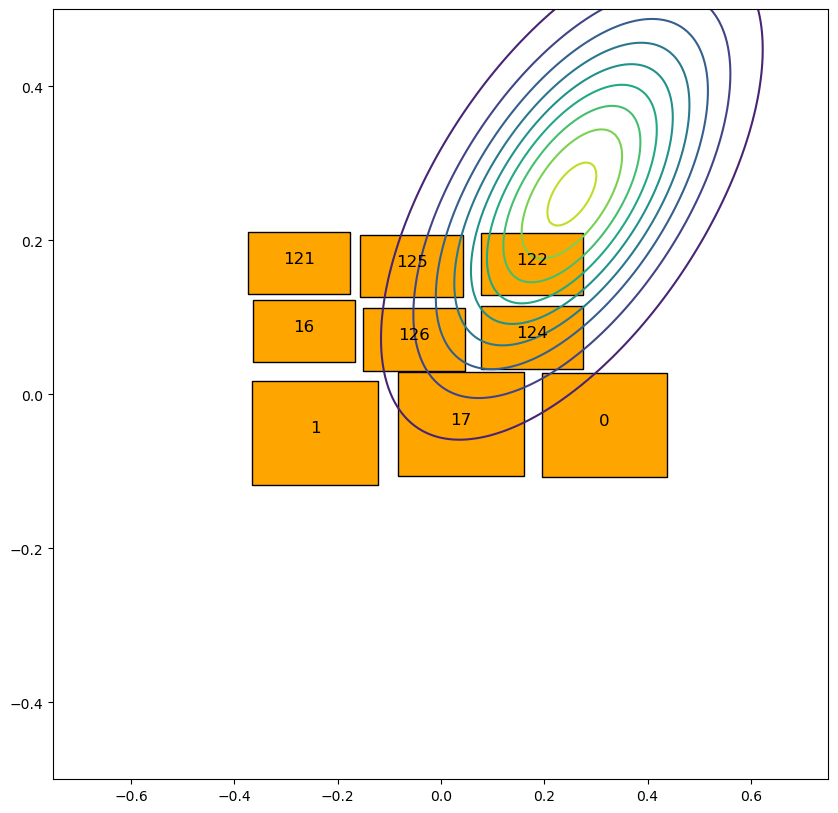

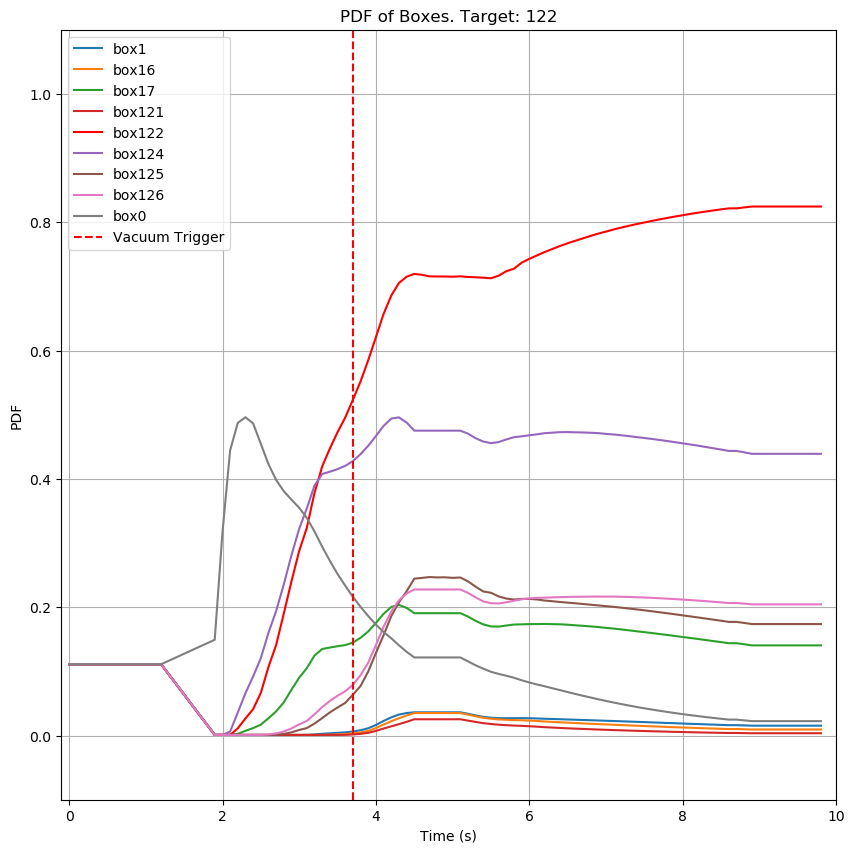

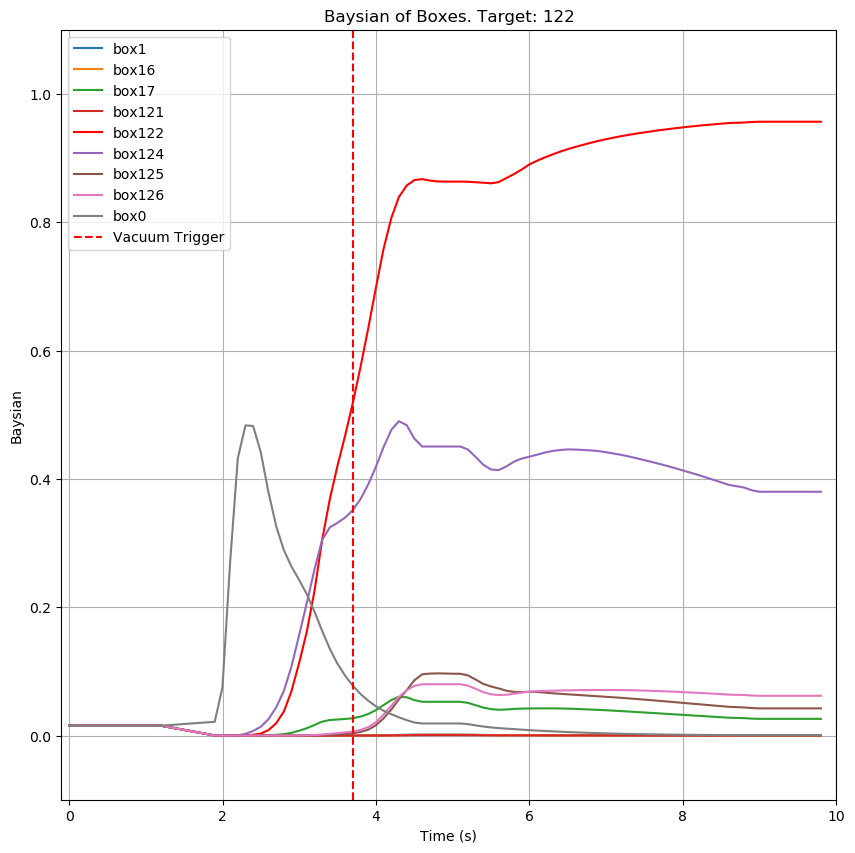

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 124 Success Time Rate: 0.04779534604216476


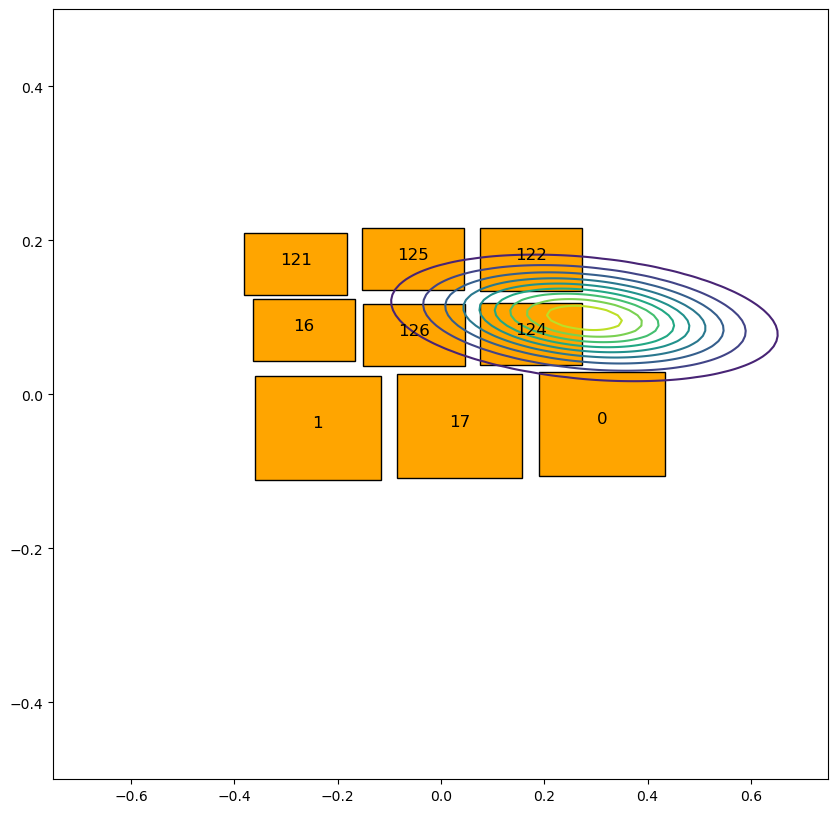

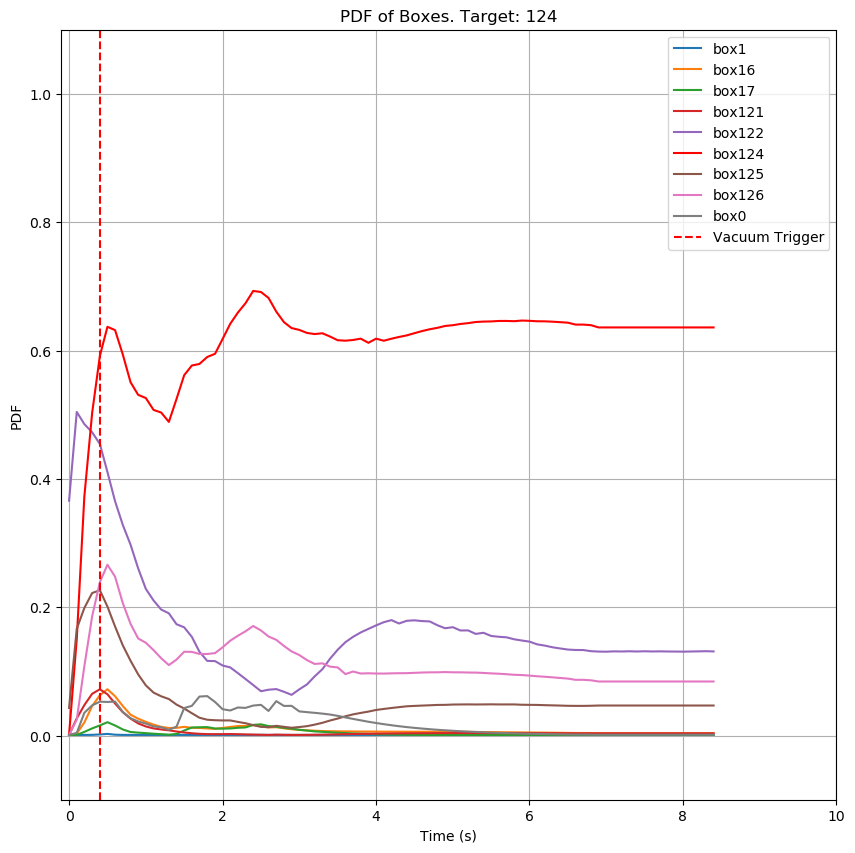

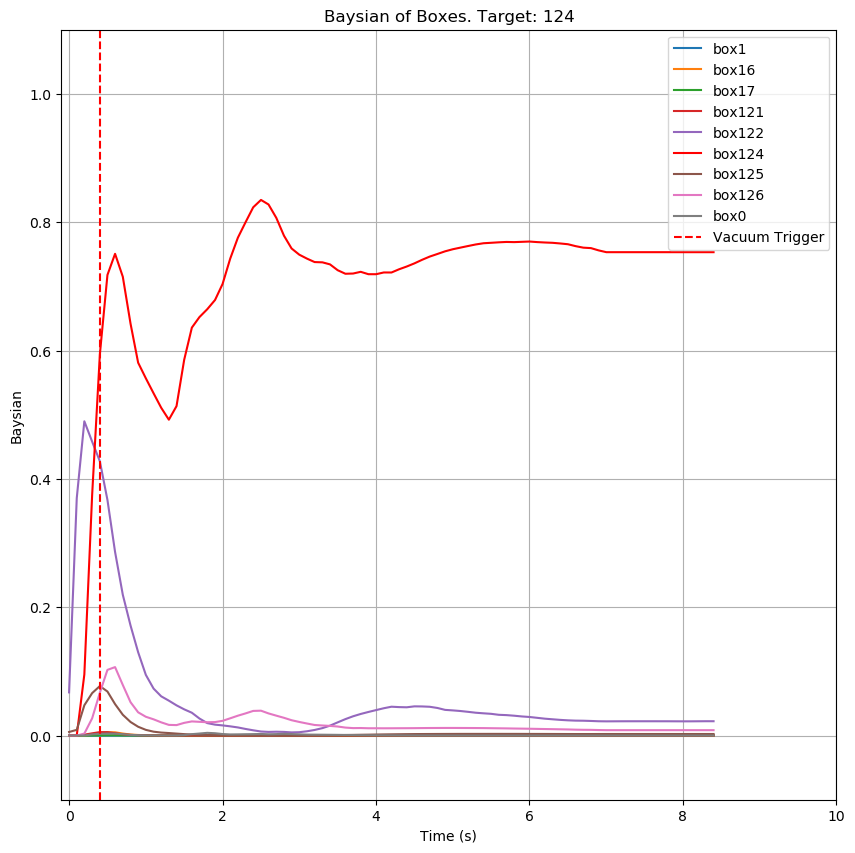

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 124 Success Time Rate: 0.3258156502220687


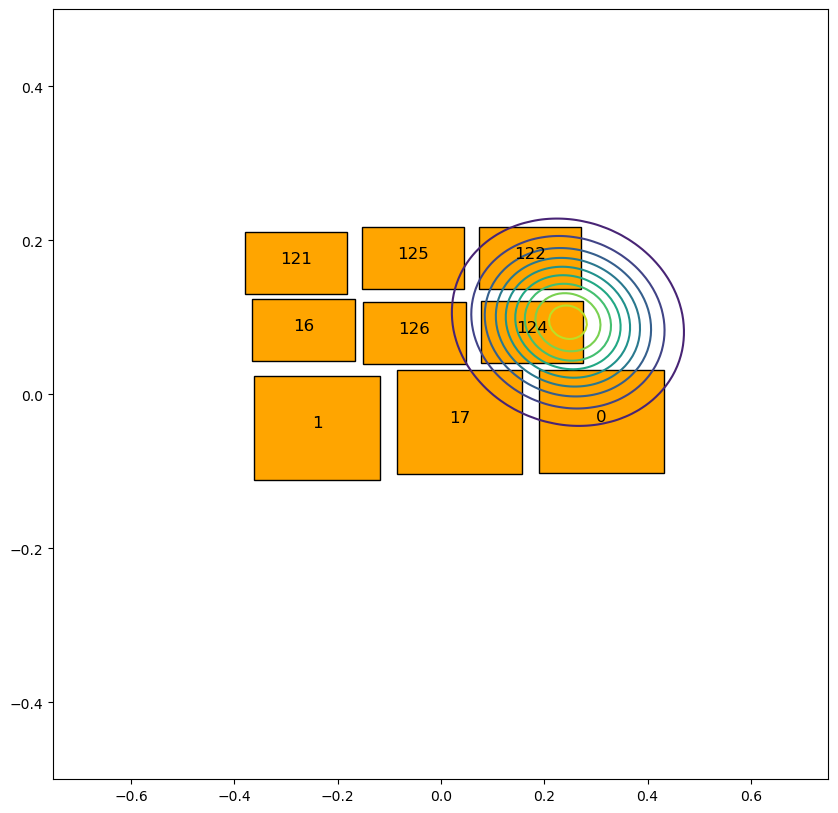

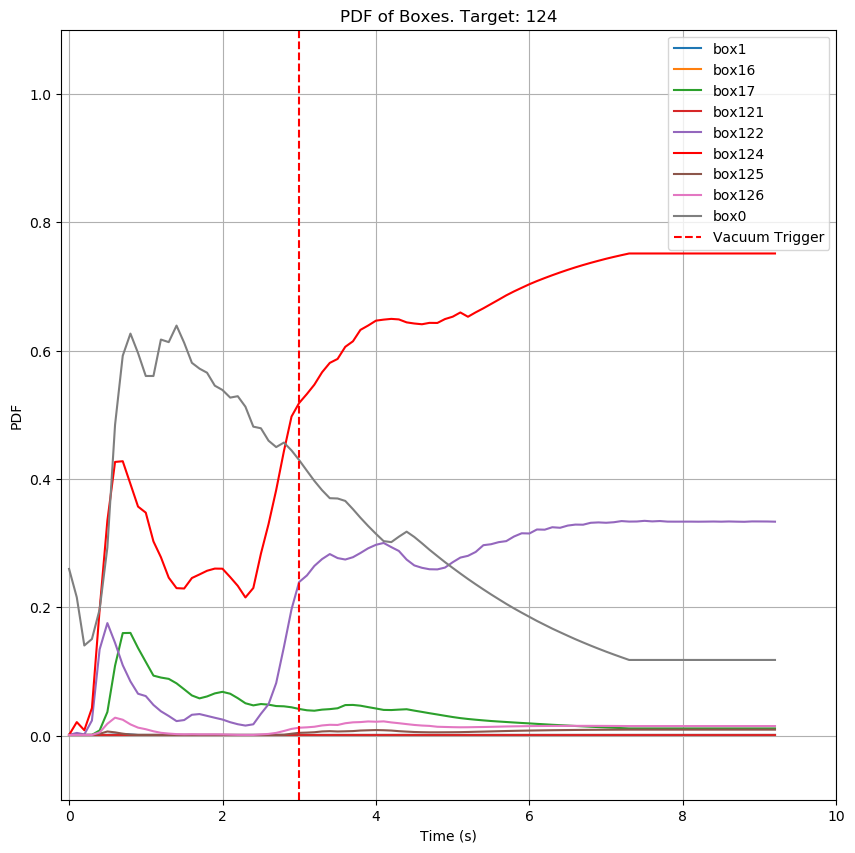

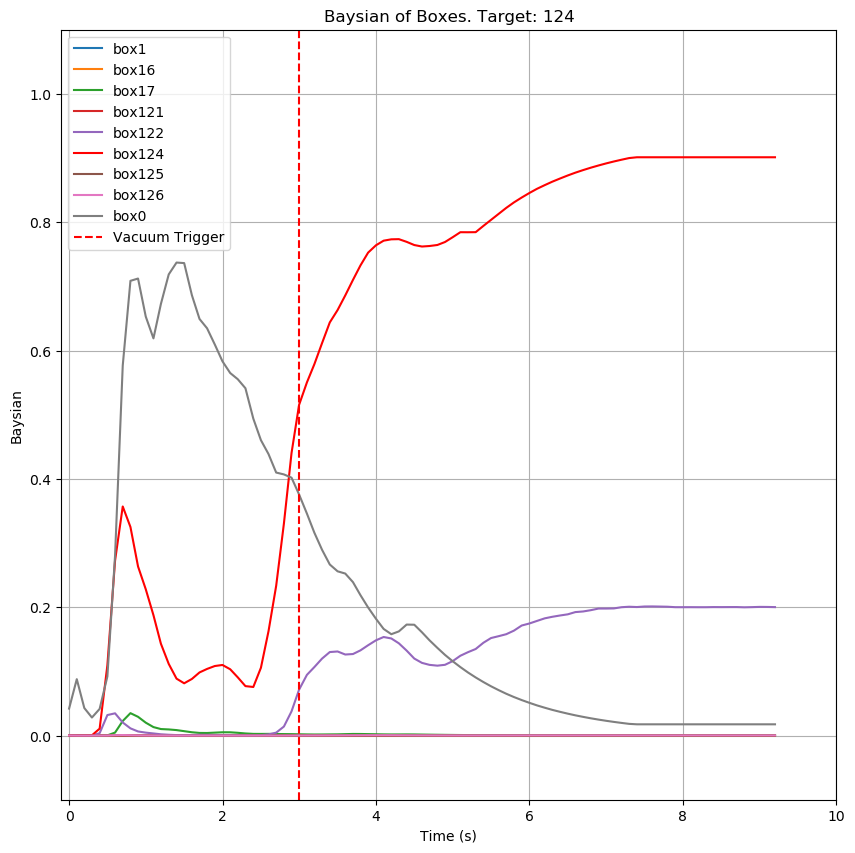

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 124 Success Time Rate: 0.014104253278901937


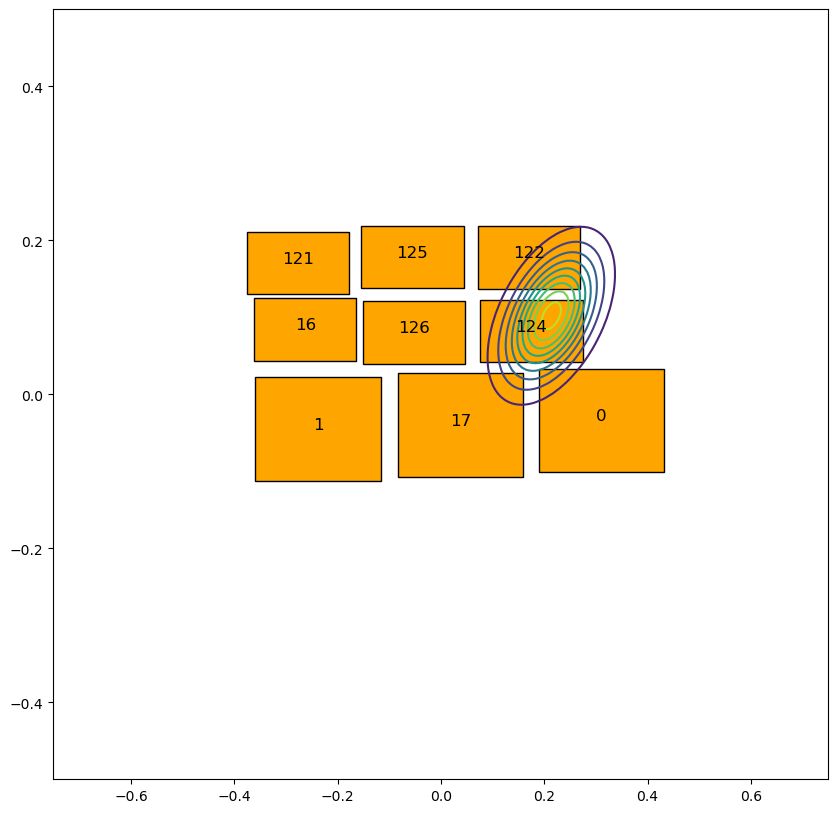

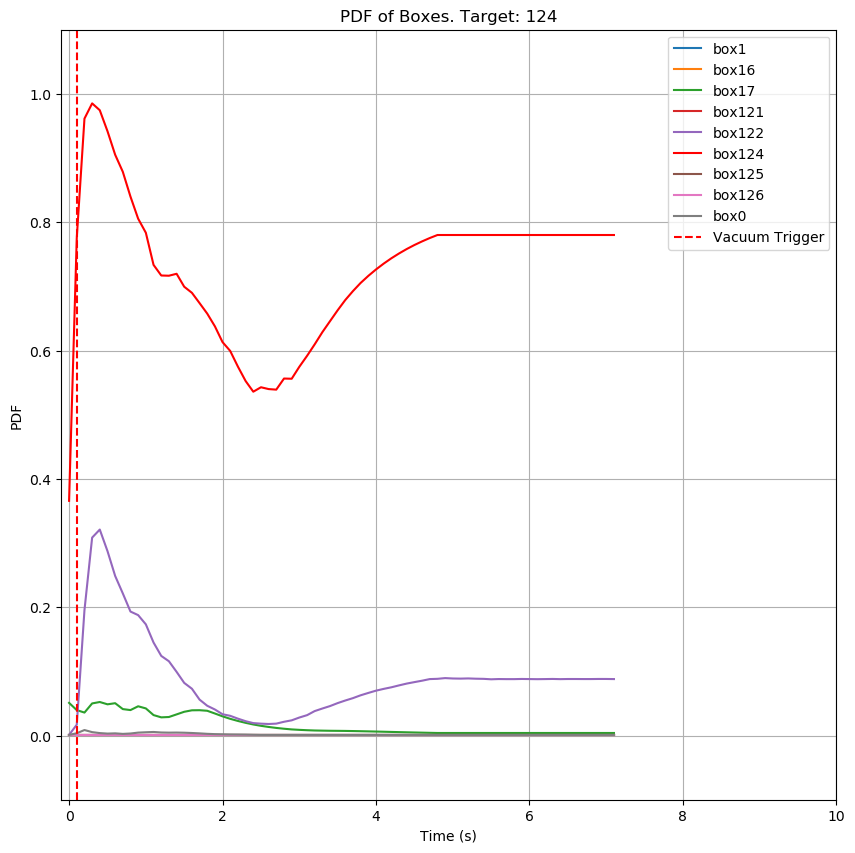

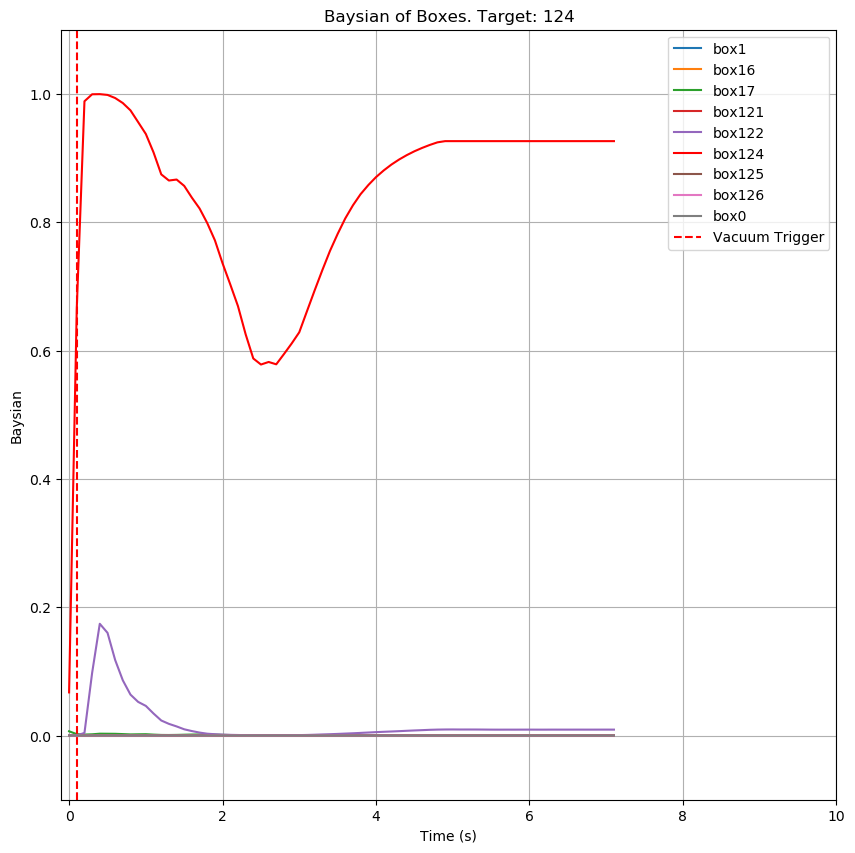

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 124 Success Time Rate: 0.13025614368983437


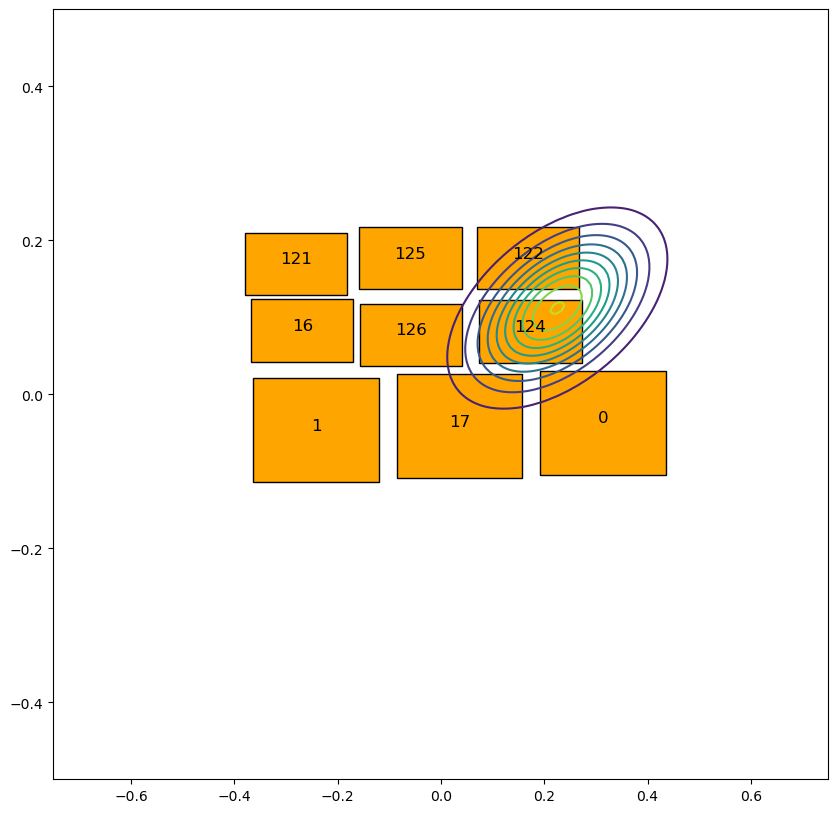

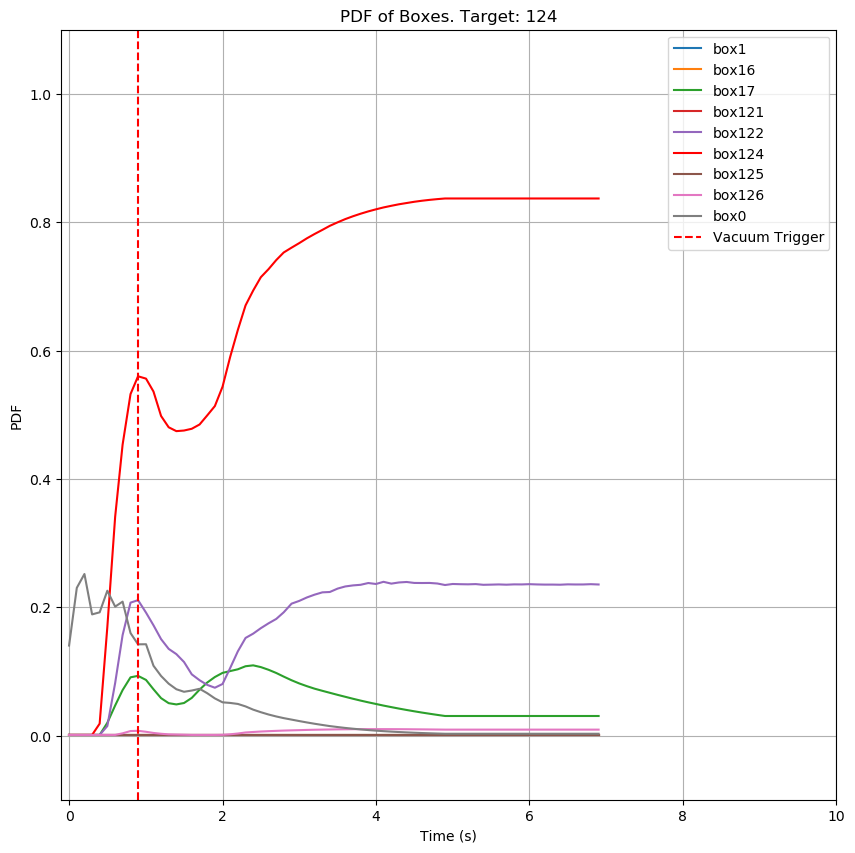

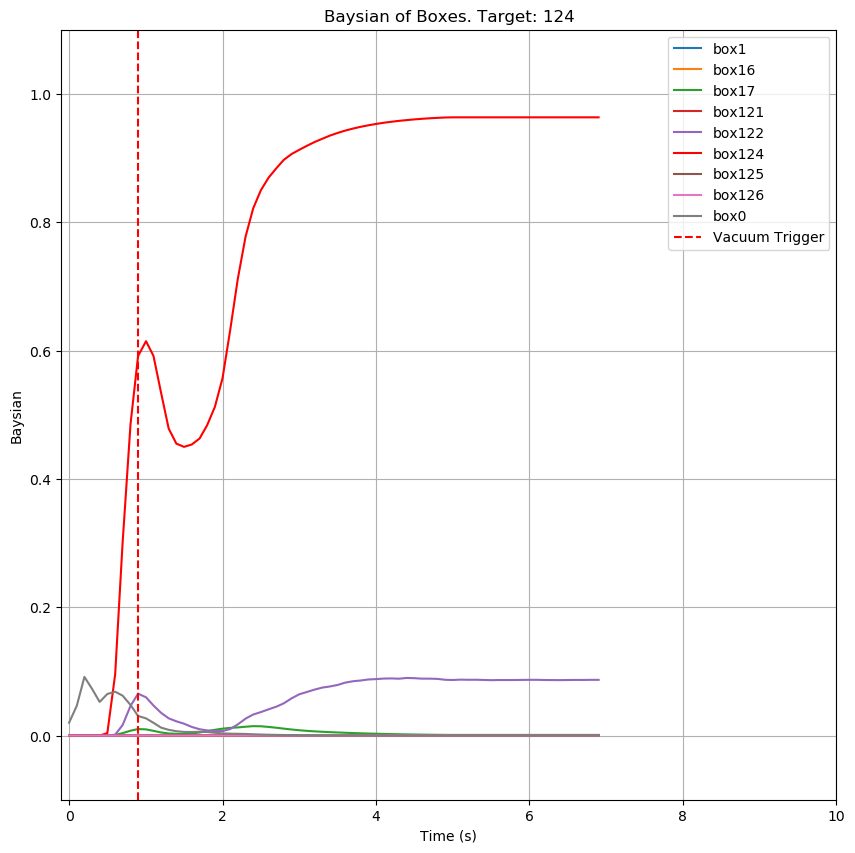

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 125 Success Time Rate: 0.651445494771108


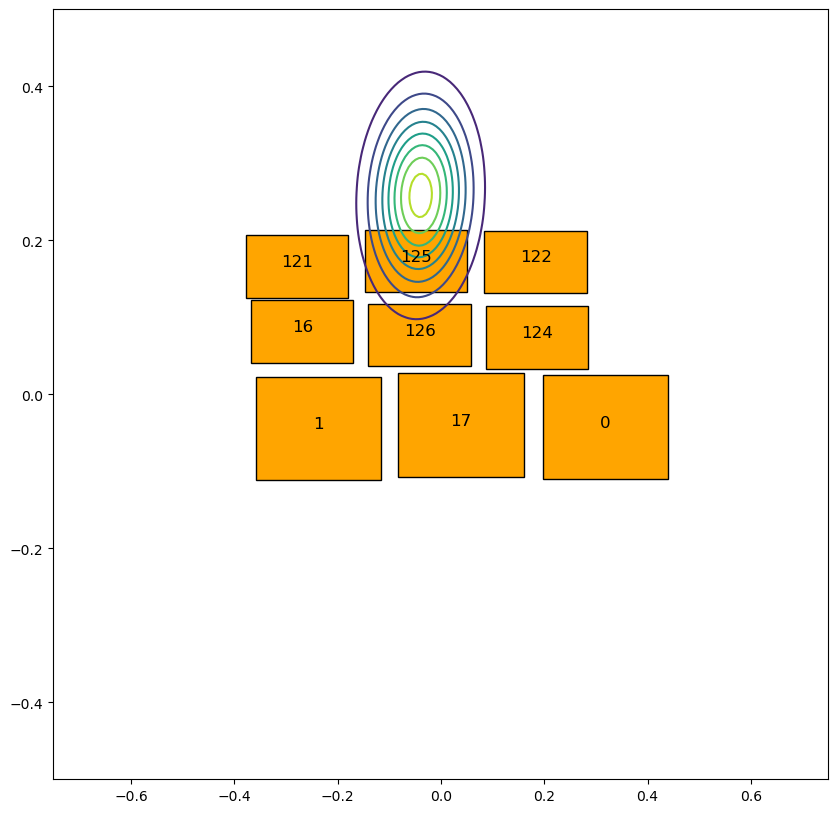

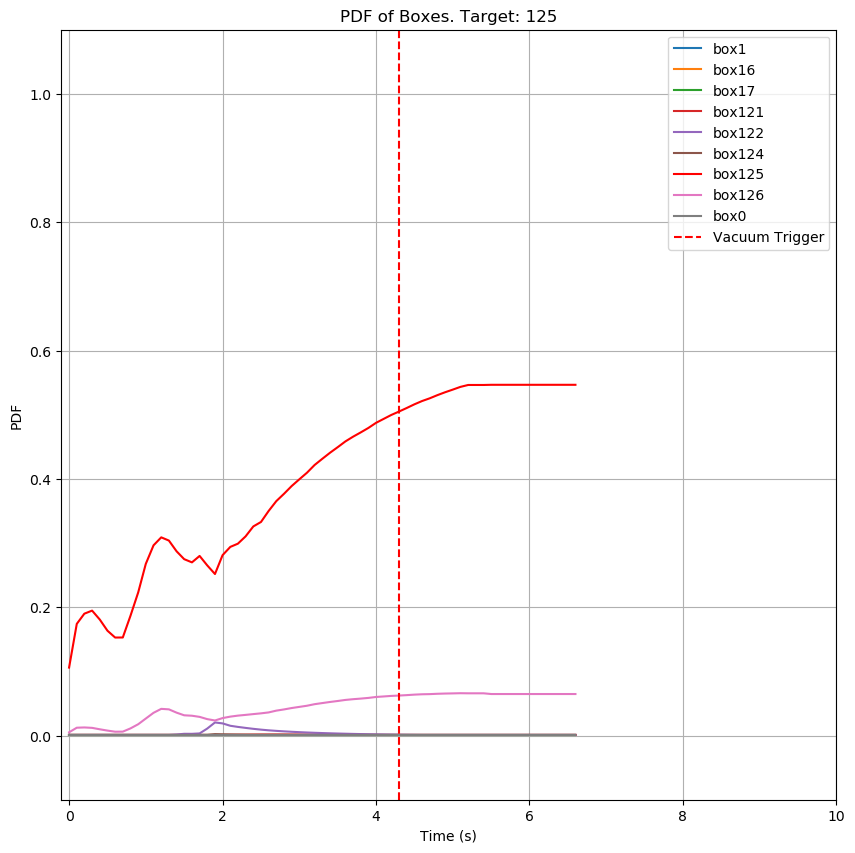

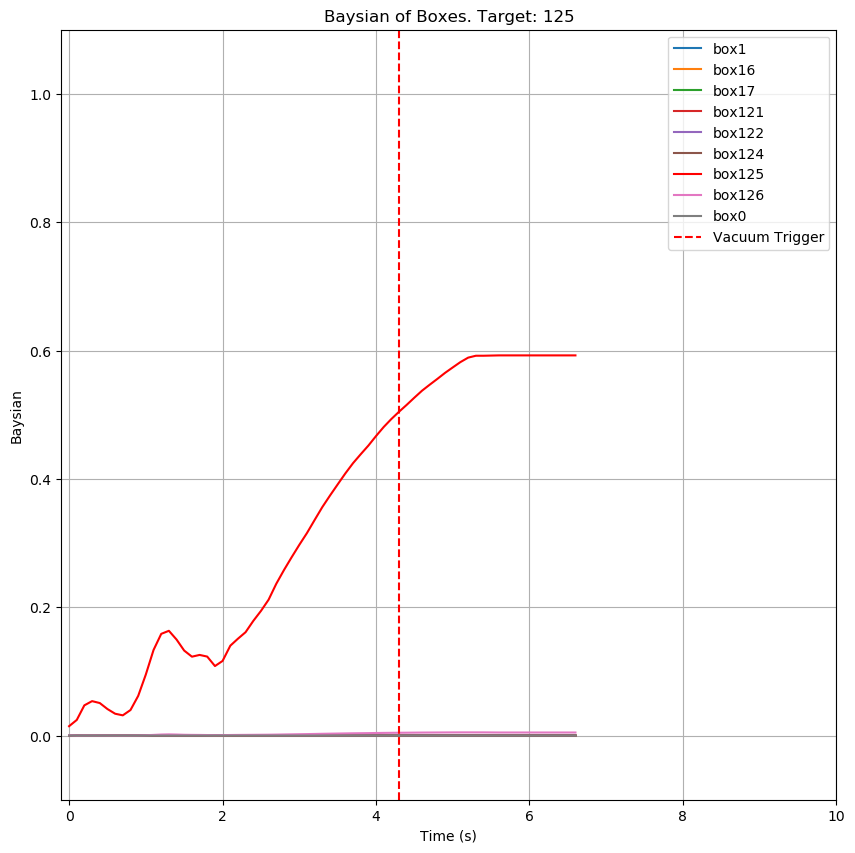

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 125 Success Time Rate: 0.5076385810512309


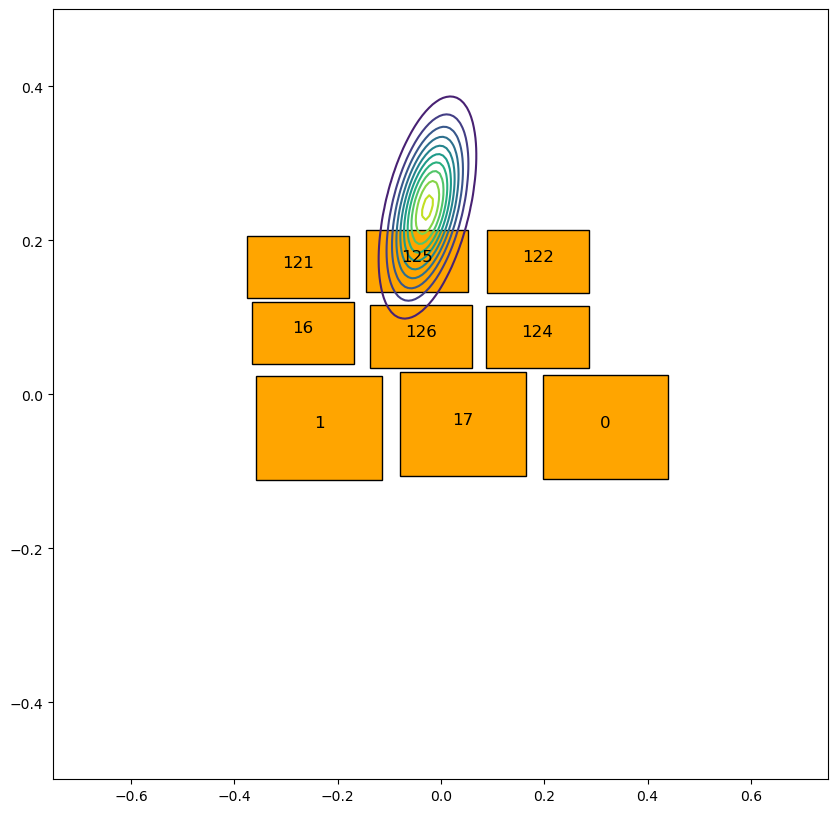

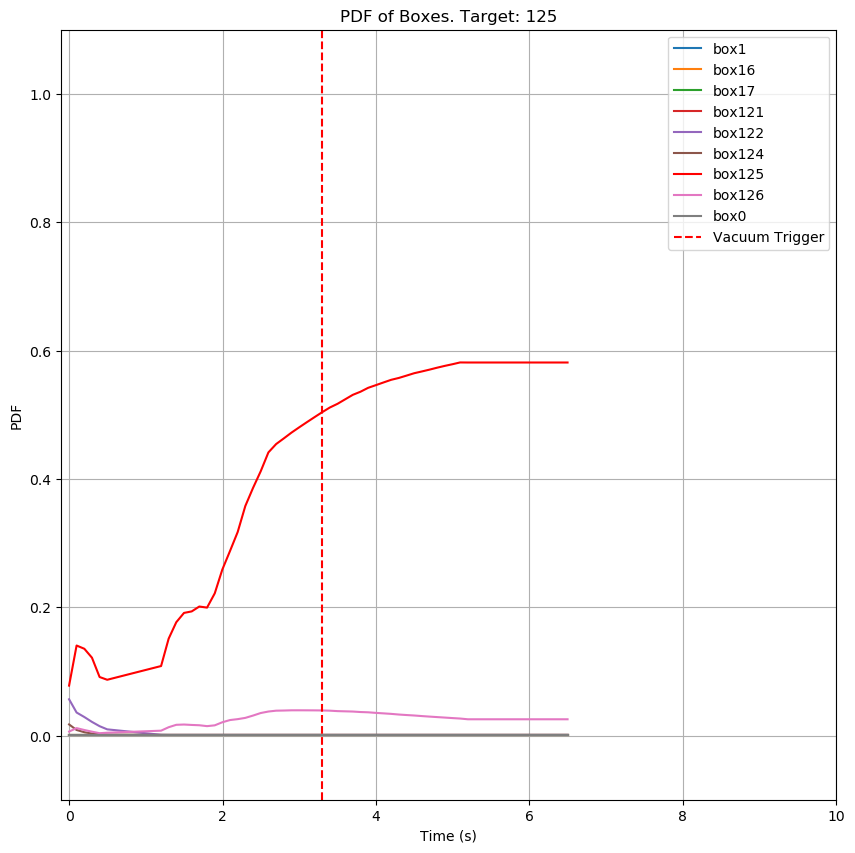

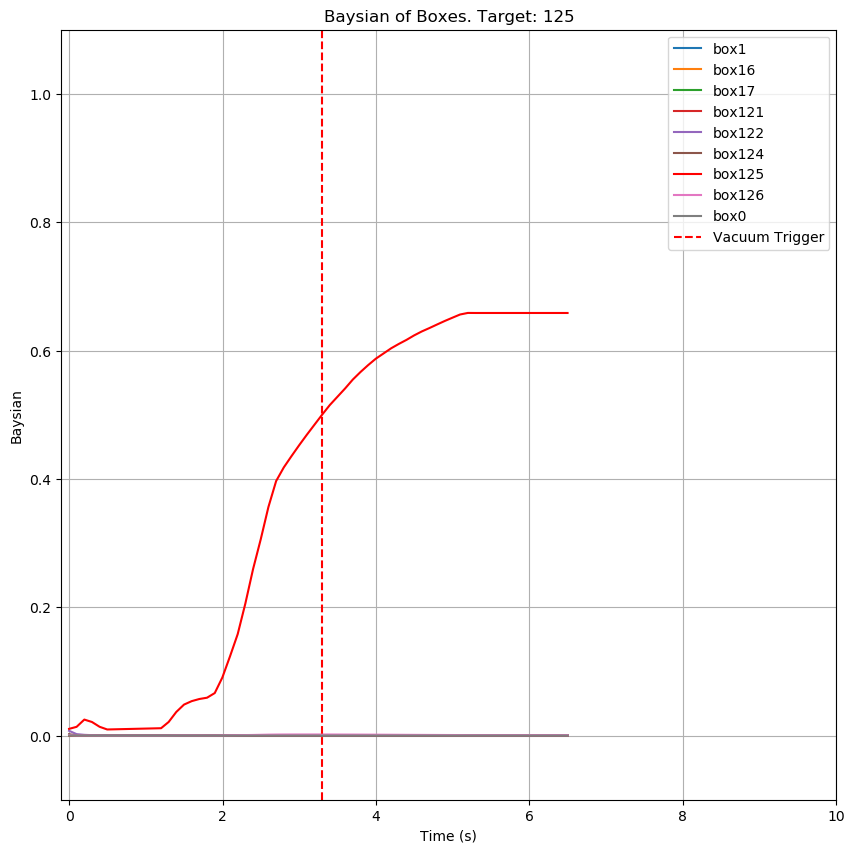

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 125 Success Time Rate: 0.07422328144587997


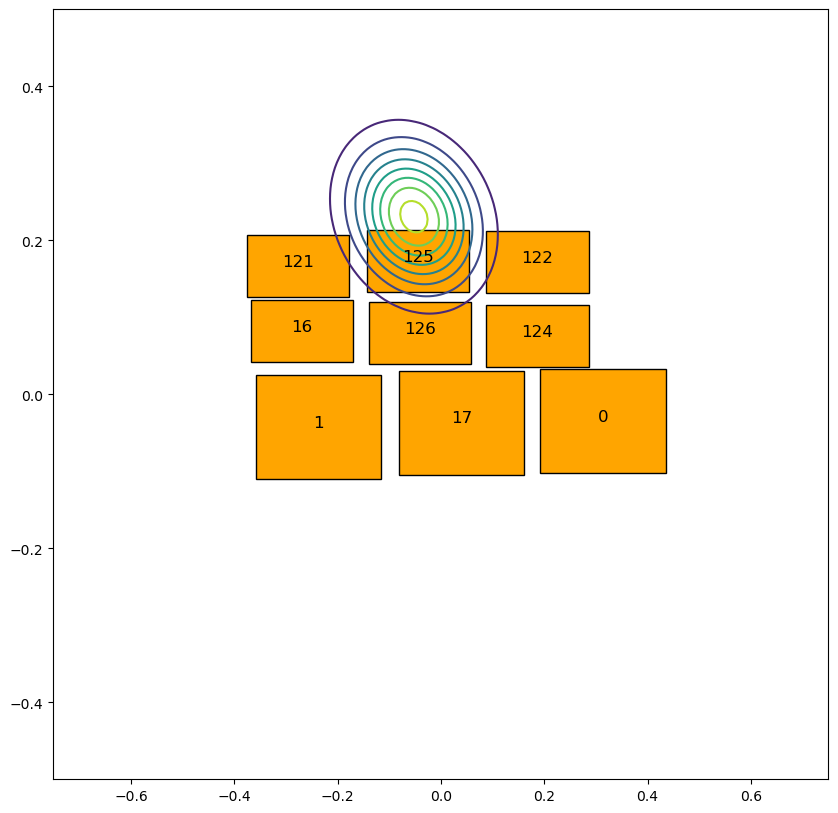

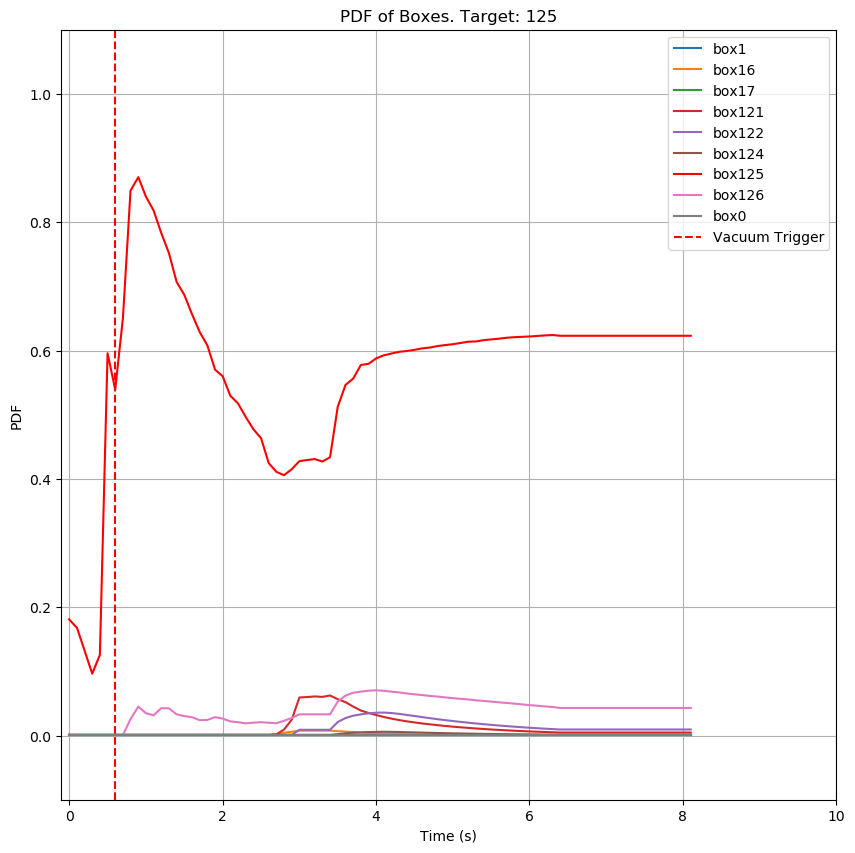

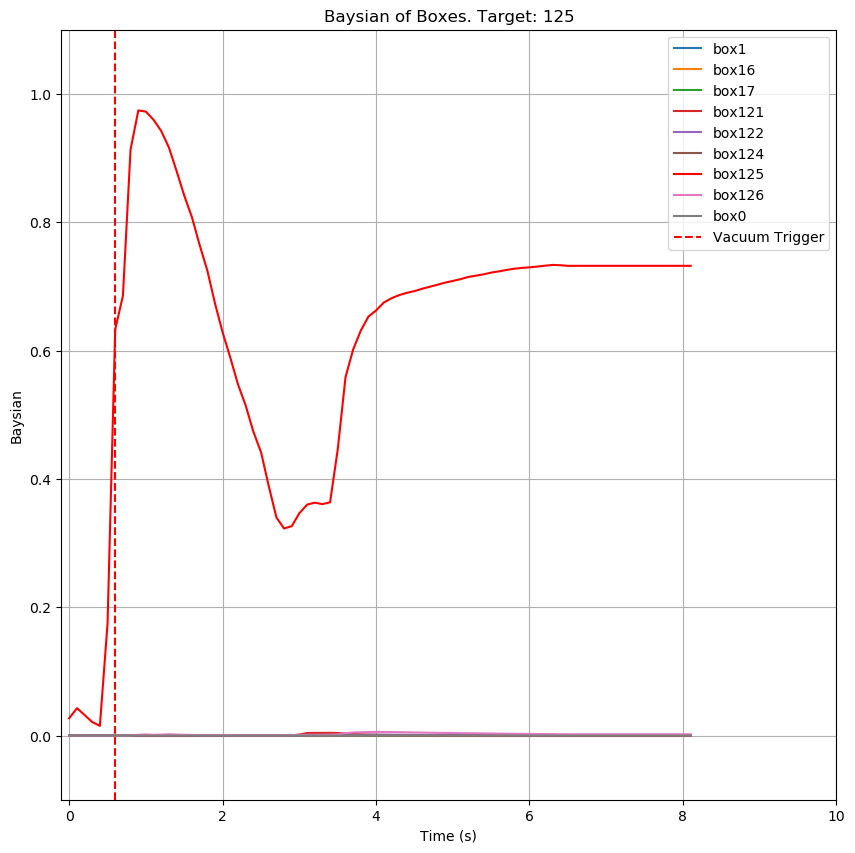

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 125 Success Time Rate: 0.8090701785664539


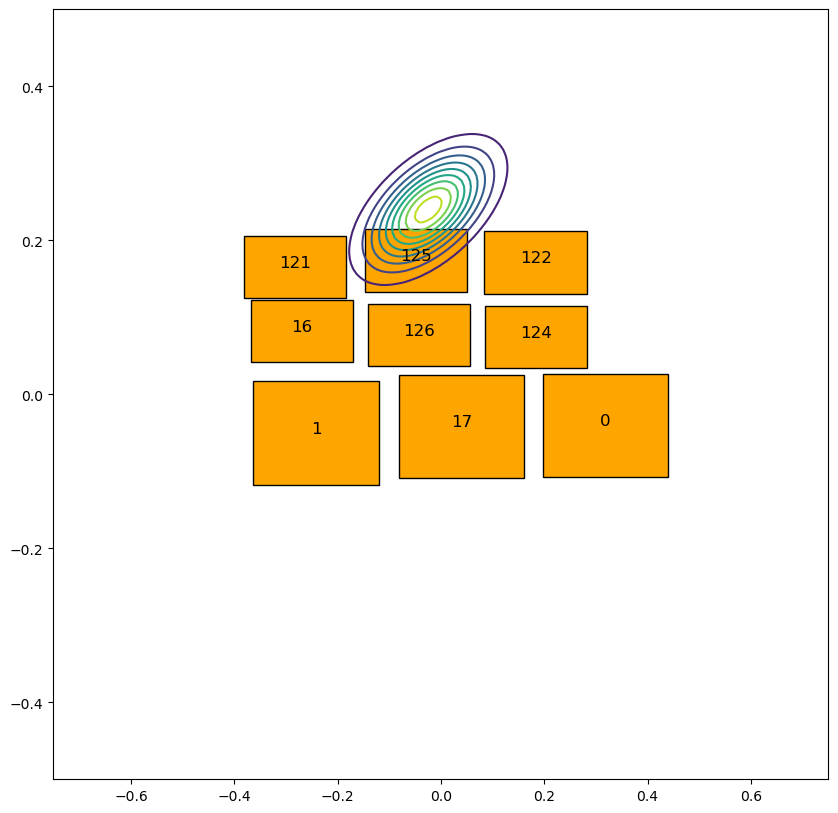

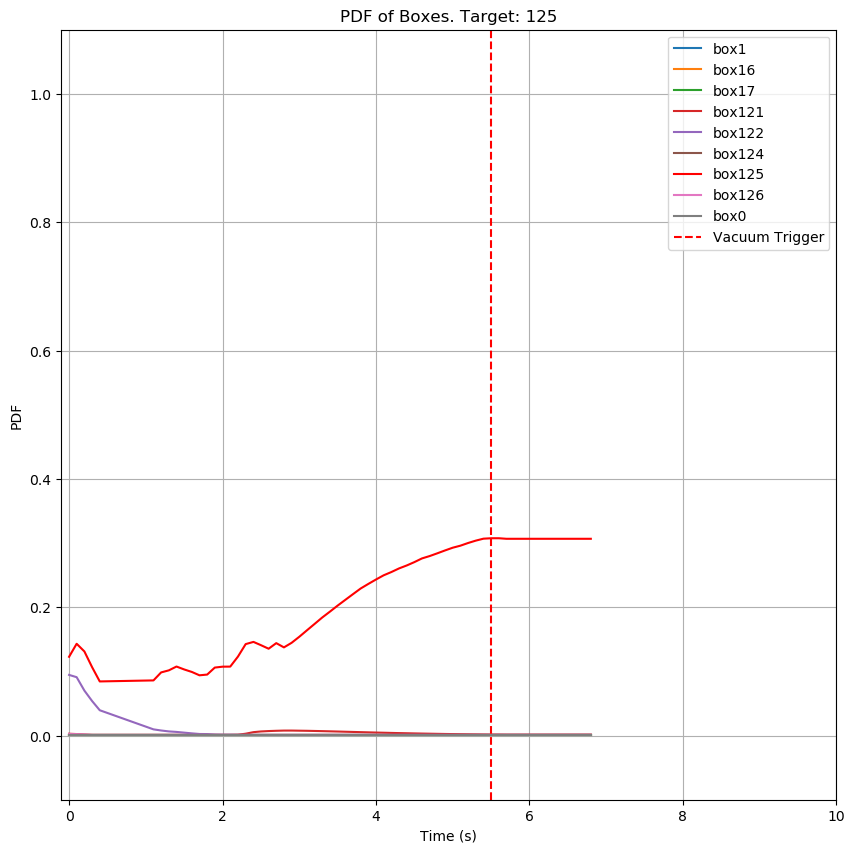

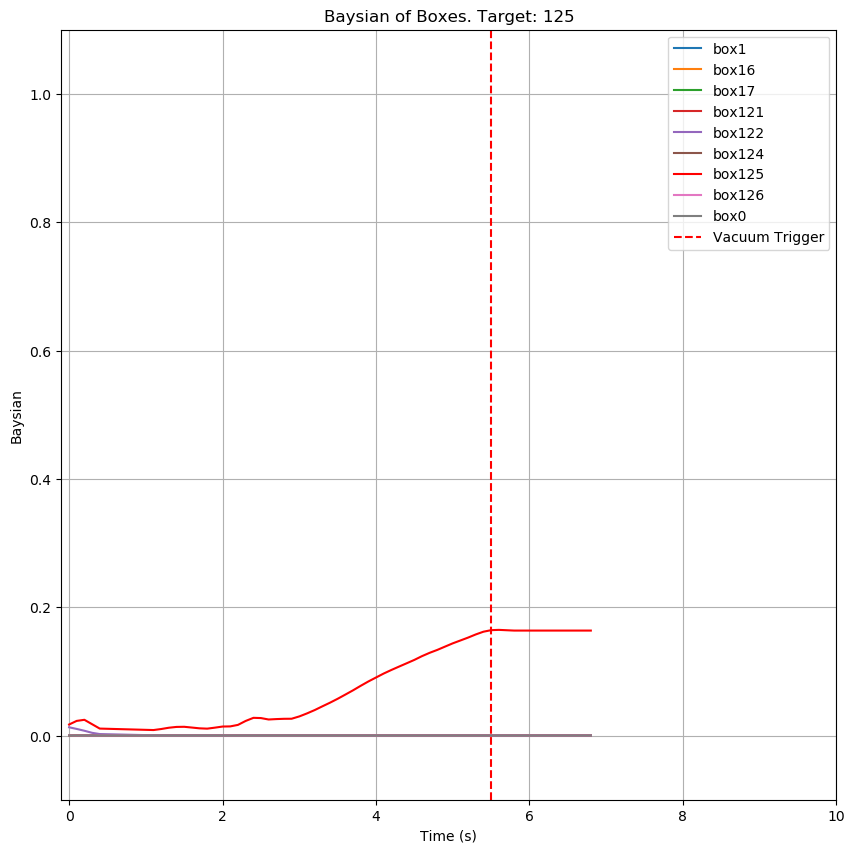

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 125 Success Time Rate: 0.3515829002883108


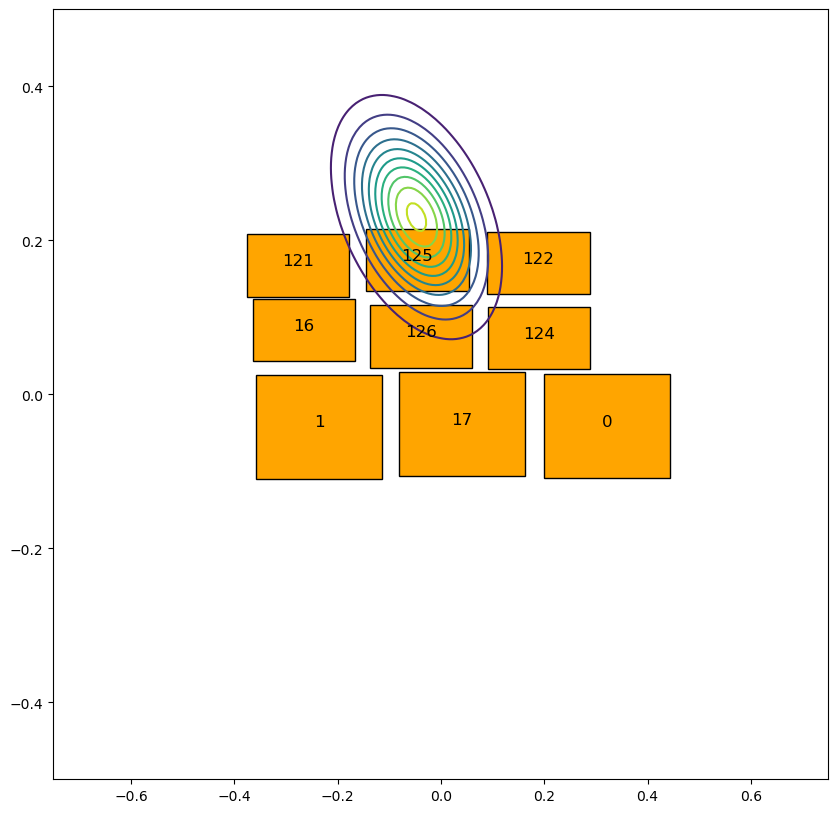

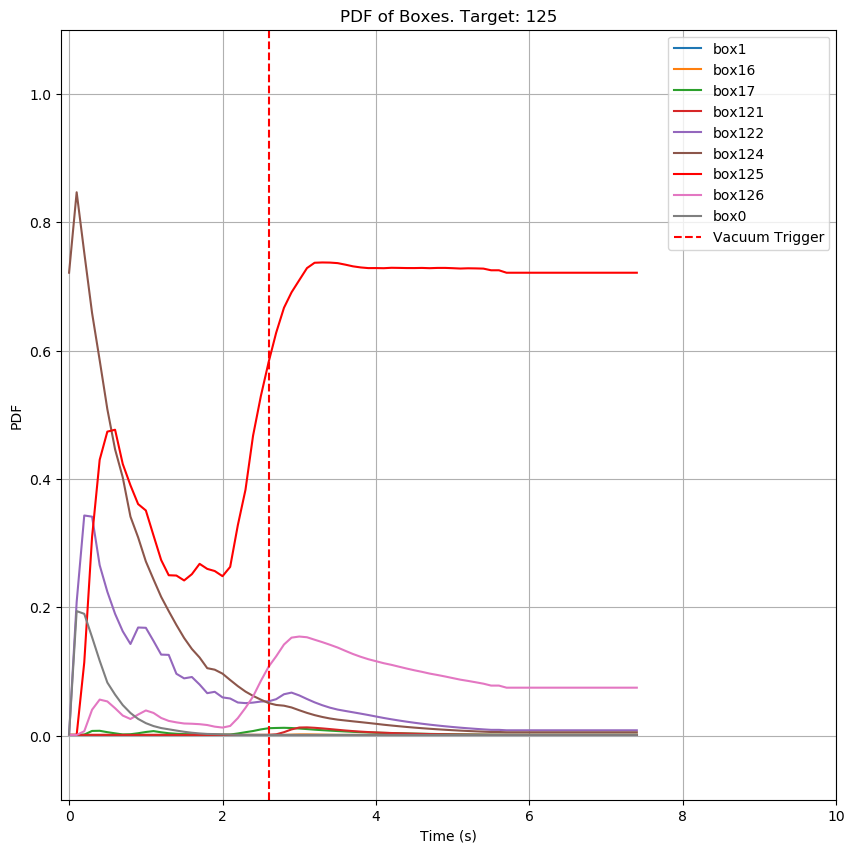

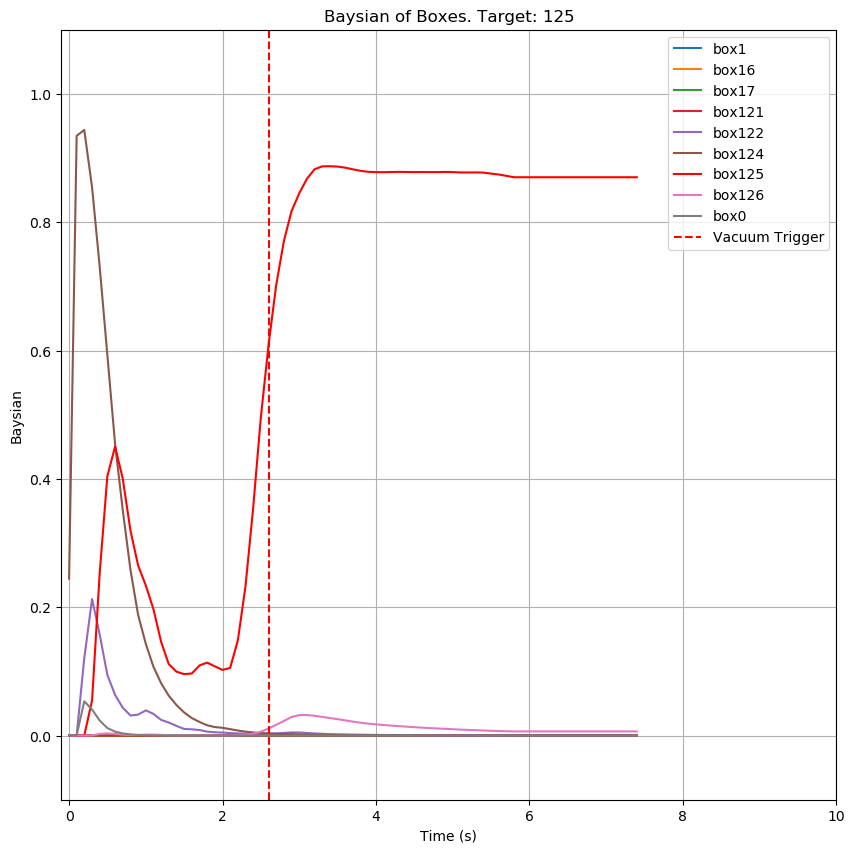

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 126 Success Time Rate: 0.13496852326199155


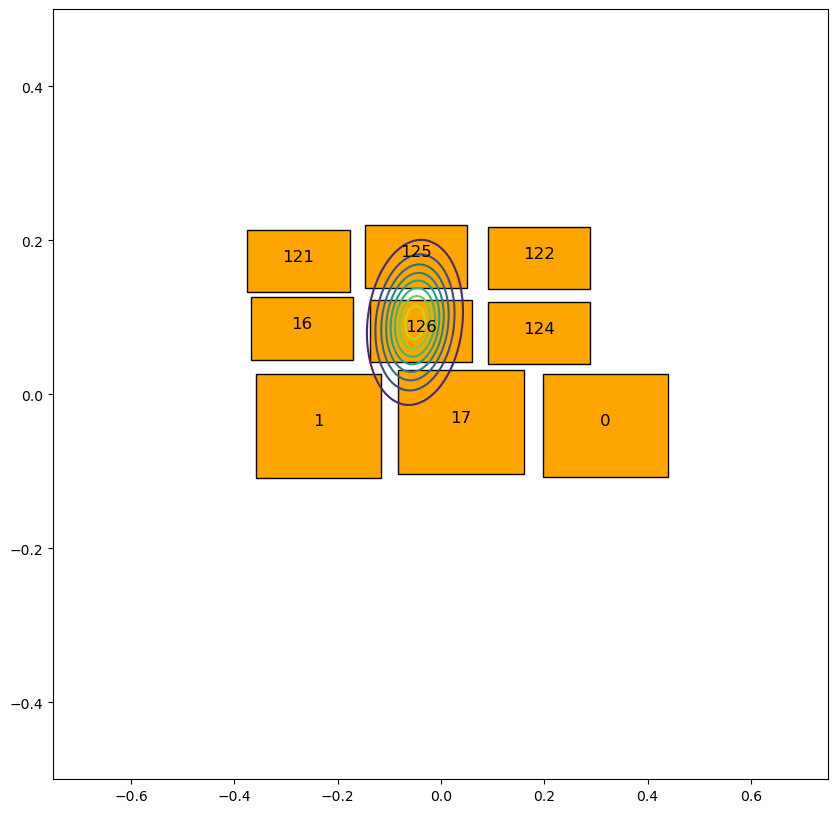

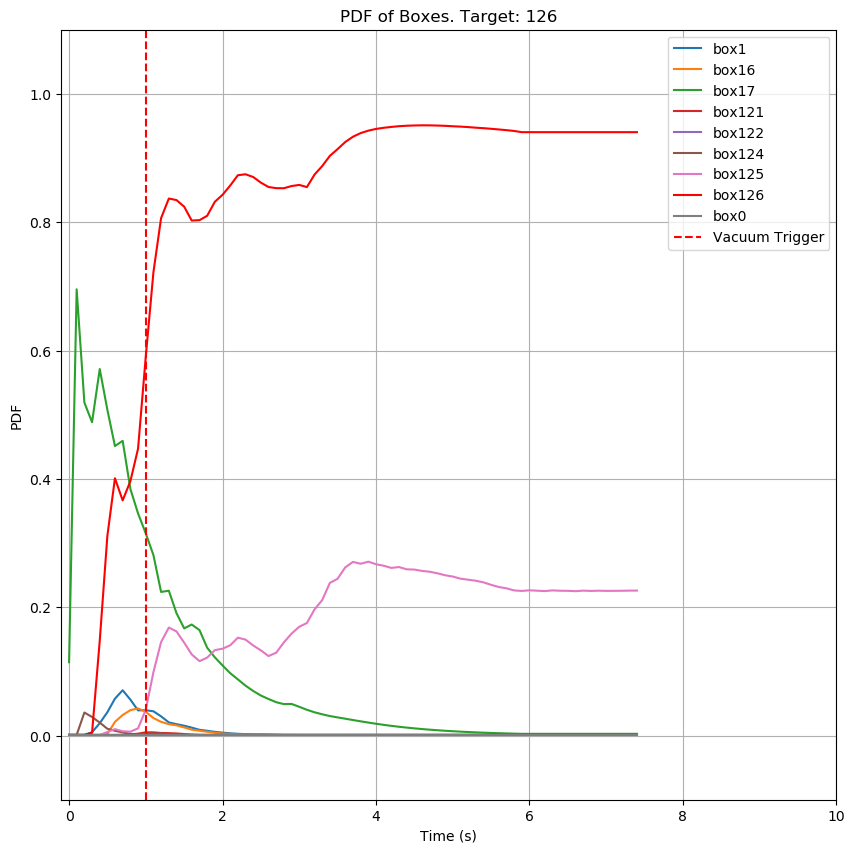

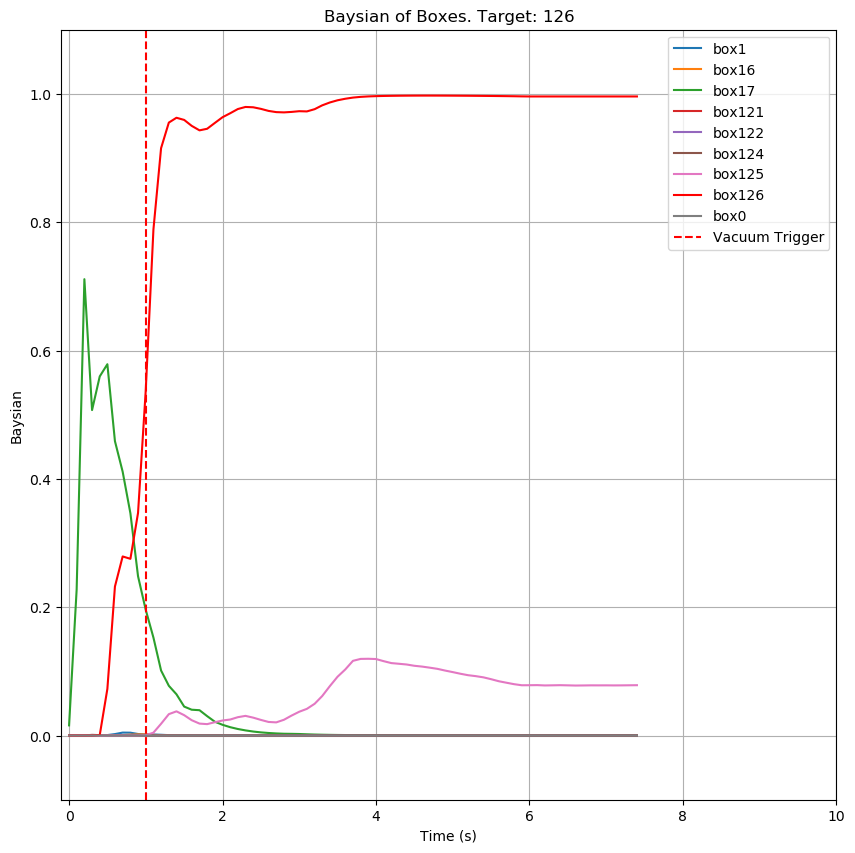

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 126 Success Time Rate: 0.028133825736396847


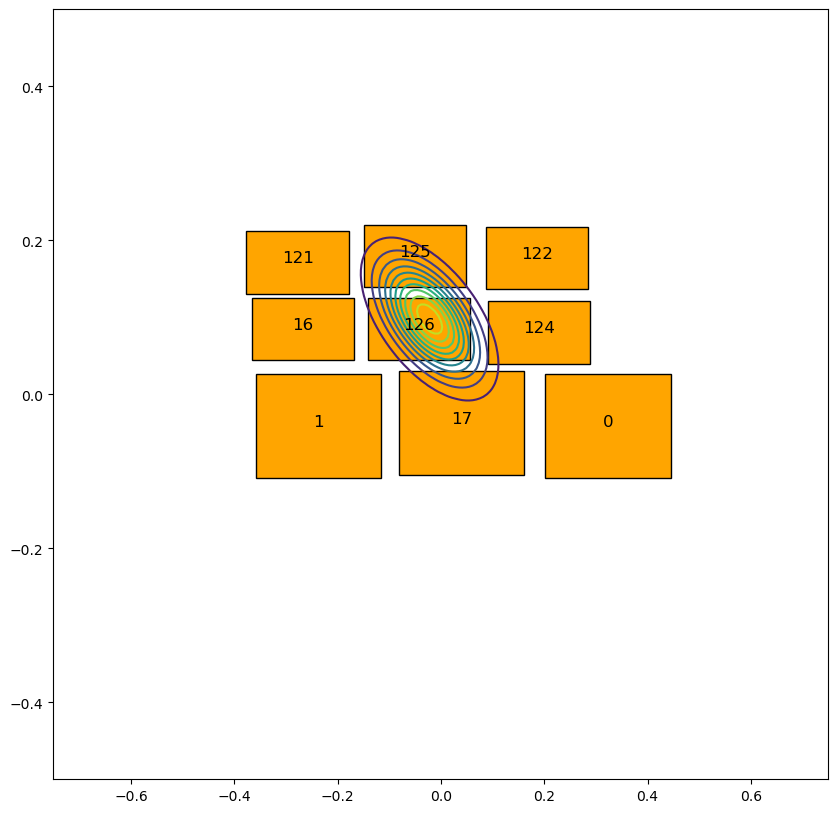

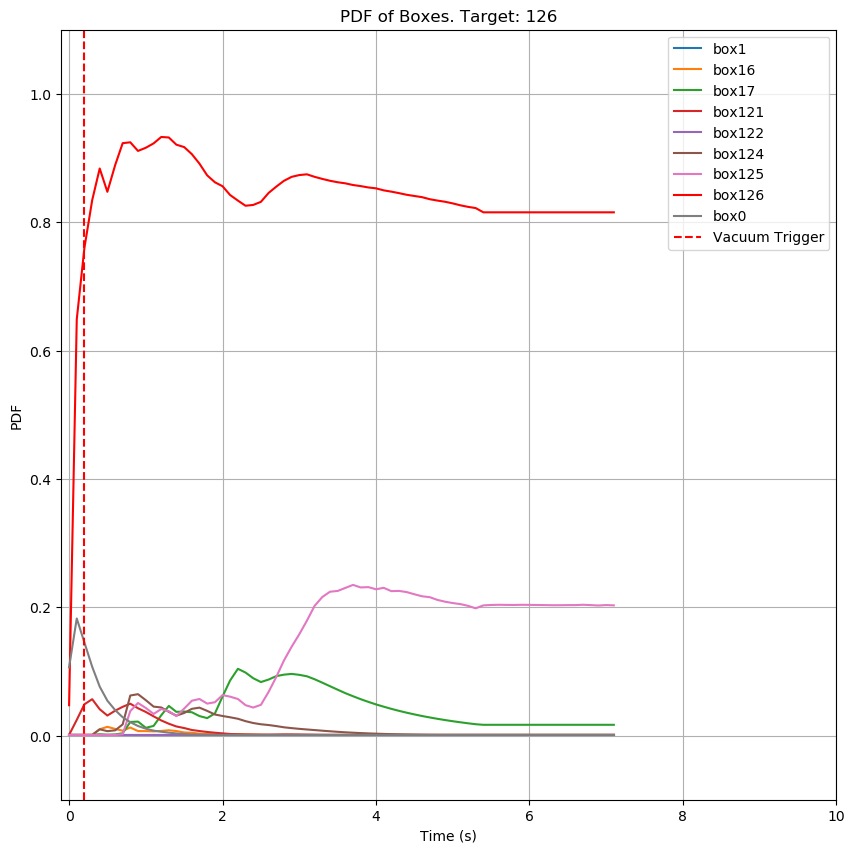

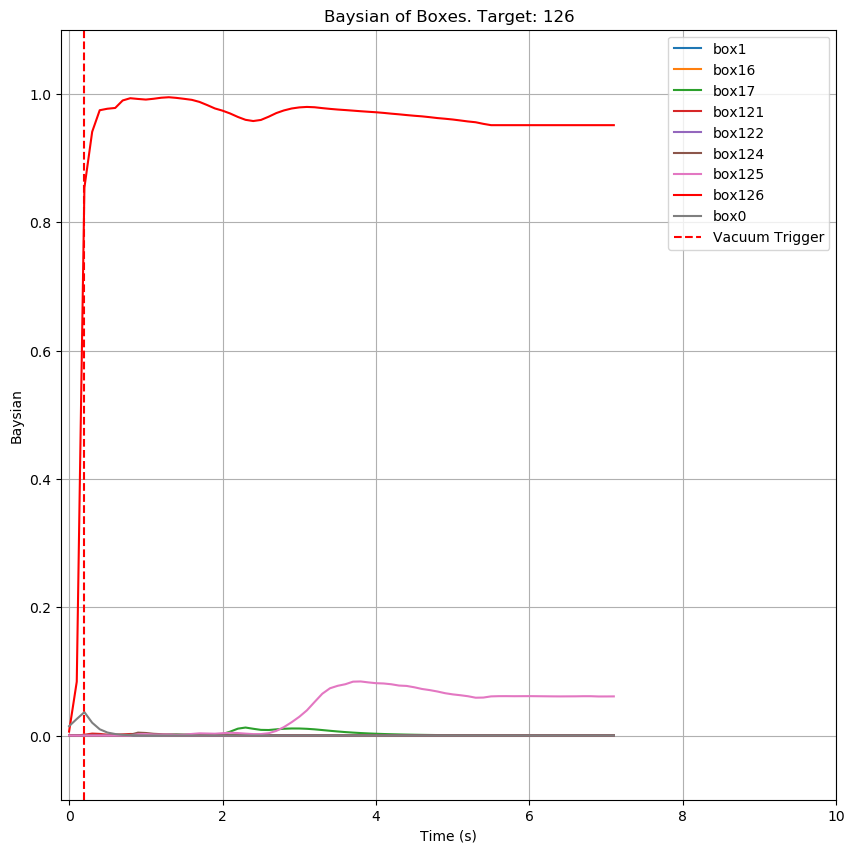

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 126 Success Time Rate: 0.07837602856714601


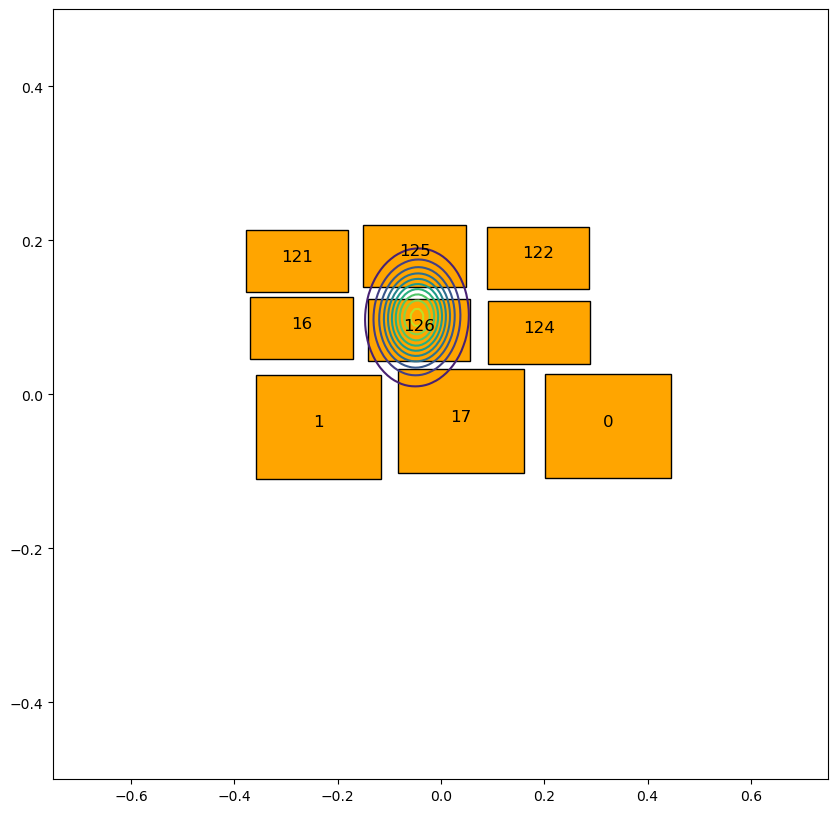

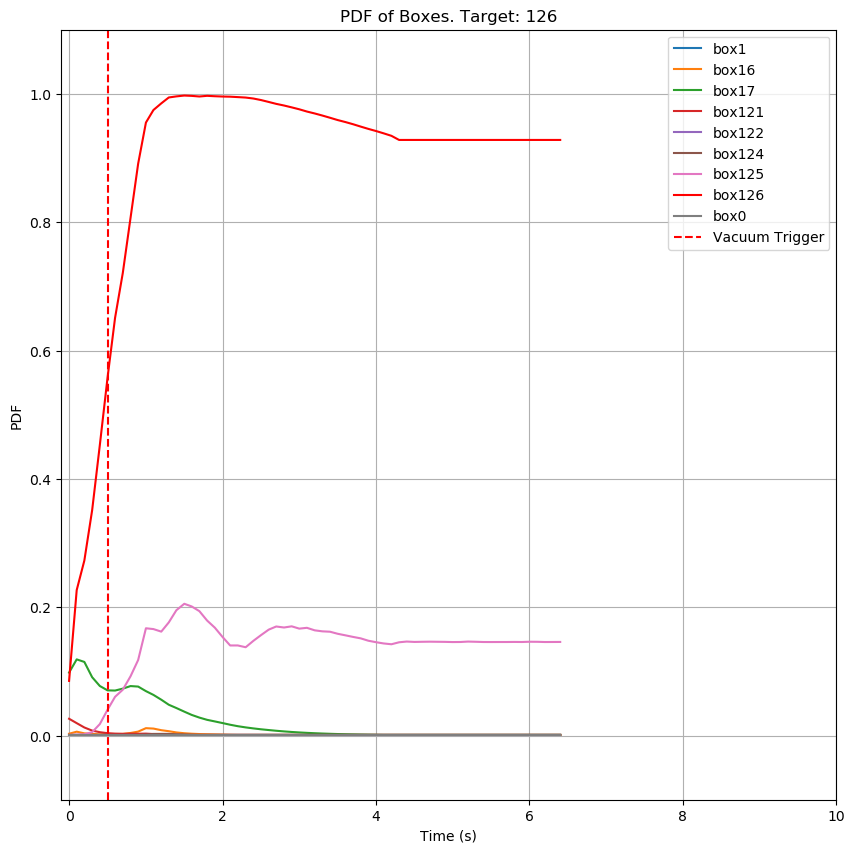

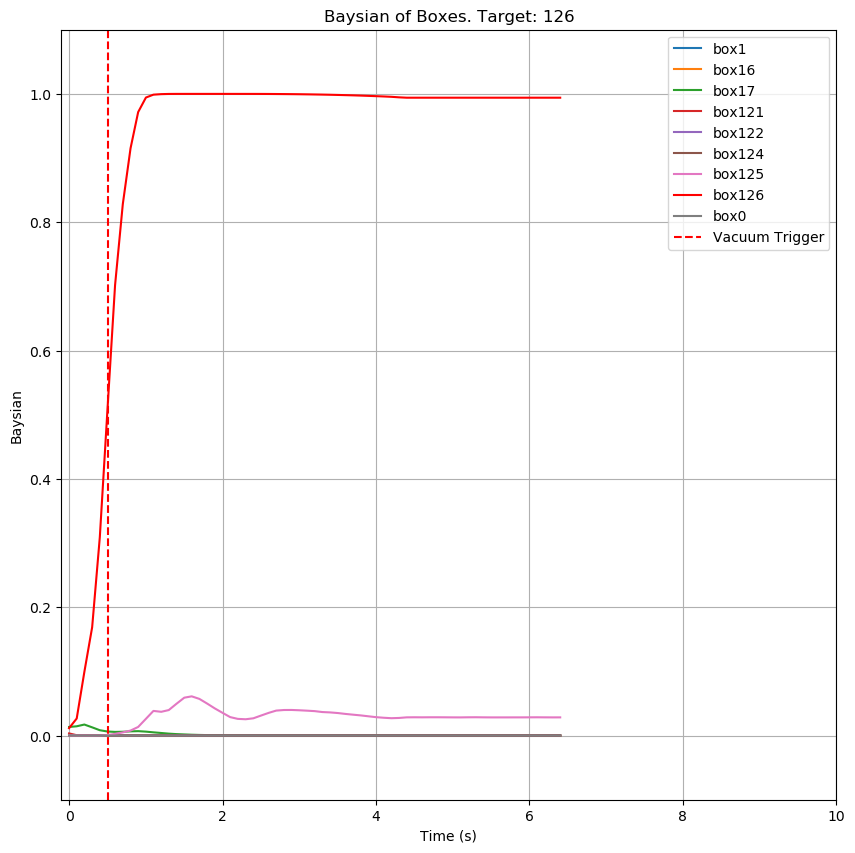

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 126 Success Time Rate: 0.06943324087436158


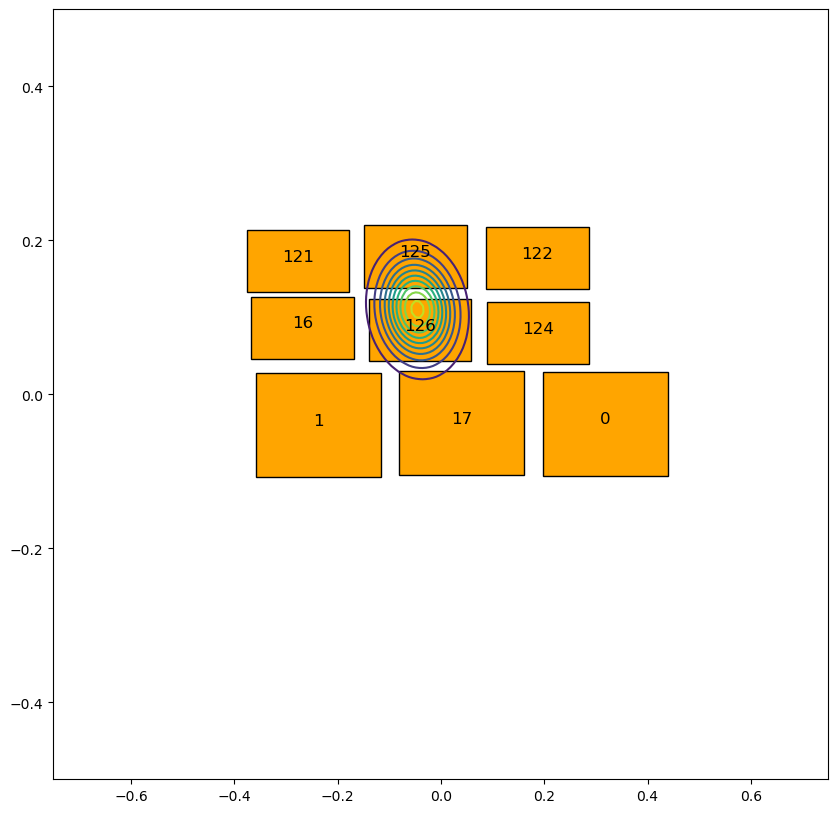

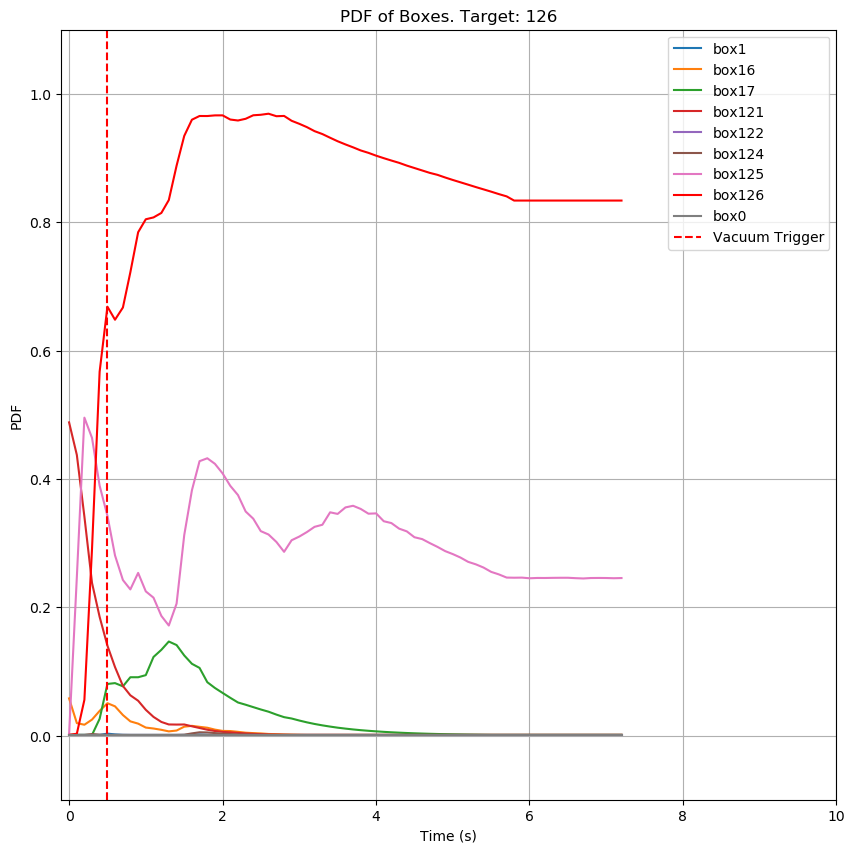

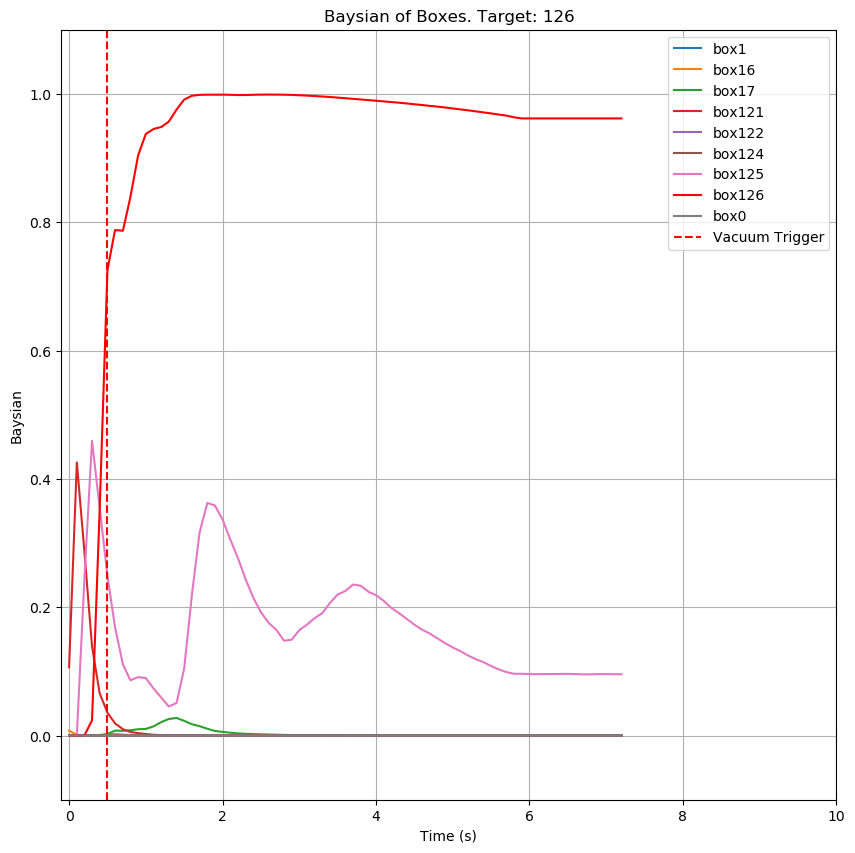

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 16 Success Time Rate: 0.3055653754633247


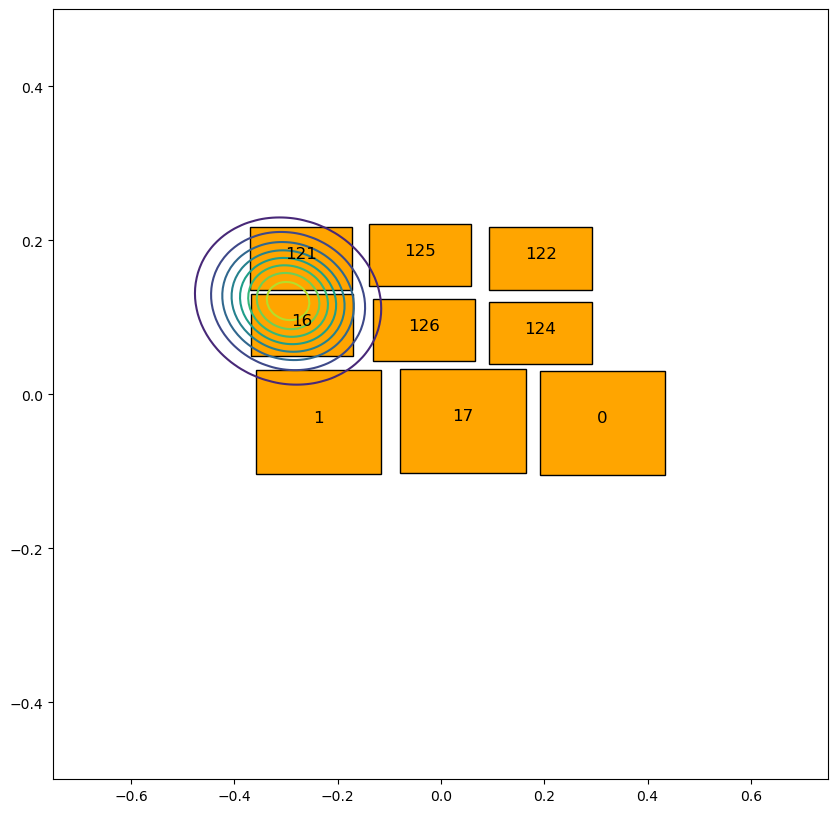

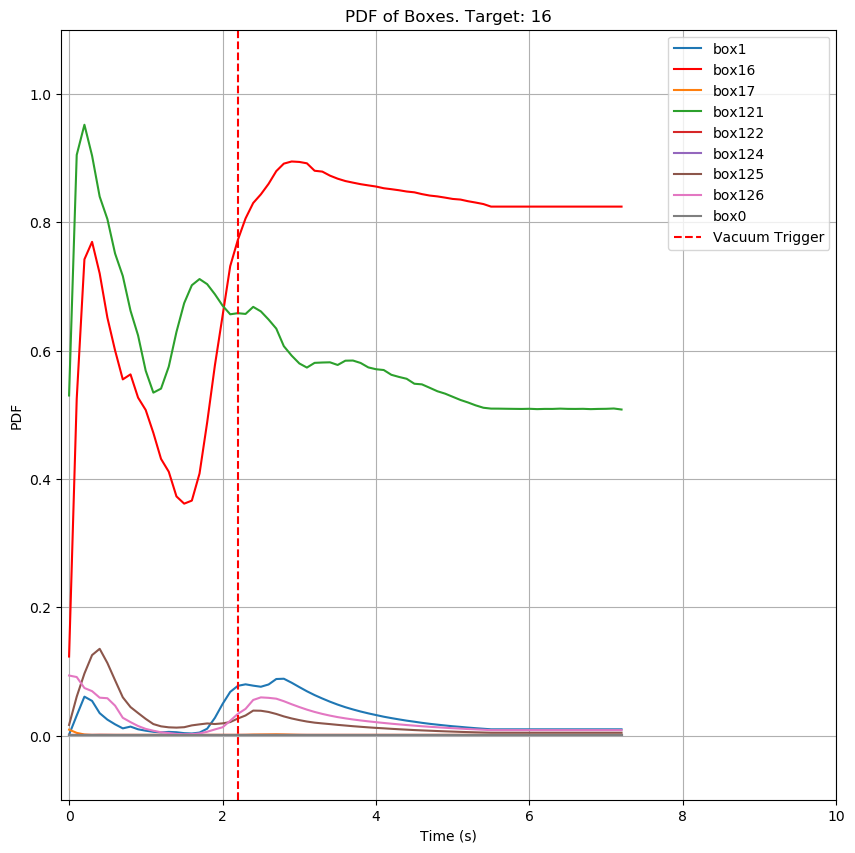

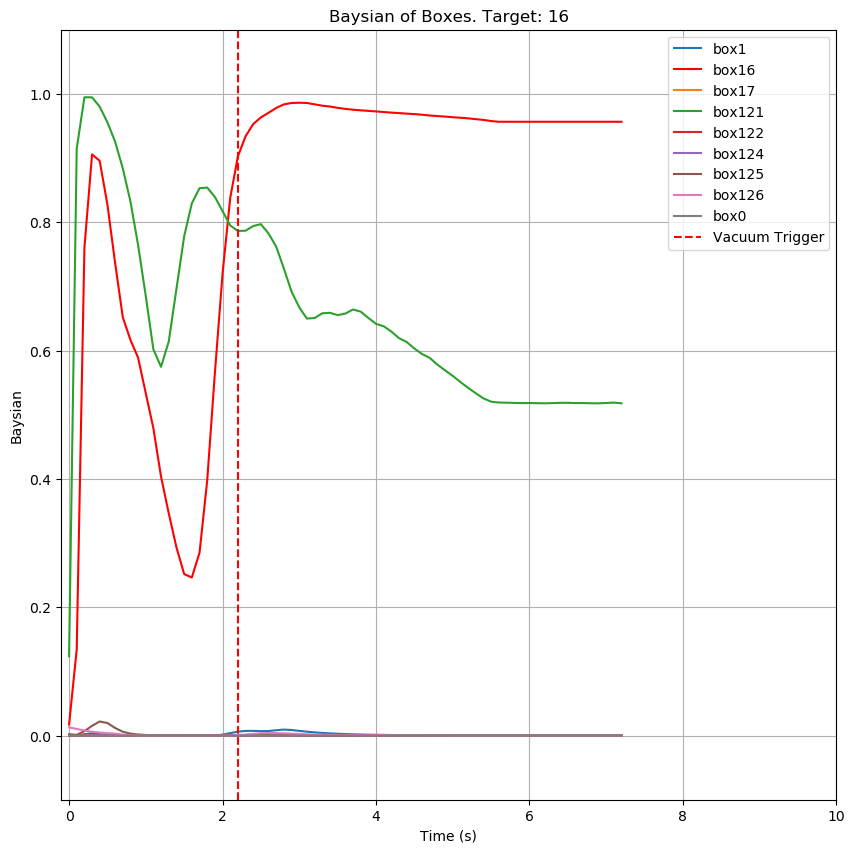

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 16 Success Time Rate: 0.11920930296231966


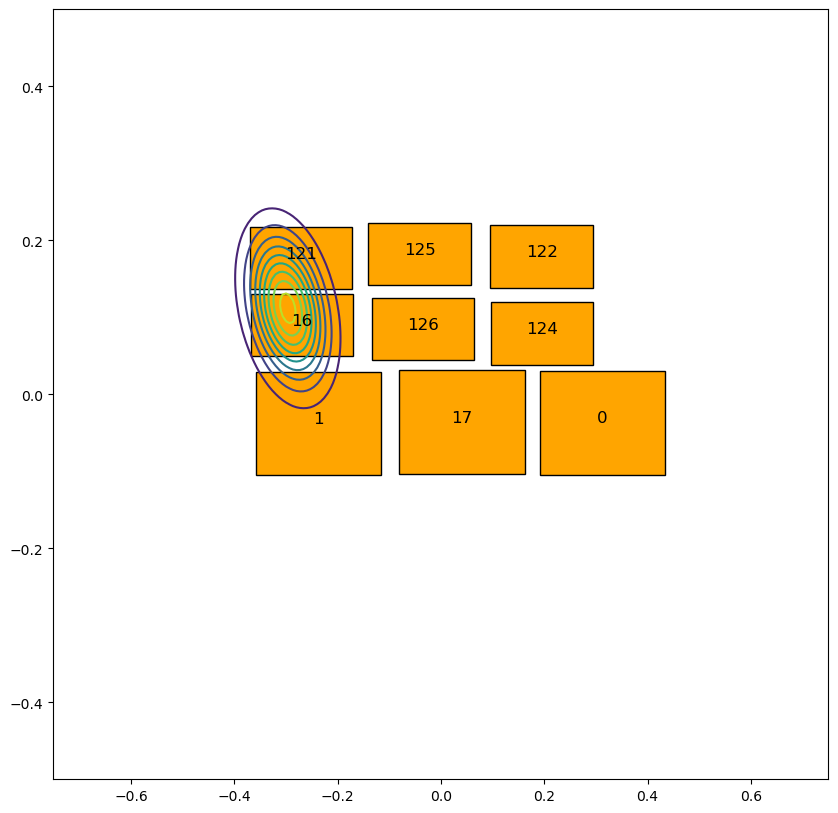

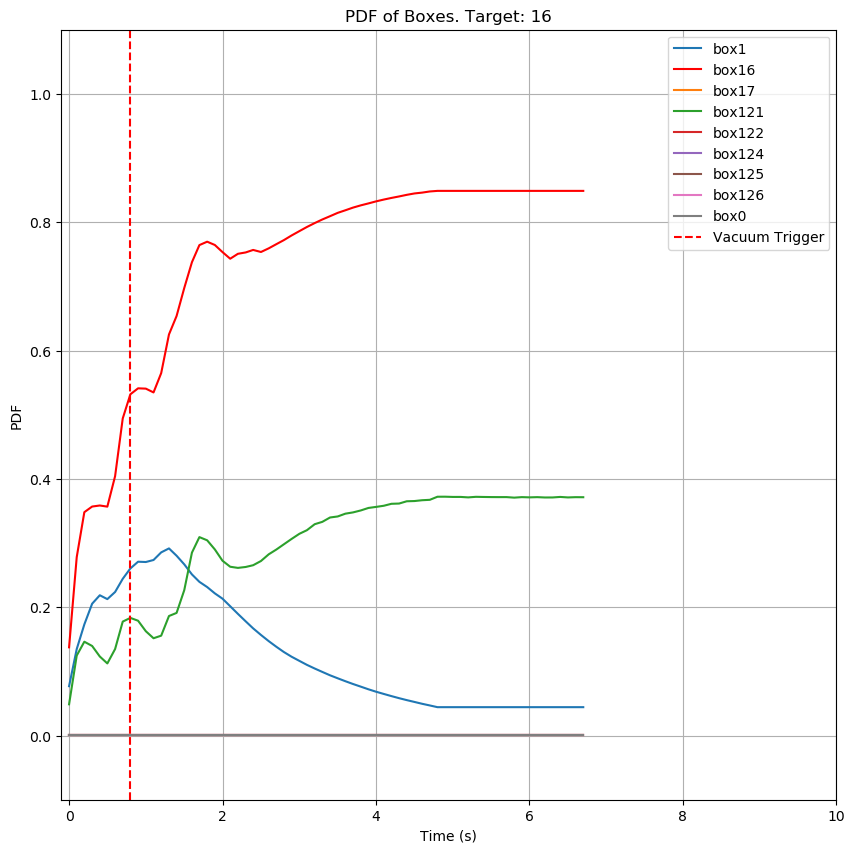

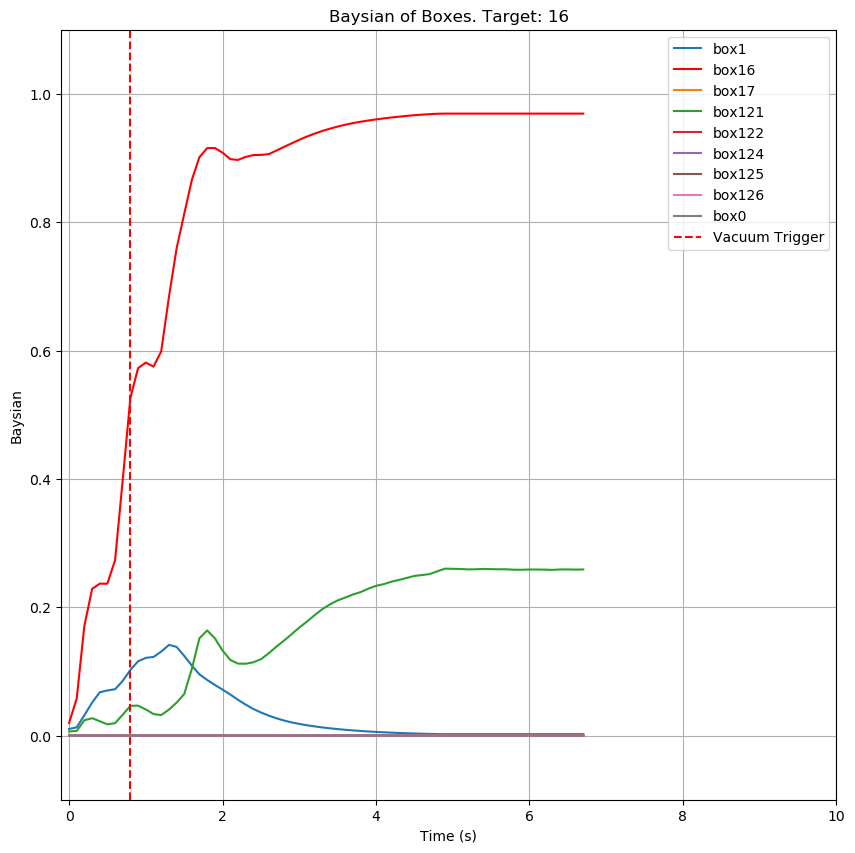

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 16 Success Time Rate: 0.3433393779205703


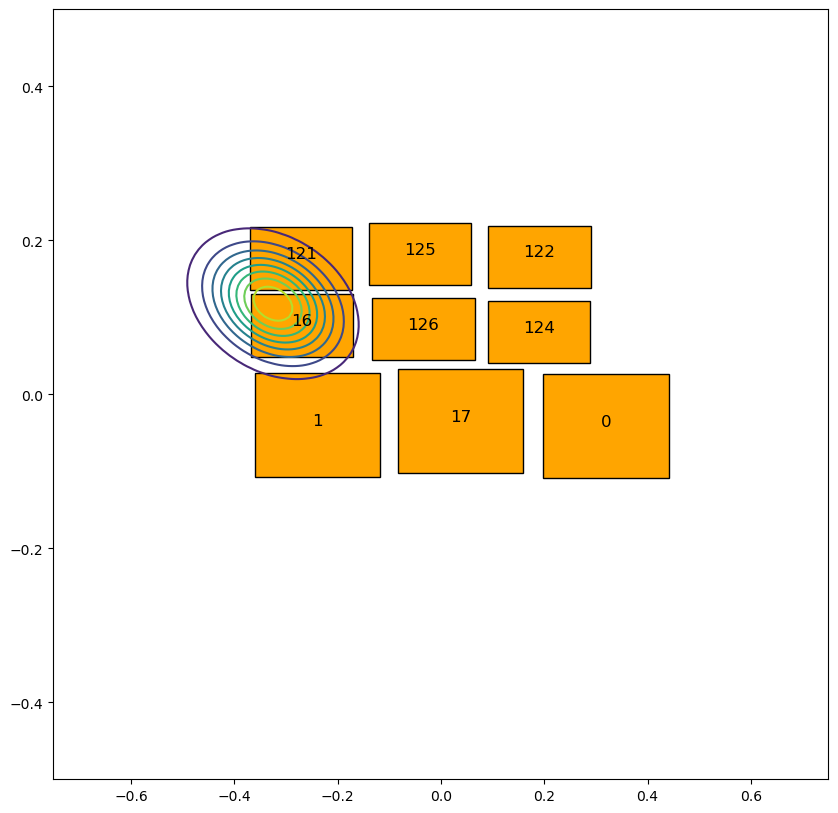

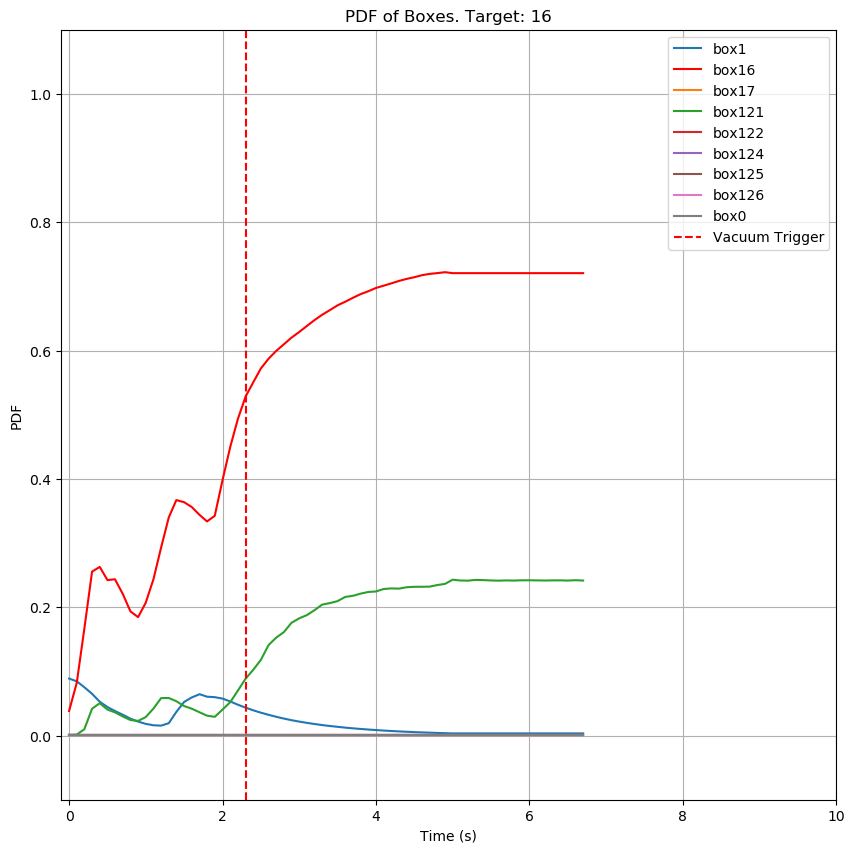

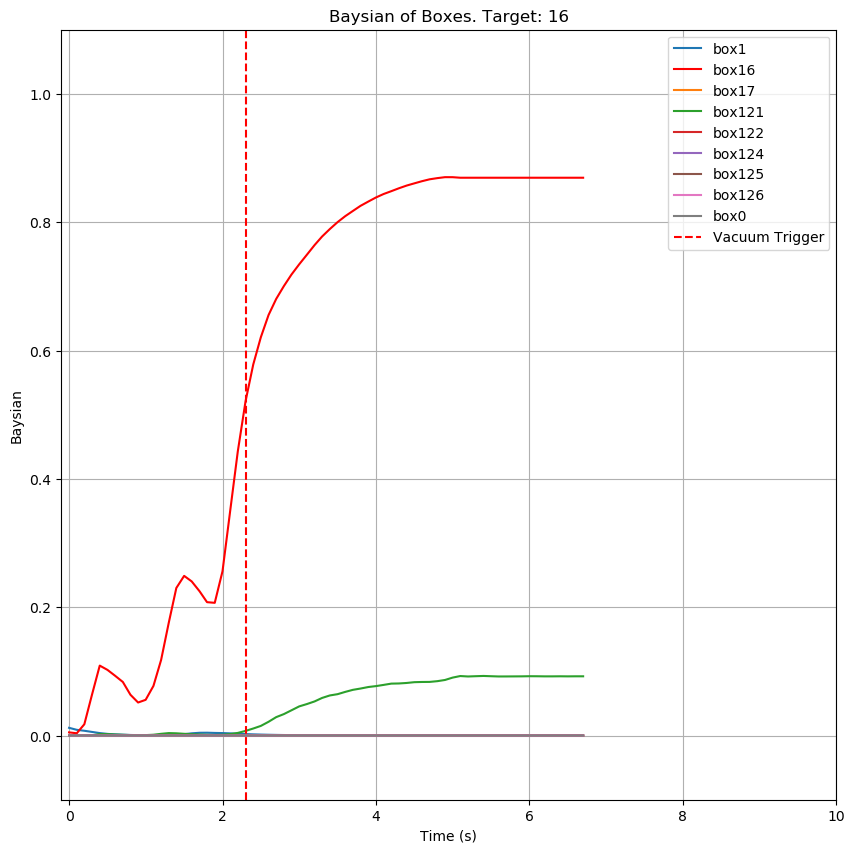

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 16 Success Time Rate: 0.07959788743071769


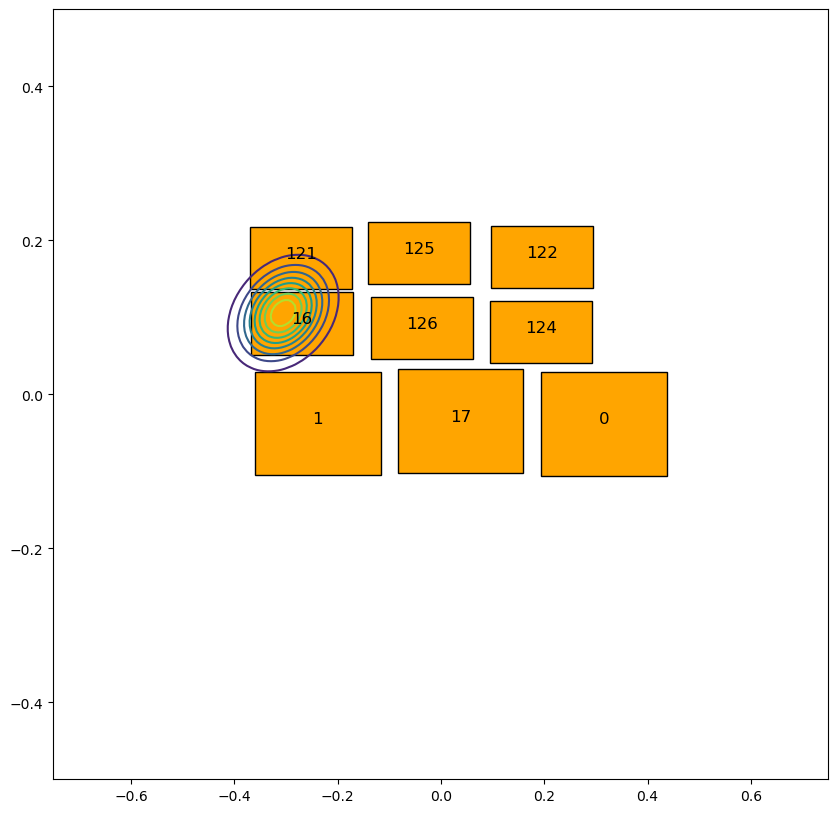

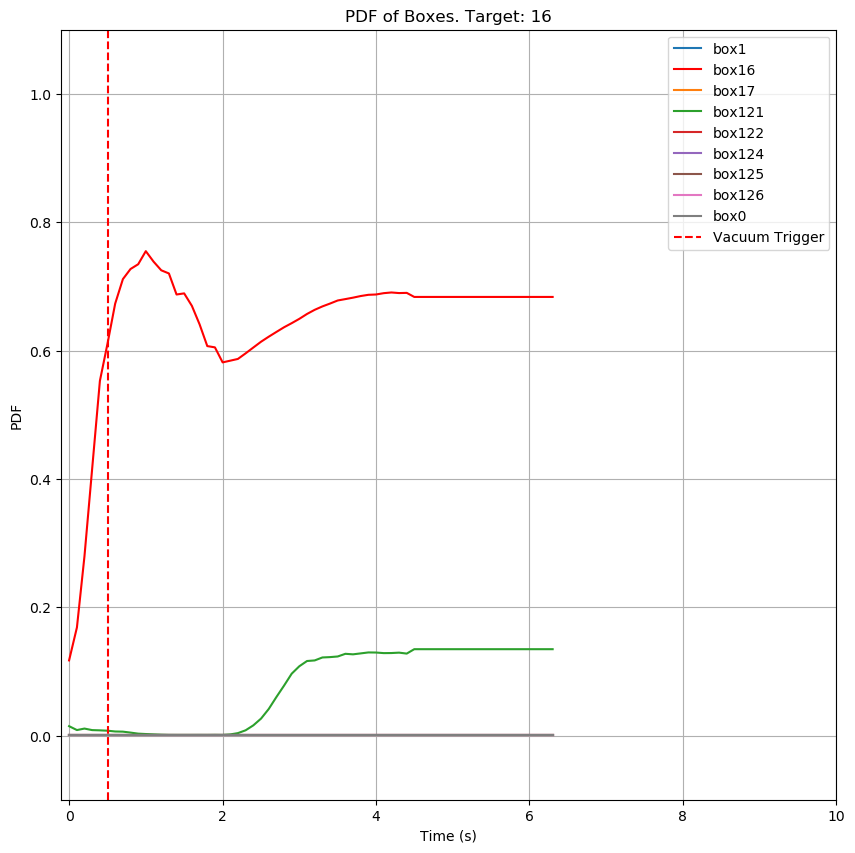

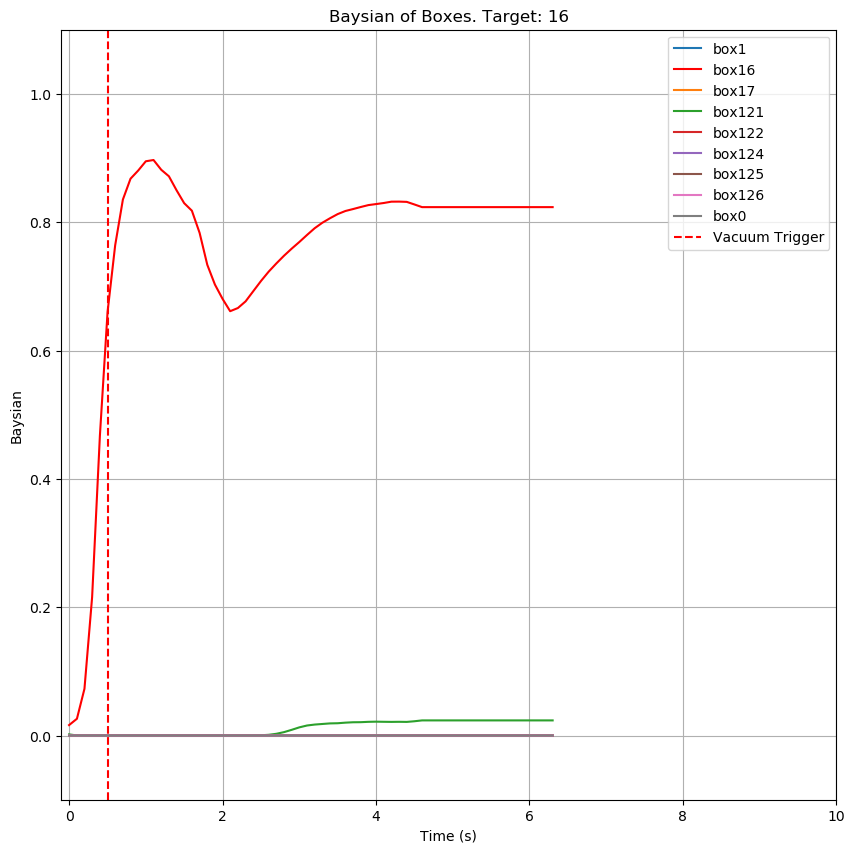

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 17 Success Time Rate: 0.030641249170734214


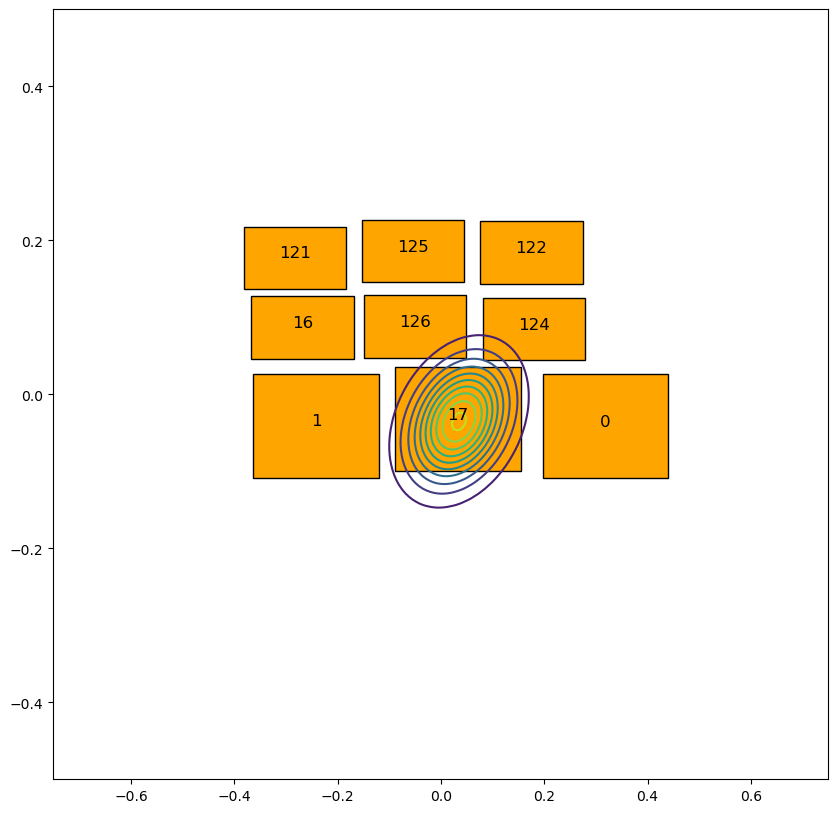

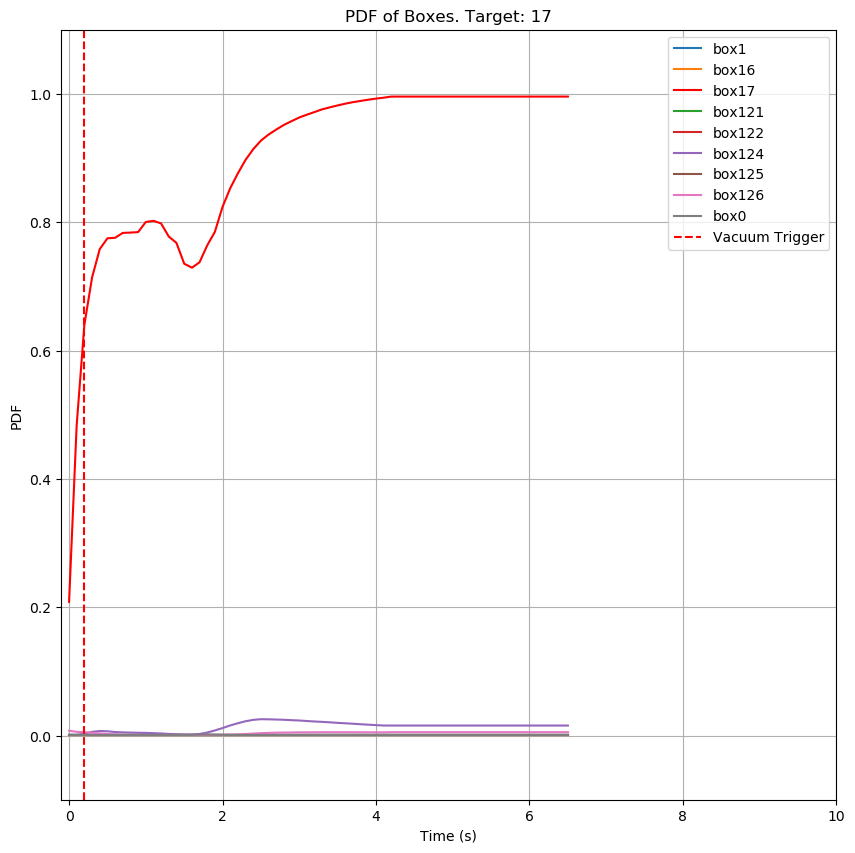

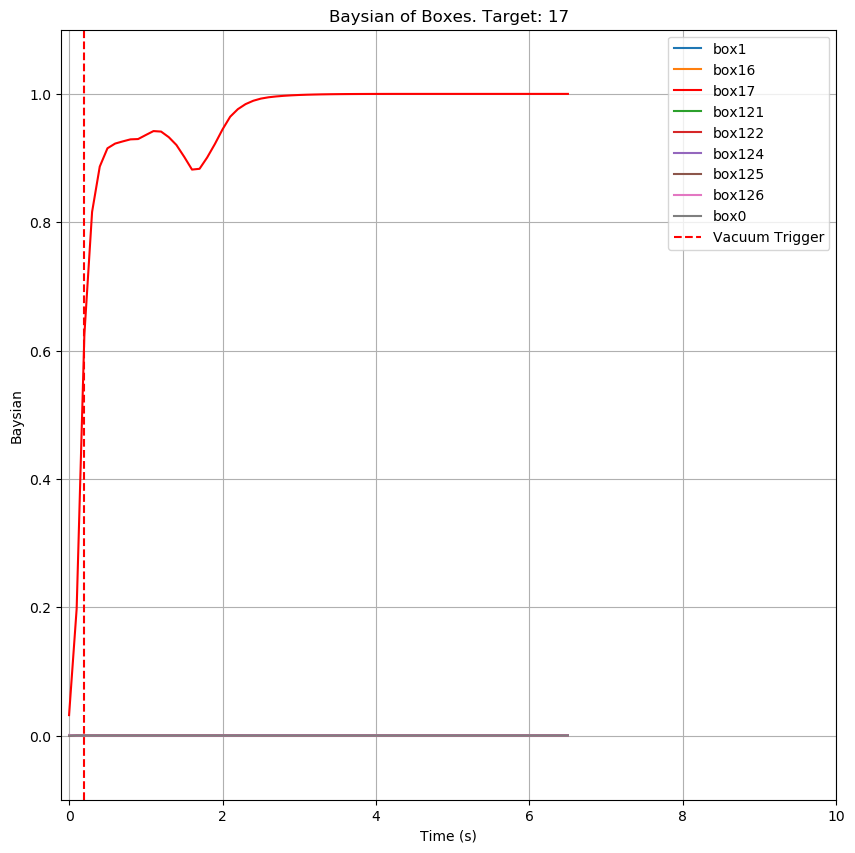

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 17 Success Time Rate: 0.3335466641386067


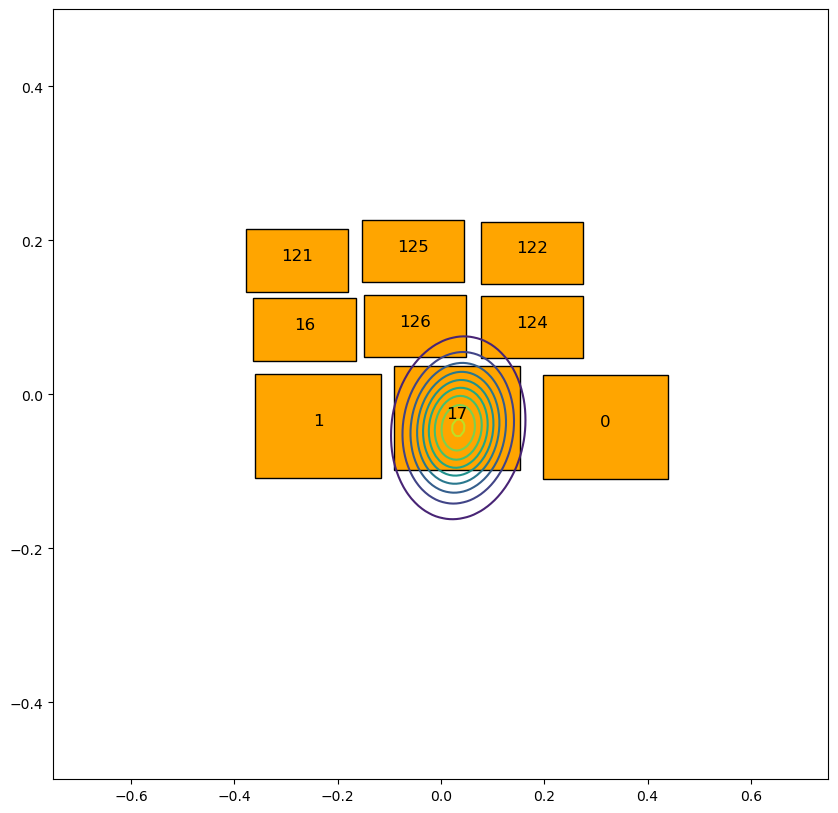

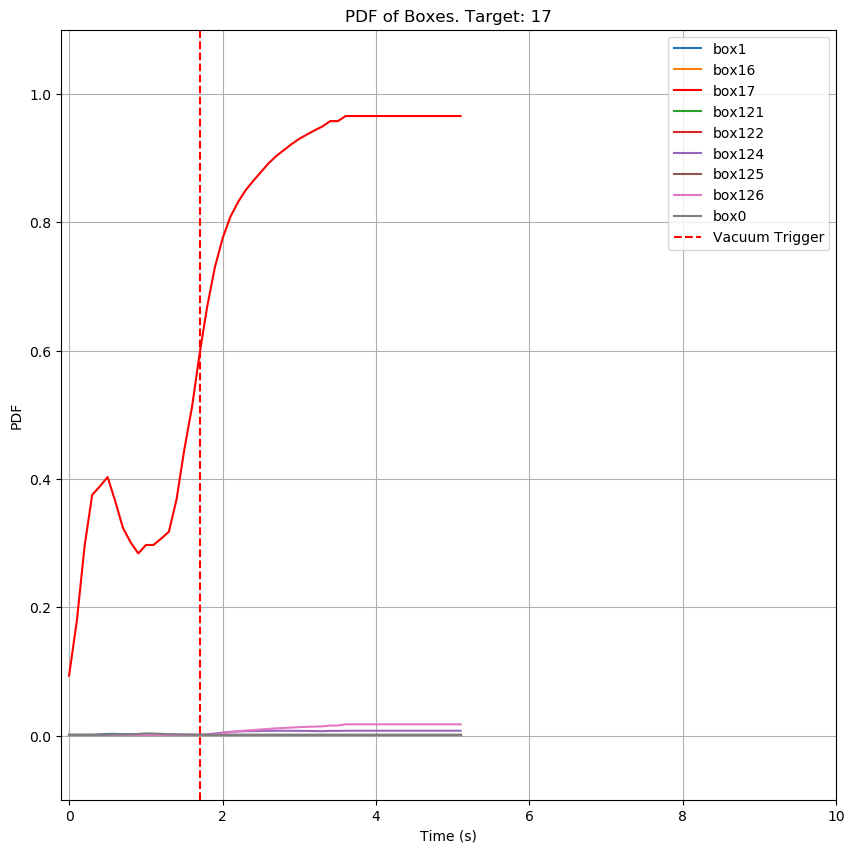

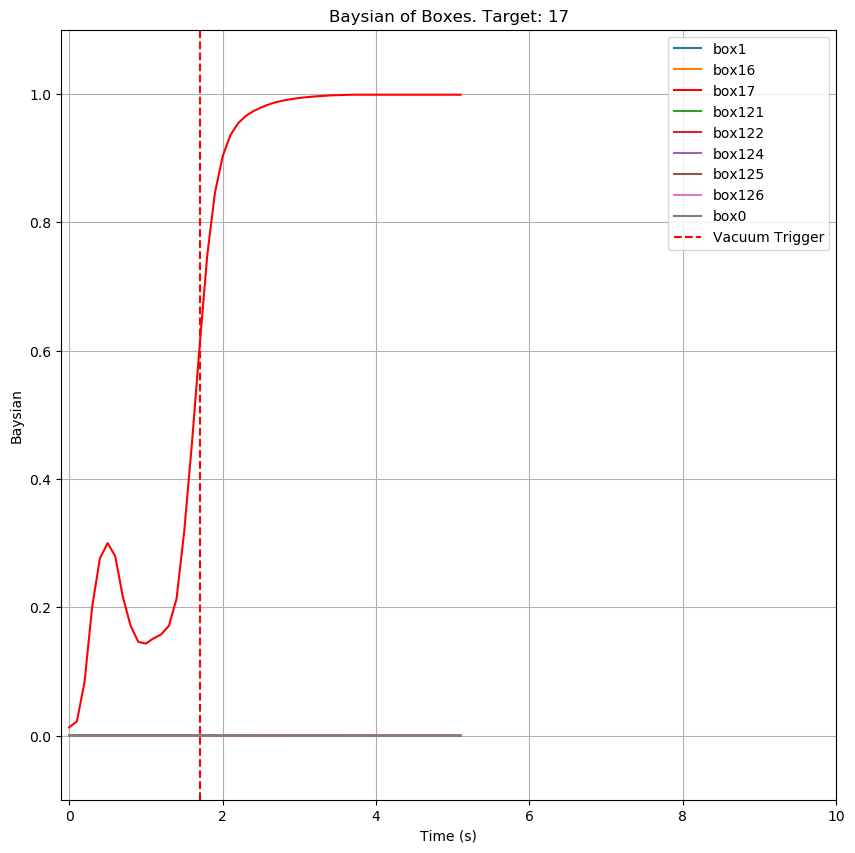

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 17 Success Time Rate: 0.014098541460856514


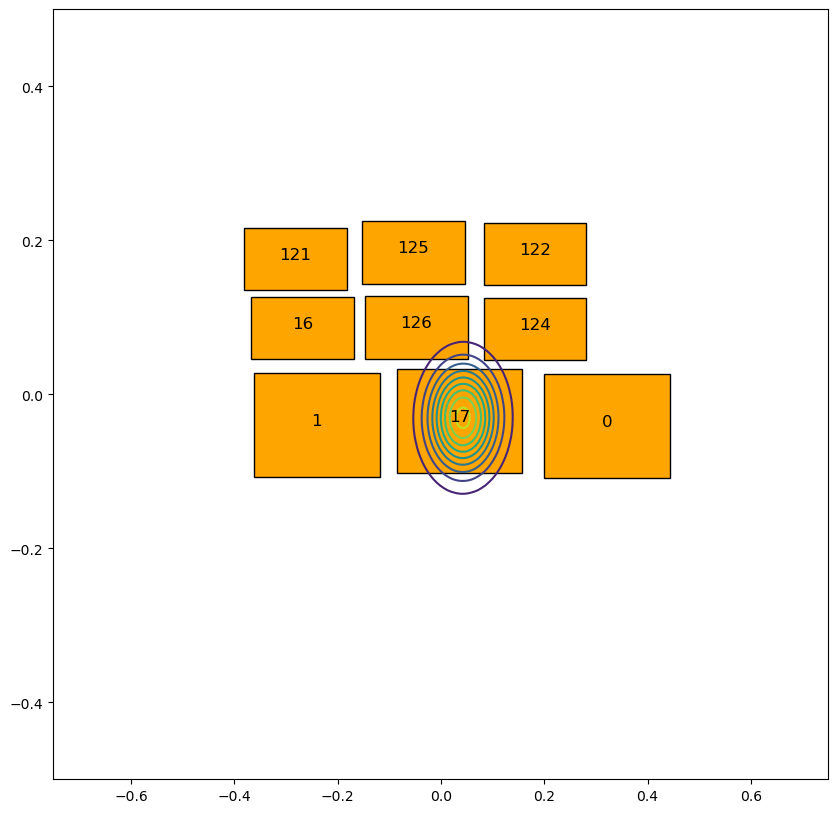

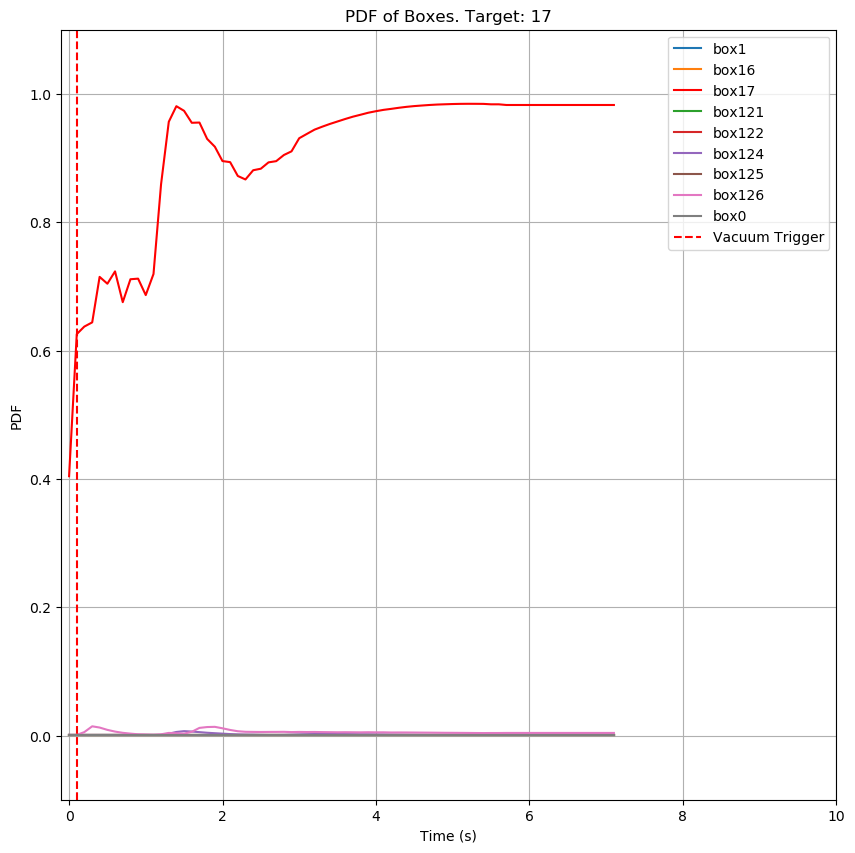

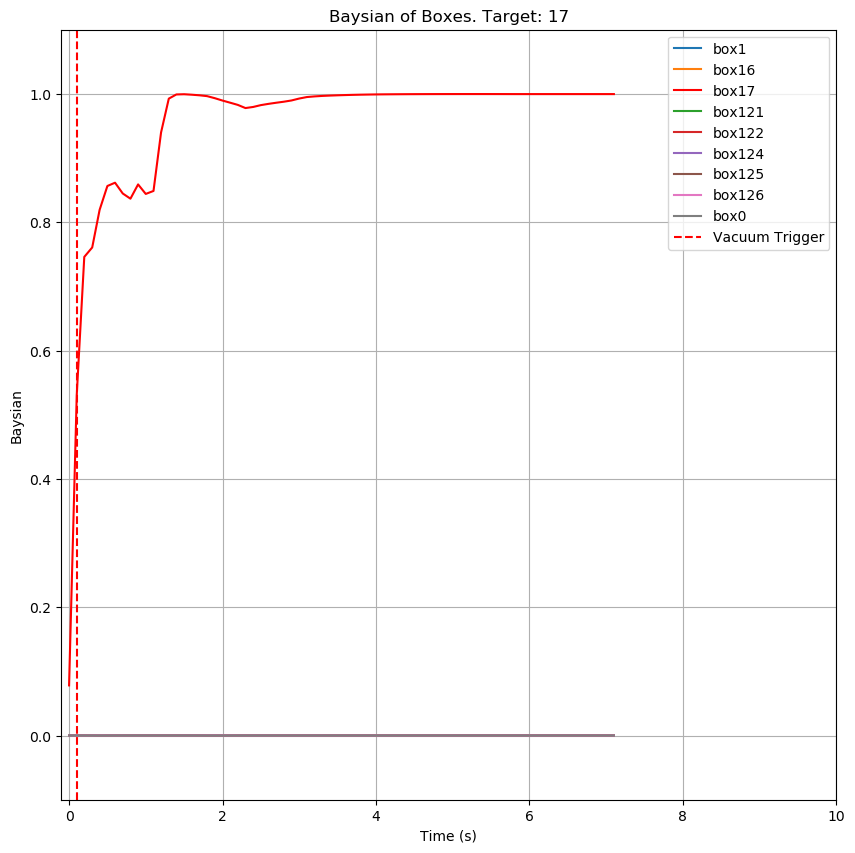

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 17 Success Time Rate: 0.06652486264277771


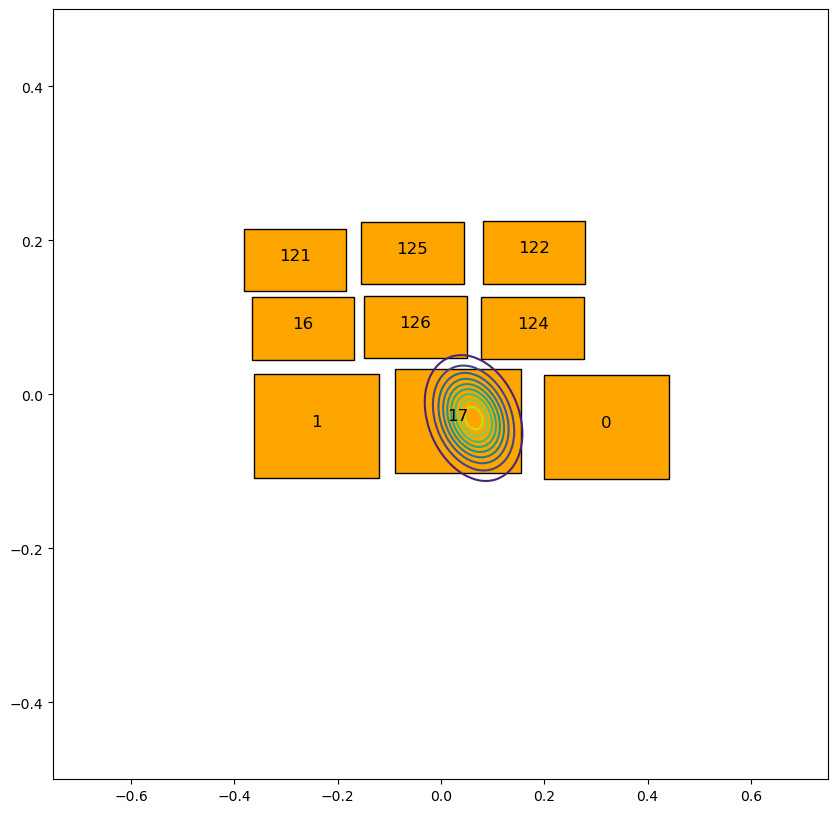

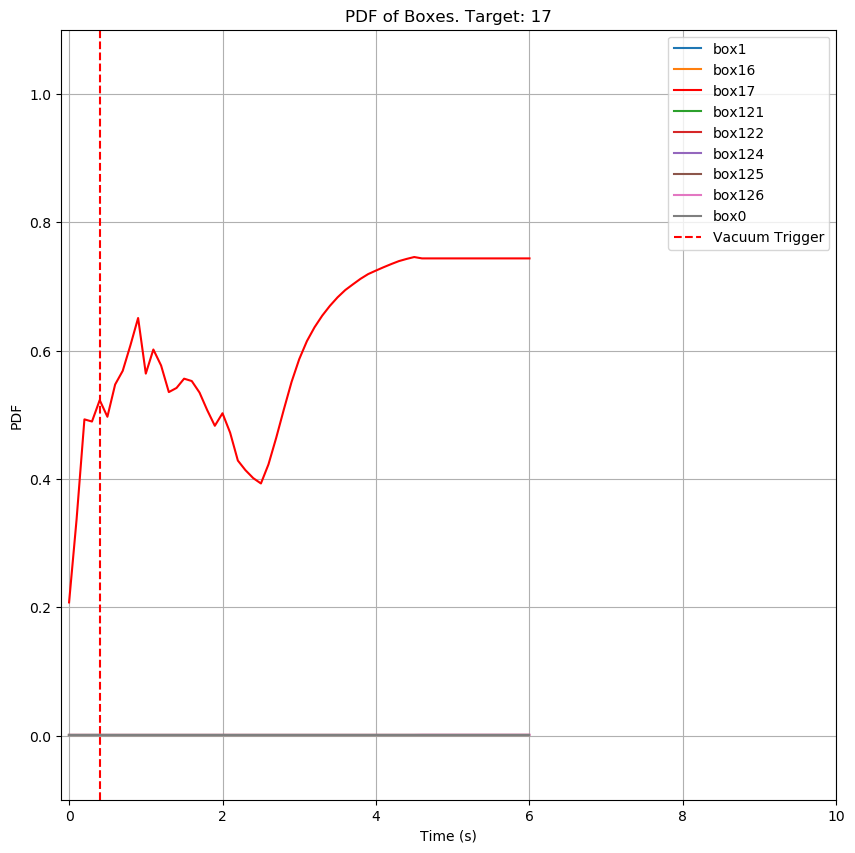

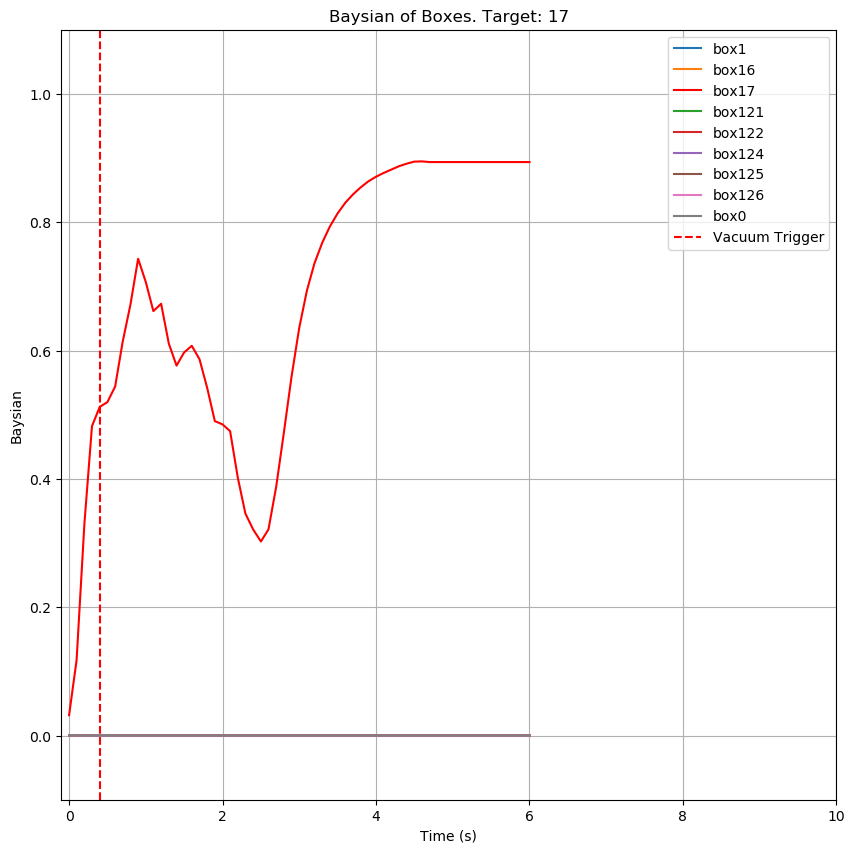

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 17 Success Time Rate: 0.029876128981469158


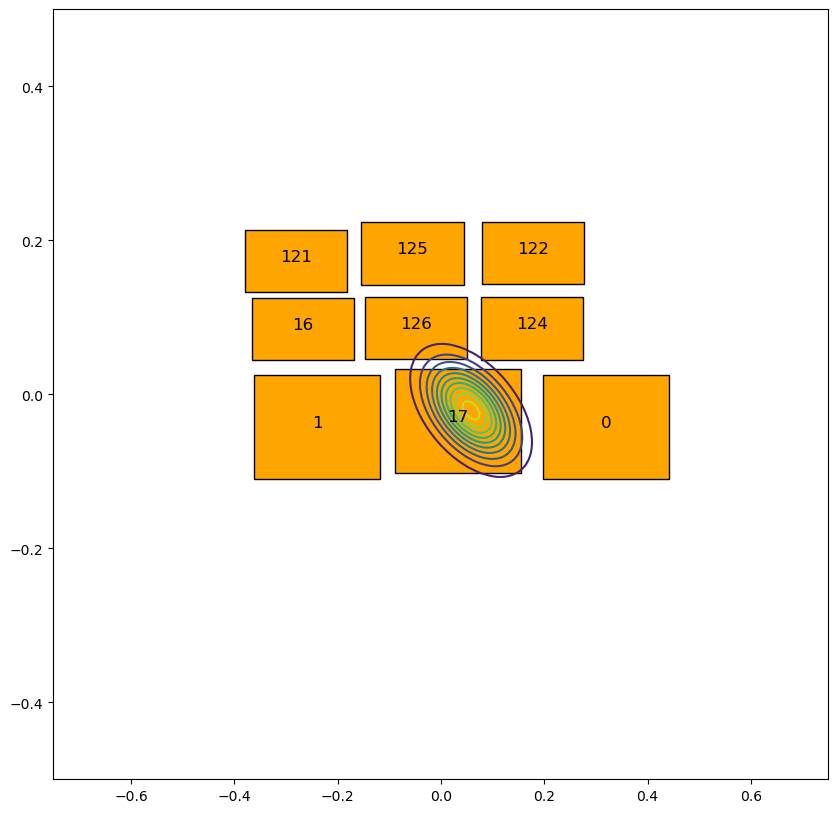

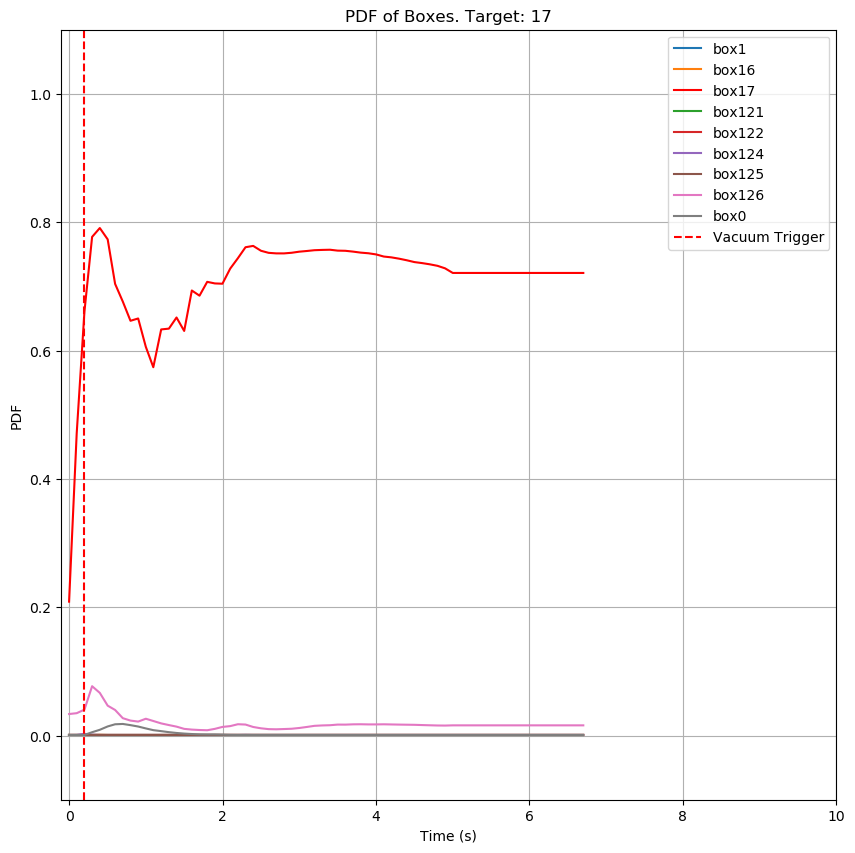

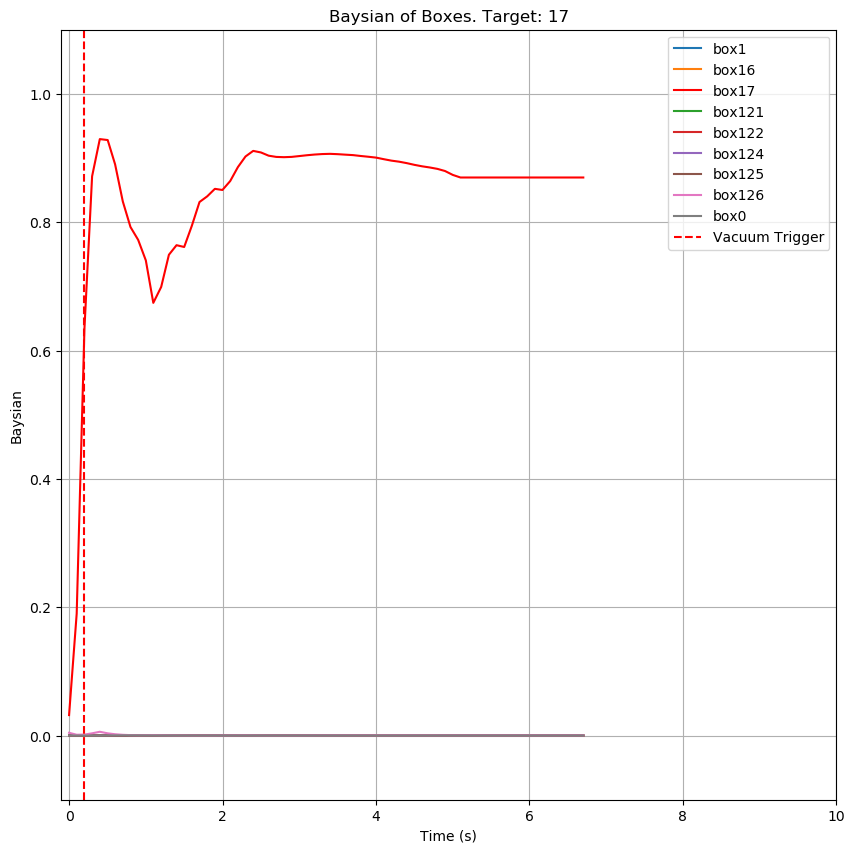

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 1 Success Time Rate: 0.07605529318433532


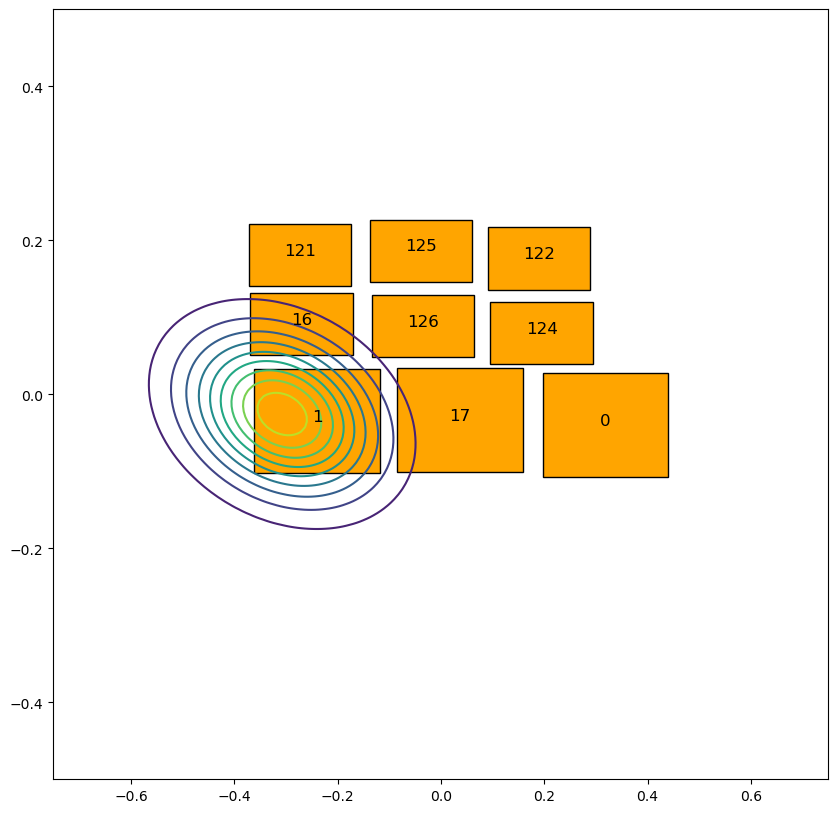

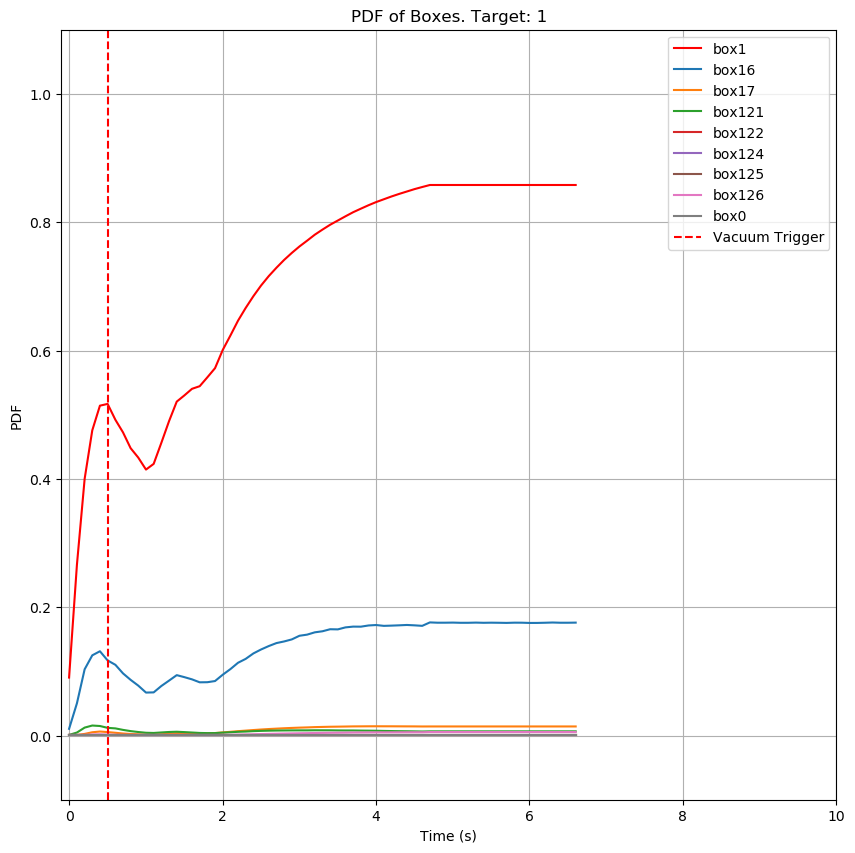

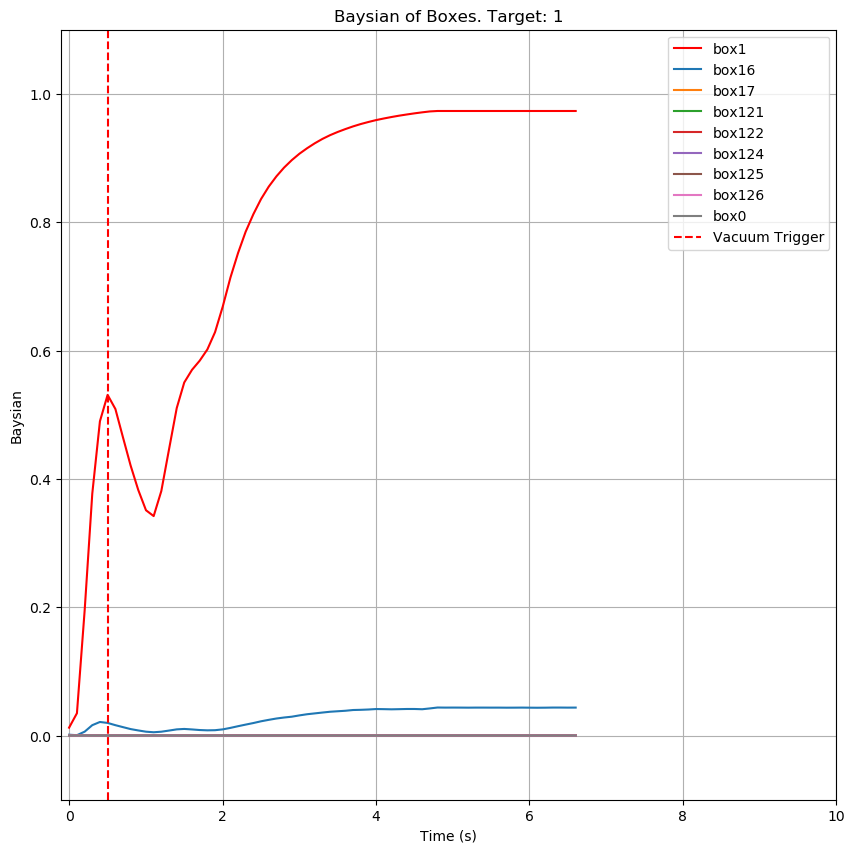

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 1 Success Time Rate: 0.2181299763046379


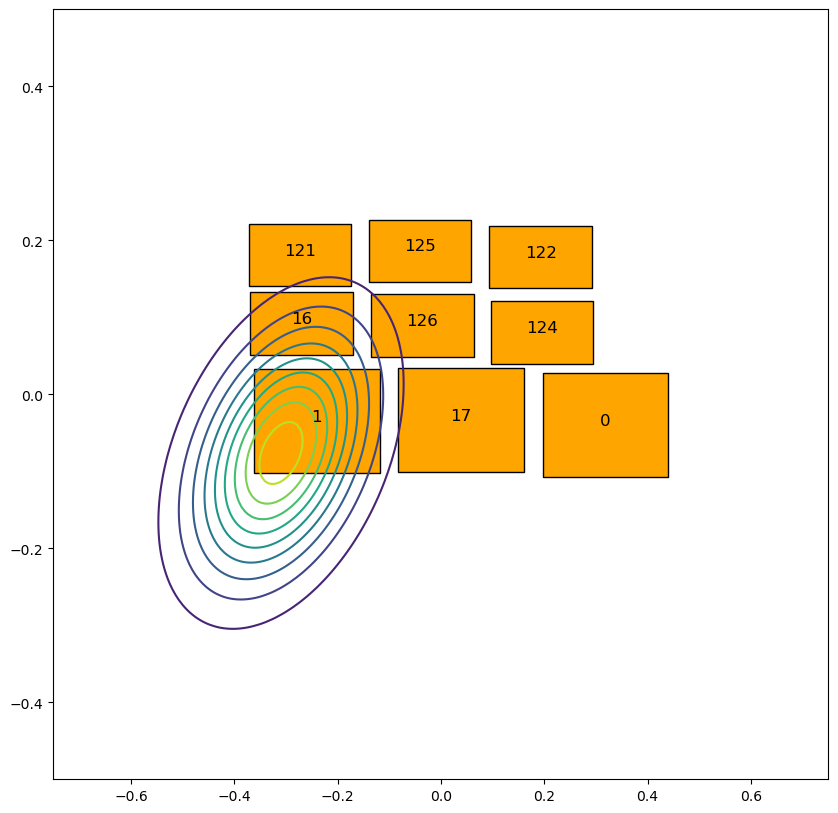

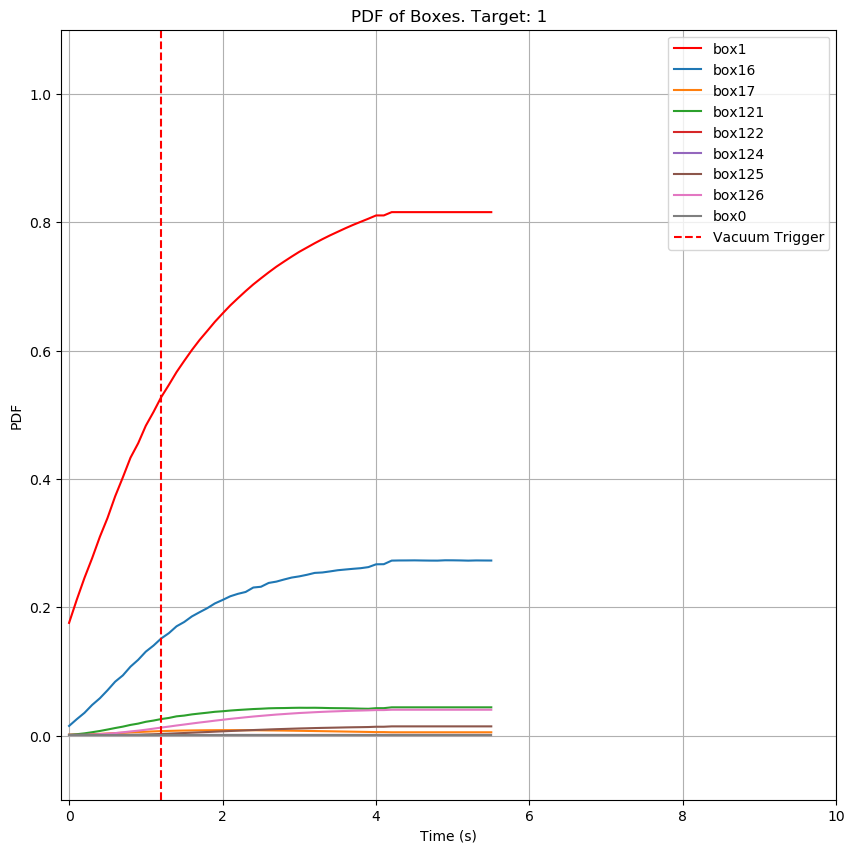

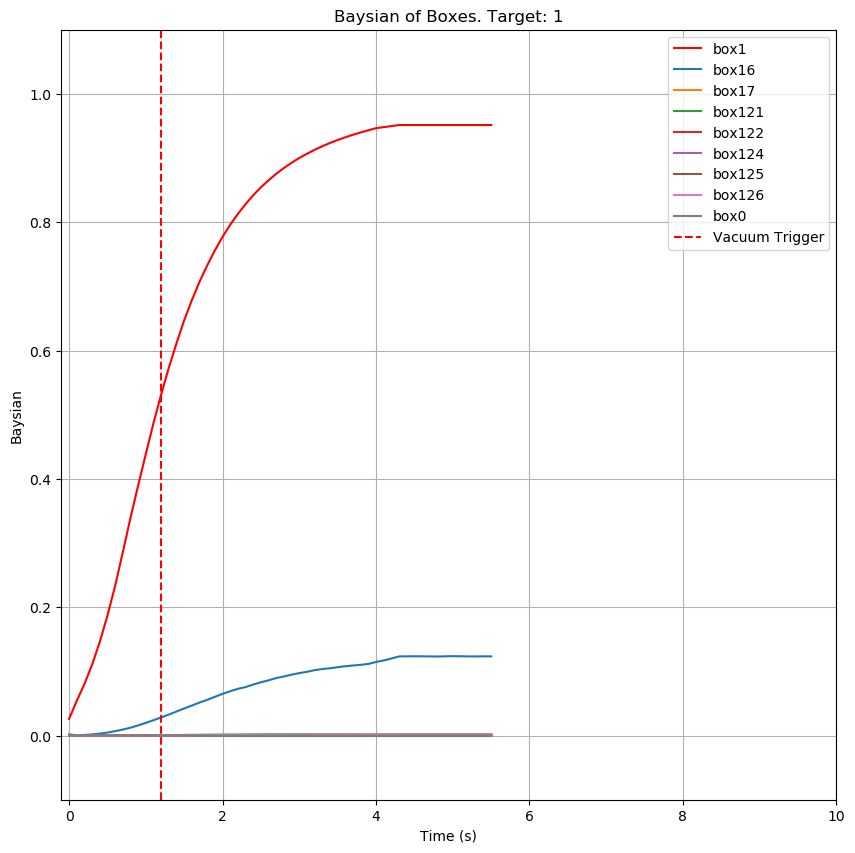

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 1 Success Time Rate: 0.013571466551854264


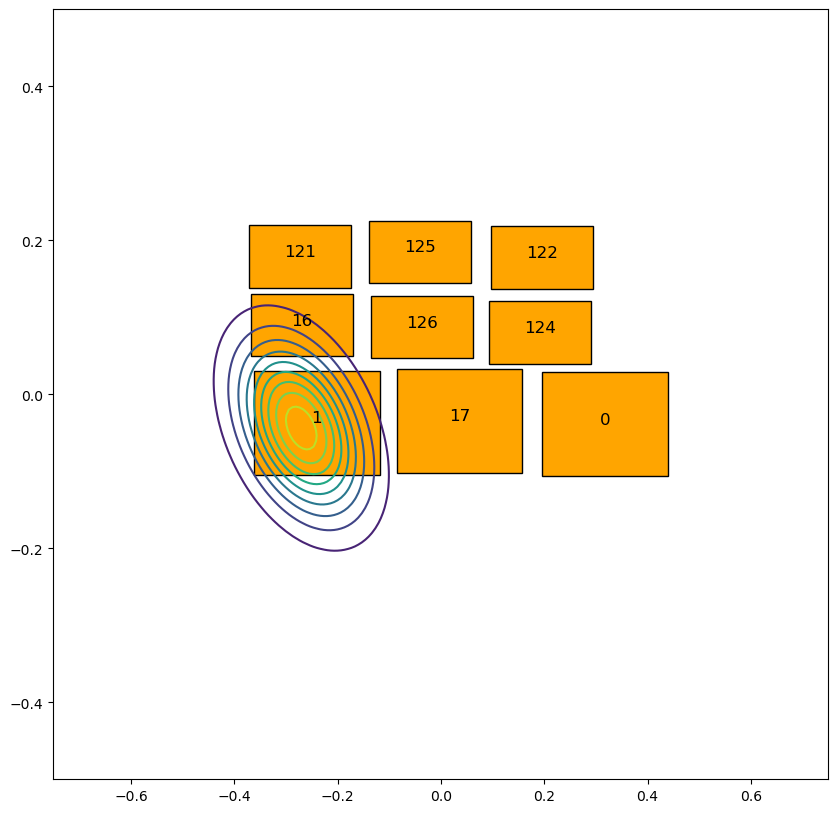

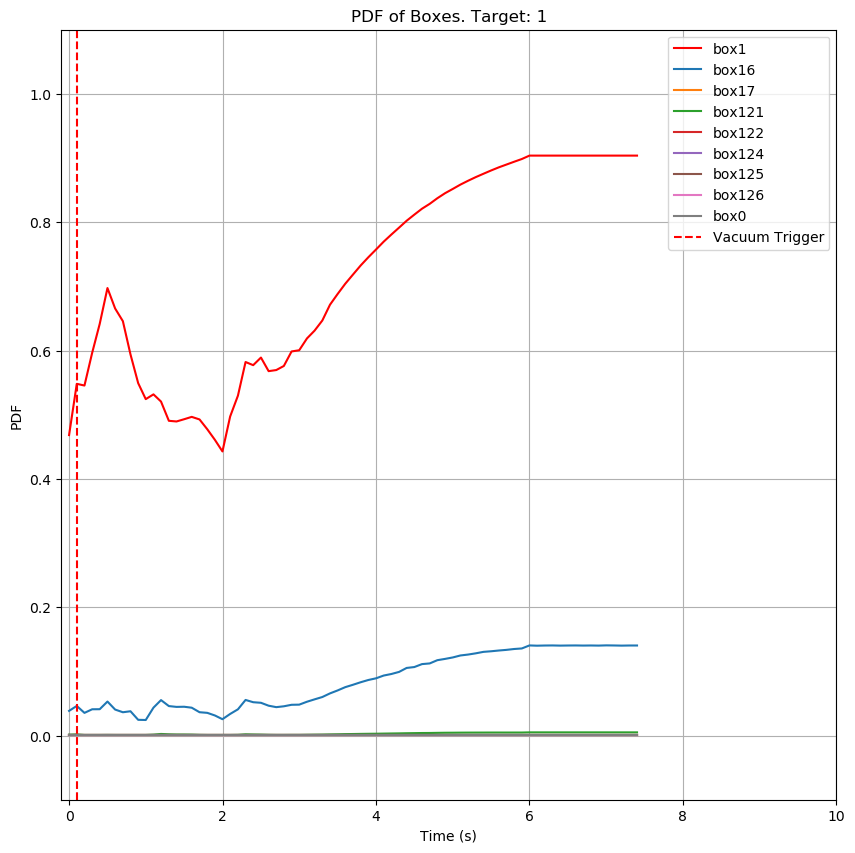

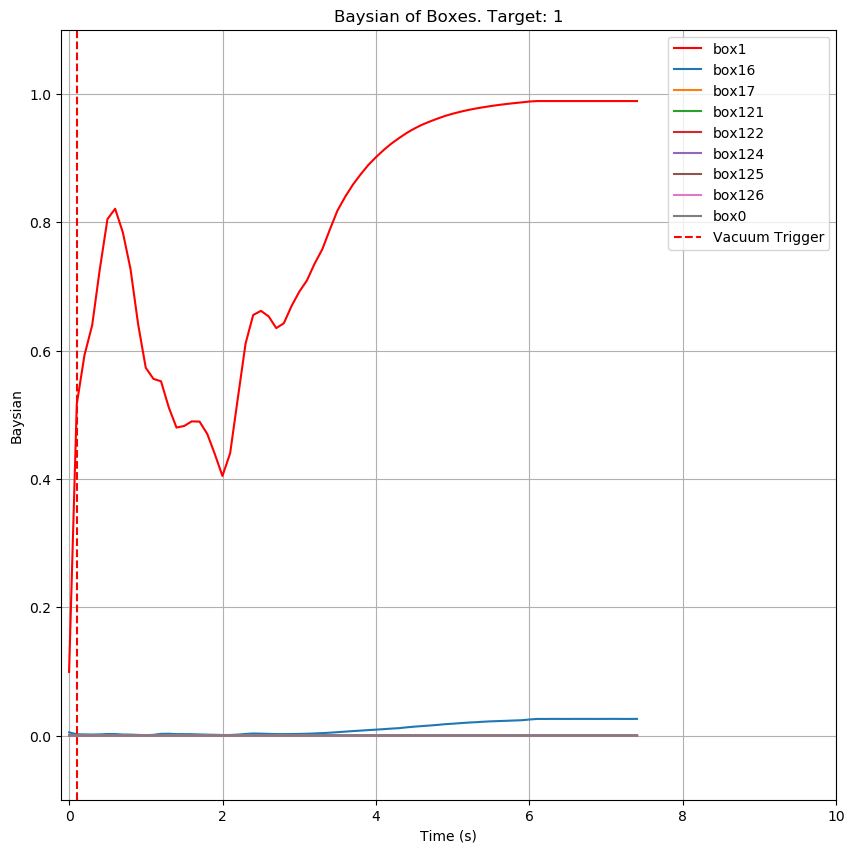

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 1 Success Time Rate: 0.012265109307865703


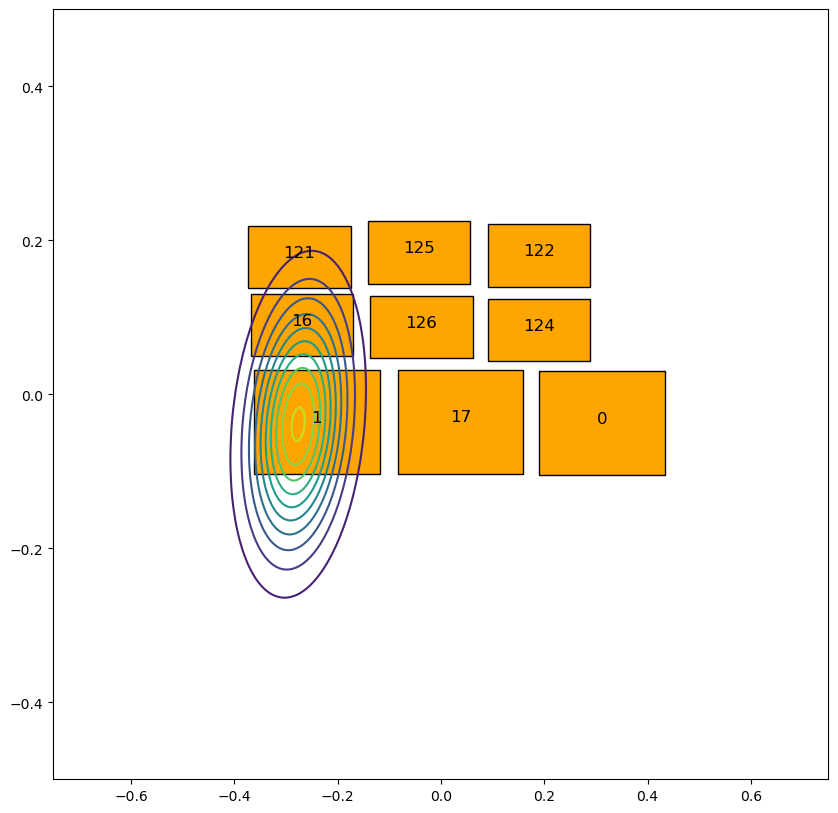

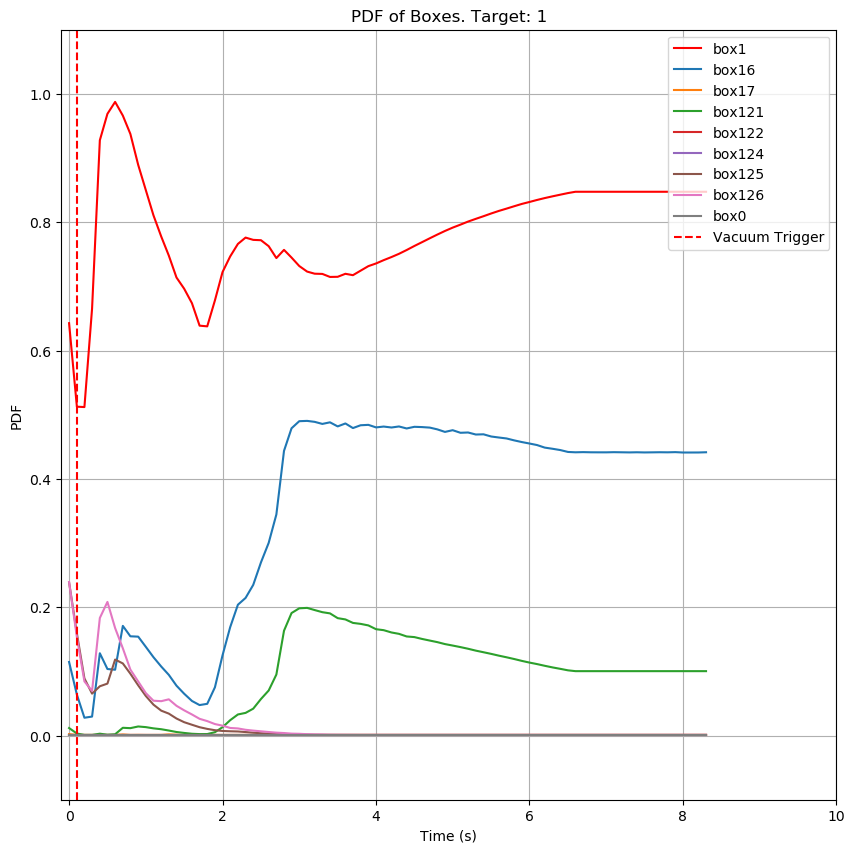

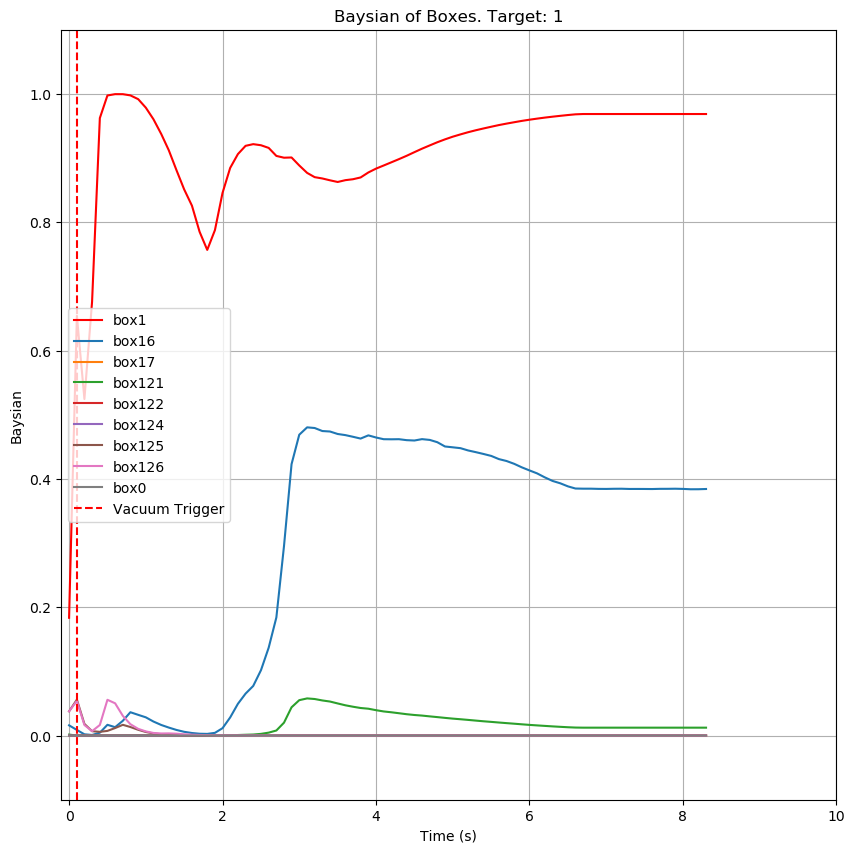

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Box 1 Success Time Rate: 0.27440556622957213


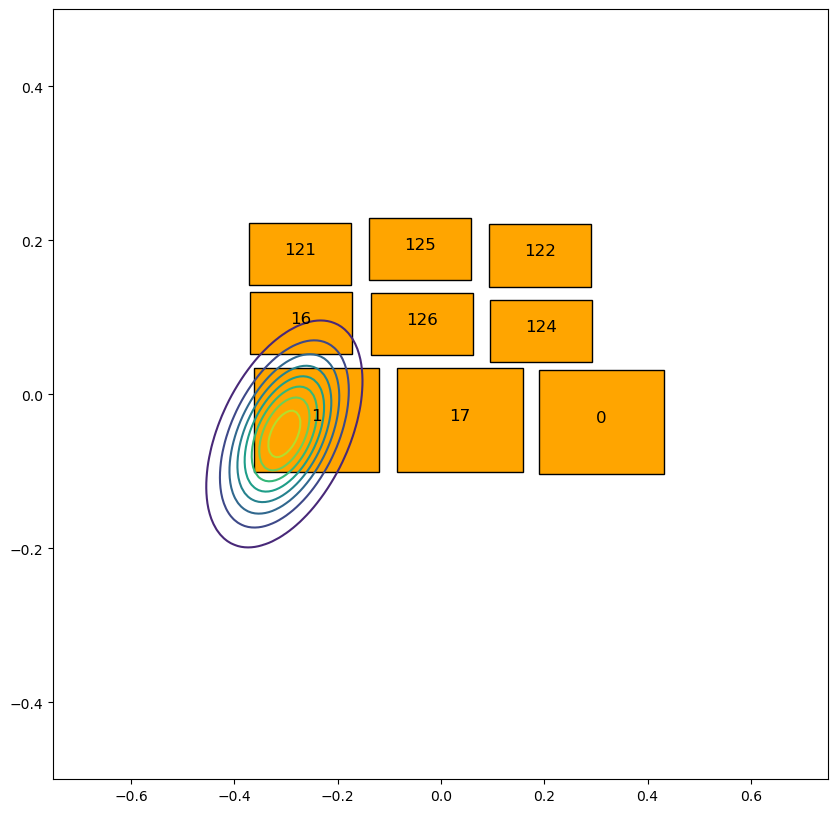

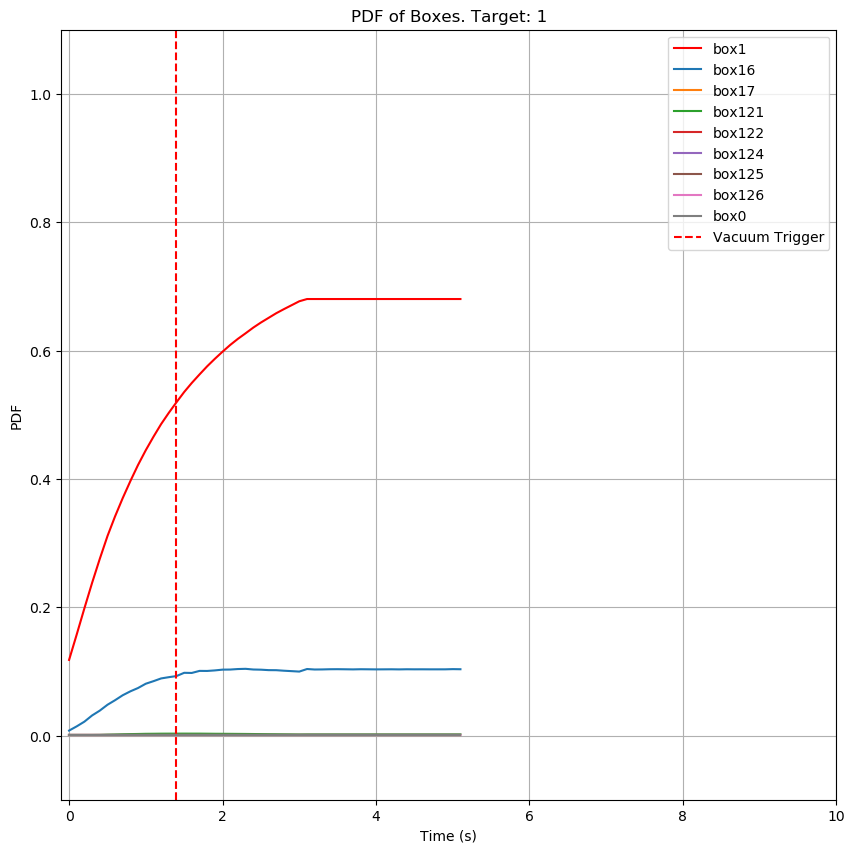

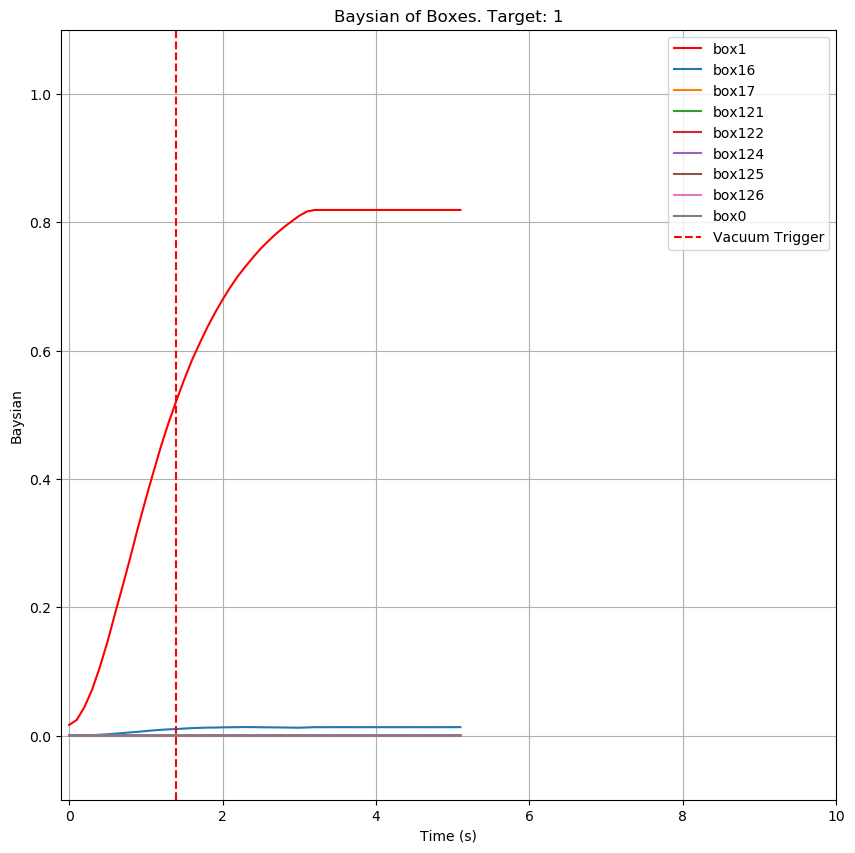

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


In [36]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


root_dir = "/home/workspace/src/log_file/pose_processed(1)"

# 데이터 로드
files = sorted(os.listdir(root_dir))

small_value = 0.001

plane = Plane(
    n=np.array([0.99768449, 0.01408773, 0.0665371]),
    d=-0.9447713826362829,
)

# 빈 데이터프레임 생성
df_success_rate = []

# 데이터프레임 생성
for i, file in enumerate(files):
    data = pd.read_csv(root_dir + "/" + file)

    # print(root_dir + "/" + file)

    target_id = data["desired_box"].iloc[0]
    target_boxes_index = -1

    # PDF 확률 보간
    for i in range(9):
        data[f"field.boxes{i}.pdf"] = data[f"field.boxes{i}.pdf"].fillna(method="ffill")
        data[f"field.boxes{i}.pdf"] = data[f"field.boxes{i}.pdf"].apply(
            lambda x: small_value if x < small_value else x
        )

    for i in range(9):
        id = data[f"field.boxes{i}.id"].loc[0]

        if id == target_id:
            target_boxes_index = i
            break

    remove_zero = True

    if remove_zero:
        # Remove rows where the sum of pdfs is under 0.001
        pdf_columns = [f"field.boxes{i}.pdf" for i in range(9)]
        data = data[data[pdf_columns].sum(axis=1) >= 0.1]

        data = data[1:]
        data["%time"] = data["%time"] - data["%time"].iloc[0]

    # 새로운 컬럼 생성
    for i in range(9):
        # 이전 인덱스 값과 현재 인덱스 값 계산
        prev_values = data[f"field.boxes{i}.pdf"].shift(
            1, fill_value=(1.0 / 9.0)
        )  # 첫 번째 행의 이전 값은 1로 채움
        current_values = data[f"field.boxes{i}.pdf"]

        possibility = prev_values  # 이전 확률
        not_prior = 1.0 - prev_values  # 이전 반대확률

        # 우도
        likelihood = current_values  # 우도
        not_likelihood = 1.0 - current_values  # 반대 우도

        # 사후확률 계산
        post_probability = likelihood * possibility  # 사후확률
        post_not_probability = not_likelihood * not_prior  # 반대 사후확률

        # 정규화 상수
        normalized_constant = post_probability + post_not_probability

        # 정규화
        new_possibility = post_probability / normalized_constant

        # 새로운 컬럼 생성
        data[f"baysian{i}"] = new_possibility  # 0으로 나누는 경우 처리

    # 새로운 컬럼 생성
    baysian_columns = [f"baysian{i}" for i in range(9)]

    target_baysian = data[f"baysian{target_boxes_index}"]
    baysian_data = data[baysian_columns]

    # 가장 큰 값과 두 번째로 큰 값 찾기
    max_baysian = baysian_data.max(axis=1)

    second_baysian = baysian_data.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)

    data["baysian_success"] = target_baysian >= second_baysian + 0.1

    data["auto"] = ((target_baysian - second_baysian) >= 0.1) & (target_baysian >= 0.5)

    if data["auto"].any():
        first_true_index = data["auto"].idxmax()
    else:
        first_true_index = len(data) - 1

    value_at_index = data["%time"].loc[first_true_index]

    success_time_rate = value_at_index / data["%time"].iloc[-1]

    if success_time_rate != 1.0:
        print(f"Box {target_id} Success Time Rate: {success_time_rate}")
    else:
        print(f"Box {target_id} Success Time Rate: 1.0")
    # print(f"Last Time: {data['%time'].iloc[-1]}")

    success_rate = data["baysian_success"].sum() / data.shape[0]

    df_success_rate.append(success_rate)

    # 가우시안 분포 처리
    gaussian_x = data["field.pose.pose.position.x"].iloc[-1]
    gaussian_y = data["field.pose.pose.position.y"].iloc[-1]
    gaussian_z = data["field.pose.pose.position.z"].iloc[-1]

    gaussian_cov = [f"field.pose.covariance{i}" for i in range(36)]

    gaussian_pose = np.array([gaussian_x, gaussian_y, gaussian_z])
    gaussian_cov = np.array(data[gaussian_cov].iloc[-1]).reshape(6, 6)[:3, :3]

    gaussian_pose_2d, gaussian_cov_2d = plane.transform_to_2d(
        gaussian_pose, gaussian_cov
    )

    distances = []

    # 박스 위치 처리
    box_pose_x = [f"field.boxes{i}.pose.position.x" for i in range(9)]
    box_pose_y = [f"field.boxes{i}.pose.position.y" for i in range(9)]
    box_pose_z = [f"field.boxes{i}.pose.position.z" for i in range(9)]
    box_id = [f"field.boxes{i}.id" for i in range(9)]

    box_poses = []

    for i in range(9):
        box_pose = [data[box_pose_x[i]], data[box_pose_y[i]], data[box_pose_z[i]]]
        avg_box_pose = np.mean(box_pose, axis=1)
        avg_box_cov = np.cov(box_pose)

        avg_box_pose_2d, avg_box_cov_2d = plane.transform_to_2d(
            avg_box_pose, avg_box_cov
        )

        distance = np.abs(np.linalg.norm(gaussian_pose_2d - avg_box_pose_2d))

        distances.append(float(distance))

        box_poses.append([avg_box_pose_2d, avg_box_cov_2d, data[box_id[i]].iloc[0]])

    plot = True

    if plot:

        # 박스 위치 그래프 그리기
        fig, ax = plt.subplots(figsize=(10, 10))

        def create_box(ax, x, y, width, height):
            # 사각형 생성
            lower_left_x = x - width / 2
            lower_left_y = y - height / 2
            rectangle = patches.Rectangle(
                (lower_left_x, lower_left_y),  # 왼쪽 아래 모서리 좌표
                width,  # 너비
                height,  # 높이
                linewidth=1,
                edgecolor="black",
                facecolor="orange",
            )

            ax.add_patch(rectangle)

        for box_pose in box_poses:
            pose = box_pose[0]
            cov = box_pose[1]
            id = box_pose[2]

            if id == 0 or id == 17 or id == 1:
                width = 0.27 * 0.9
                height = 0.15 * 0.9
            else:
                width = 0.22 * 0.9
                height = 0.09 * 0.9

            # 박스 플롯
            create_box(ax, pose[0], pose[1], width, height)

            # 각 박스의 가우시안 분포 플롯
            # x와 y 좌표 생성
            x = np.linspace(pose[0] - 1.0, pose[0] + 1.0, 300)
            y = np.linspace(pose[1] - 1.0, pose[1] + 1.0, 300)
            X, Y = np.meshgrid(x, y)

            # 2차원 가우시안 분포의 확률 밀도 함수 계산
            pos = np.dstack((X, Y))
            rv = multivariate_normal(pose, cov, allow_singular=True)
            Z = rv.pdf(pos)

            plt.text(pose[0], pose[1], f"{id}", fontsize=12, ha="center")

            # 등고선 플롯
            # contour = plt.contour(X, Y, Z, levels=3, cmap="viridis")

        # 가우시안 분포 플롯
        # x와 y 좌표 생성
        x = np.linspace(gaussian_pose_2d[0] - 1.0, gaussian_pose_2d[0] + 1.0, 300)
        y = np.linspace(gaussian_pose_2d[1] - 1.0, gaussian_pose_2d[1] + 1.0, 300)
        X, Y = np.meshgrid(x, y)

        # 2차원 가우시안 분포의 확률 밀도 함수 계산
        pos = np.dstack((X, Y))
        rv = multivariate_normal(gaussian_pose_2d, gaussian_cov_2d, allow_singular=True)
        Z = rv.pdf(pos)

        # 등고선 플롯
        contour = plt.contour(X, Y, Z, levels=10, cmap="viridis")

        plt.xlim(-0.75, 0.75)
        plt.ylim(-0.5, 0.5)

        plt.show()

        # 그래프 그리기
        plt.figure(figsize=(10, 10))

        # 각 박스의 PDF 그래프 그리기
        for i in range(len(desired_box_values)):
            box_id = data[f"field.boxes{i}.id"].iloc[0]
            plt.plot(
                data["%time"].to_numpy(),
                data[f"field.boxes{i}.pdf"].to_numpy(),
                label=f"box{box_id}",
                c="r" if box_id == target_id else None,
            )

        # 수직선 추가
        plt.axvline(
            x=value_at_index, color="red", linestyle="--", label="Vacuum Trigger"
        )

        plt.legend()

        plt.xlim(-0.1, 10.0)
        plt.ylim(-0.1, 1.1)

        plt.xlabel("Time (s)")
        plt.ylabel("PDF")

        plt.title(f"PDF of Boxes. Target: {target_id}")

        plt.grid()
        plt.show()

        # 그래프 그리기
        plt.figure(figsize=(10, 10))

        # 각 박스의 베이지안 그래프 그리기
        for i in range(len(desired_box_values)):
            box_id = data[f"field.boxes{i}.id"].iloc[0]
            plt.plot(
                data["%time"].to_numpy(),
                data[f"baysian{i}"].to_numpy(),
                label=f"box{box_id}",
                c="r" if box_id == target_id else None,
            )

        # 수직선 추가
        plt.axvline(
            x=value_at_index, color="red", linestyle="--", label="Vacuum Trigger"
        )

        plt.legend()

        plt.xlim(-0.1, 10.0)
        plt.ylim(-0.1, 1.1)

        plt.xlabel("Time (s)")
        plt.ylabel("Baysian")

        plt.title(f"Baysian of Boxes. Target: {target_id}")

        plt.grid()
        plt.show()

        print("@" * 100)

    # break

df_success_rate = pd.DataFrame(df_success_rate, columns=["success_rate"])
# display(df_success_rate)

In [ ]:
df_success_rate.describe()

In [ ]:
data = pd.read_csv("/home/workspace/src/log_file/pose_processed(1)/box121_data2.csv")

goal = np.array([-0.26511266, 0.17079955])

time = data["%time"].to_numpy()

pose = [
    "field.pose.pose.position.x",
    "field.pose.pose.position.y",
    "field.pose.pose.position.z",
]

# cov = [f"field.pose.covariance{i}" for i in range(36)]

# required_columns = pose + cov

data = data[pose]

data = data.to_numpy()

distances = []

for d in data:
    position_2d, _ = plane.transform_to_2d(d, np.eye(3))

    distance = np.linalg.norm(position_2d - goal)

    distances.append(distance)

plt.plot(time, distances)

### 입력 매개 변수

* 초반 누적 갯수 n
* 판단 임계점 possibility_threshold
* 차이 판단 임계점 gap_possibility_threshold

### 판단 근거

* 작업 성공률 => 0.0 ~ 1.0 사이의 값
* 인지 속도 => 0.0 ~ inf 사이의 값

점수로 측정?

작업 성공률은 0.5 / 0.9 사이에서 정규화. 0.5보다 아래면 패널티 부여
인지 속도는 2.0 / 7.0 사이에서 정규화

각각 n / 1-n 값에 따른 가중치를 부여해서 최종적인 결과를 확인

### 로깅 해야하는 값

* 각 박스의 PDF
* 시간

### 로깅 내용을 재가공하는 값

* 베이지안 확률